In [1]:
import os
os.environ['PYTHONWARNINGS'] = "ignore"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import pickle
import xgboost as xgb
import shap
from matplotlib.ticker import MaxNLocator,MultipleLocator
from scipy.stats import kendalltau
from scipy.special import expit
FEAT_CNT = 8
STATE = 'NY'
FOLDS = 5
categorical_cols =['Occupation', 'Marriage','Place of Birth','Sex', 'Race']

In [2]:
import numpy as np
print(np.__version__) #1.26.4
print(shap.__version__) #0.46.1.dev86
print(sklearn.__version__) #1.6.0
print(xgb.__version__) #1.7.6

2.0.2
0.46.1.dev86
1.5.2
2.1.3


## Preprocessing

In [3]:
# Use White alone & African American only 
with open(file=f'dataset/ACS_Income_{STATE}.pickle', mode='rb') as f:
    df=pickle.load(f)
df = df[(df['Race']=='White alone') | (df['Race']== 'Black or African American alone')]
df.reset_index(drop=True, inplace=True)
columns = df.columns

In [4]:
with pd.option_context('future.no_silent_downcasting', True):
    df.replace([' <=50K',' >50K'],
                 [0,1], inplace = True)
    df['Sex'].replace( {'Female':0.0},inplace = True)
    df['Sex'].replace({'Male':1.0}, inplace = True)
X = df.iloc[:, 0:FEAT_CNT]
Y = df.iloc[:, FEAT_CNT]

category_col =['Occupation', 'Marriage','Place of Birth', 'Race']
X = pd.get_dummies(X, columns=category_col, drop_first=True)
for c in X.columns:
    X[c] = X[c].astype(float)
np.random.seed(0)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


## Utils

In [5]:
def plot_frequency(values):
# Count the frequency of each unique value
    unique_values = sorted(set(values))
    counts = [values.count(v) for v in unique_values]
    
    # Plot histogram in bar format
    plt.bar(unique_values, counts, color='skyblue', alpha=0.7)
    
    # Set x-ticks on every integer but label only at intervals of 5
    plt.xticks(
        ticks=range(min(unique_values), max(unique_values) + 1),  # All integers
        labels=[
            str(v) if v % 5 == 2 else "" for v in range(min(unique_values), max(unique_values) + 1)
        ]  # Labels only at intervals of 5
    )
    # Plot histogram in bar format
    plt.bar(unique_values, counts, color='skyblue', alpha=0.7)
    
    # Customize x-axis labels
    plt.xticks(unique_values)  # Set xticks to the unique values in the list
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Rank Changes')
    
    # Show plot
    plt.show()

def analyze_bins(strategy,bin_size):
    ##
    np.random.seed(0)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    for train_index, valid_index in kfold.split(X_train_val,Y_train_val): 
        print('**********START**********')
        # Balance by Sensitive Attribute
        X_train, X_valid = X_train_val.iloc[train_index], X_train_val.iloc[valid_index]
        Y_train, Y_valid = Y_train_val.iloc[train_index], Y_train_val.iloc[valid_index]

        # Define a parameter grid for XGBoost
        kd = KBinsDiscretizer(n_bins=bin_size, encode='onehot', strategy=strategy)
        
        break
    X_transformed_test = kd.fit_transform(X_test)
    age_transformed_test = X_transformed_test[:, 0:bin_size]  # Adjust to get the transformed 'age' feature
    bin_boundaries = kd.bin_edges_[0]
    # Plot the histogram of the transformed "age" feature
    plt.figure(figsize=(8, 6))
    plt.hist(np.argmax(age_transformed_test, axis=1), bins=range(bin_size+1), edgecolor='black', alpha=0.7)
    plt.title('Histogram of Frequencies for Age Bins')
    plt.xlabel('Age Bins')
    plt.ylabel('Frequency')
    

    plt.xticks(range(bin_size+1),labels=bin_boundaries, rotation=30)
    plt.show()
    return bin_boundaries

In [6]:
def train_test(X,Y, base = False):
    np.random.seed(0)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    result = dict()
    shap_vals = []
    kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    for train_index, valid_index in kfold.split(X_train_val,Y_train_val): 
        print('**********START**********')
        # Balance by Sensitive Attribute
        X_train, X_valid = X_train_val.iloc[train_index], X_train_val.iloc[valid_index]
        Y_train, Y_valid = Y_train_val.iloc[train_index], Y_train_val.iloc[valid_index]
        
        model = best_model
        explainer = shap.GPUTreeExplainer(model,X_train,feature_perturbation = 'interventional')

        shap_values = explainer(X_test)
        shap_vals.append(shap_values)
        break
    print(f'Overall average acc: {sum(accs)/len(accs):.2f} average f1s : {sum(f1s)/len(f1s):.2f}')
    result['shap_vals'] = shap_vals
    return result
def get_tfs(preds,shap_vals,Y_test=Y_test, shap_only=False):
    

    tps = list()
    fps = list()
    tns = list()
    fns = list()
    if not shap_only:
        Y_true = Y_test
    for i,(pred,sv) in enumerate(zip(preds,shap_vals)):
        if not shap_only:
            sv = sv.values
        else:
            Y_true = Y_test[i]
        TP_i = np.where((Y_true == 1.0) & (pred == 1.0))[0]  # True Positives
        FP_i = np.where((Y_true == 0.0) & (pred == 1.0))[0]  # False Positives
        TN_i = np.where((Y_true == 0.0) & (pred == 0.0))[0]  # True Negatives
        FN_i = np.where((Y_true == 1.0) & (pred == 0.0))[0]  # False Negatives
        tps.append(TP_i)
        fps.append(FP_i)
        tns.append(TN_i)
        fns.append(FN_i)
    return TP_i,FP_i,TN_i,FN_i

def analyze_shap(shap_vals):

    # Visualize SHAP summary plot for the test set
    # shap.summary_plot(shap_values, X_transformed_test, feature_names=feature_names)
    avg_shap = np.mean(np.abs(shap_vals), axis=0)
    average = pd.DataFrame({
    "Feature": X.columns,
    "Average Shap value": avg_shap,
        })
    print('## Average SHAP')
    print(average,'\n')

    # Compute rankings row-wise
    sorted_indices = np.argsort(-np.abs(shap_vals), axis=1)  # Indices of absolute values in descending order
    rankings = np.empty_like(sorted_indices)             # Create an empty array of the same shape
    rows, cols = shap_vals.shape                            # Get the shape of the array
    rankings[np.arange(rows)[:, None], sorted_indices] = np.arange(1, cols + 1)  # Assign ranks row-wise
    avg_rank = np.mean(rankings,axis=0)

    average_rank = pd.DataFrame({
    "Feature": X.columns,
    "Average Rank SHAP1": avg_rank,
        })
    print('## Average Rank')
    print(average_rank,'\n')
    age_rank = rankings[:,0]
    count, bins, _ = plt.hist(age_rank,edgecolor='black', alpha=0.7,bins=np.arange(age_rank.min(), age_rank.max()+2),align="left")
    max_tick = int(np.ceil(bins[-1]))
    count_df = pd.DataFrame({
    "Frequency": [i + 1 for i in range(max_tick-1)],
    "Ranking": count,
        })
    print(count_df,'\n')
    plt.title('Shap value of Age Rankings')
    plt.xlabel('Rankings')
    plt.ylabel('Frequency')
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.show()

    return rankings


def compare_results(s1, s2, rank1, rank2,agreed_idx):

    s1,s2 = s1.values, s2.values

    age_ranks1,age_ranks2 = rank1[:,0],rank2[:,0]
    
    shap_dif =np.abs(np.subtract(s1[:,0], s2[:,0]))
    kendalls = [kendalltau(r1,r2,method='exact').statistic for r1,r2 in zip(rank1,rank2)]
    rank_dif = [r1-r2 for r1,r2 in zip(age_ranks1,age_ranks2) if (r1-r2) != 0 ]
    abs_rank_dif = [abs(r1-r2) for r1,r2 in zip(age_ranks1,age_ranks2) if (r1-r2) != 0 ]
    full_abs_rank_dif = [abs(r1-r2) for r1,r2 in zip(age_ranks1,age_ranks2)]
    full_rank_dif = [r1-r2 for r1,r2 in zip(age_ranks1,age_ranks2)]
    plot_frequency(rank_dif)
    top_4_idx = list()
    largest = list(np.argsort(full_rank_dif)[-100:][::-1])
    smallest = list(np.argsort(full_rank_dif)[:100])
    for l in largest:
        if len(top_4_idx) < 2 and l in agreed_idx:
            top_4_idx.append(l)
    for s in smallest:
        if len(top_4_idx) < 4 and s in agreed_idx:
            top_4_idx.append(s)

    
    
    print(f'Average individual difference {np.mean(shap_dif):.3f}')
    print(f'abs Rank change by rank FULL {np.mean(full_abs_rank_dif):.3f}')
    print(f'abs Rank change by rank {np.mean(abs_rank_dif):.3f}')
    
    print(f'% of Rank difference {np.count_nonzero(age_ranks1 != age_ranks2)/len(age_ranks1)*100:.2f}','\n')
    print(f'kendal tau {np.mean(kendalls)}')
        

    return top_4_idx

def compare_ranks(rank1, rank2):


    age_ranks1,age_ranks2 = rank1[:,0],rank2[:,0]
    kendalls = [kendalltau(r1,r2,method='exact').statistic for r1,r2 in zip(rank1,rank2)]
    rank_dif = [r1-r2 for r1,r2 in zip(age_ranks1,age_ranks2) if (r1-r2) != 0 ]
    abs_rank_dif = [abs(r1-r2) for r1,r2 in zip(age_ranks1,age_ranks2) if (r1-r2) != 0 ]
    full_abs_rank_dif = [abs(r1-r2) for r1,r2 in zip(age_ranks1,age_ranks2)]
    full_rank_dif = [r1-r2 for r1,r2 in zip(age_ranks1,age_ranks2)]
    plot_frequency(rank_dif)
    top_4_idx = list()
    largest = list(np.argsort(full_rank_dif)[-100:][::-1])
    smallest = list(np.argsort(full_rank_dif)[:100])

    
    print(f'abs Rank change by rank FULL {np.mean(full_abs_rank_dif):.3f}')
    print(f'abs Rank change by rank {np.mean(abs_rank_dif):.3f}')
    
    print(f'% of Rank difference {np.count_nonzero(age_ranks1 != age_ranks2)/len(age_ranks1)*100:.2f}','\n')
    print(f'kendal tau {np.mean(kendalls)}')
    
def compute_fidelity(pred, sv, base):

    sv_sums = expit(np.sum(sv, axis=1)+base)
    binary_predictions = (sv_sums > 0.5).astype(float)
    fidelity = np.mean(binary_predictions == pred)
    match_idx = np.where(binary_predictions == binary_predictions)[0]
        
    return fidelity,match_idx
            

## Train the model with plain Age

In [7]:

np.random.seed(0)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
result = dict()
shap_vals = []
preds = []
accs = []
f1s = []
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
models = list()
explainers = list()
for train_index, valid_index in kfold.split(X_train_val,Y_train_val): 
    print('**********START**********')
    # Balance by Sensitive Attribute
    X_train, X_valid = X_train_val.iloc[train_index], X_train_val.iloc[valid_index]
    Y_train, Y_valid = Y_train_val.iloc[train_index], Y_train_val.iloc[valid_index]
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],  # Number of boosting rounds
        'classifier__max_depth': [3, 5, 7,9,11],          # Maximum tree depth
        'classifier__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage 
        'classifier__colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns for each tree
        'classifier__gamma': [0, 0.1, 0.2],          # Minimum loss reduction for a split
    }
    model = xgb.XGBClassifier(random_state=42)
    grid_search = GridSearchCV(
        model, 
        param_grid,              # 3-fold cross-validation
        scoring='f1',   # Evaluation metric
        n_jobs=-1,            # Use all processors
        verbose=1             # Print progress
    )

    grid_search.fit(X_train, Y_train)
    
    # Extract the best model
    best_model = grid_search.best_estimator_
    explainer = shap.GPUTreeExplainer(best_model,X_train, feature_perturbation='interventional') 
    shap_values = explainer(X_test)
    
    pred = best_model.predict(X_test)
    accs.append(accuracy_score(Y_test,pred)*100)
    f1s.append(f1_score(Y_test,pred)*100)
    models.append(best_model) 
    preds.append(pred)
    shap_vals.append(shap_values)
    break
print(f'Overall average acc: {sum(accs)/len(accs):.2f} average f1s : {sum(f1s)/len(f1s):.2f}')
result['shap_vals'] = shap_vals
result['preds'] = preds
result['models'] = models
base_result = result




**********START**********
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Overall average acc: 77.18 average f1s : 73.48


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.831176
1                                           Education            0.843665
2                                 Work Hours per Week            0.892671
3                                                 Sex            0.264036
4   Occupation_Employee of a private not-for-profi...            0.045347
5              Occupation_Federal government employee            0.014927
6   Occupation_Local government employee (city, co...            0.059286
7   Occupation_Self-employed in own incorporated b...            0.029620
8   Occupation_Self-employed in own not incorporat...            0.084886
9                Occupation_State government employee            0.046159
10  Occupation_Working without pay in family busin...            0.005291
11                                   Marriage_Married            0.105893
12       Marriage_Neve

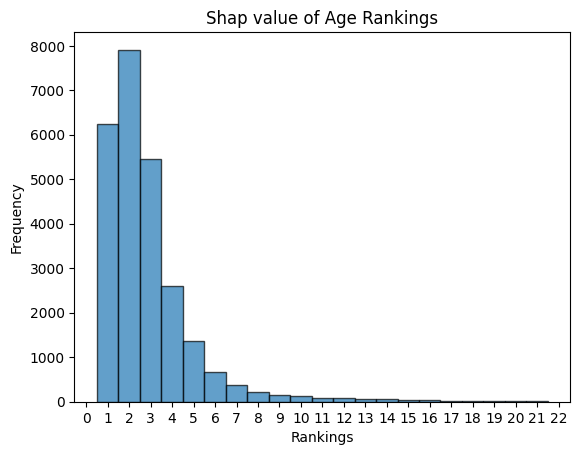

In [8]:
for sv in base_result['shap_vals']:
    sv = sv.values
    base_ranks= analyze_shap(sv)
    break

In [9]:
tps,fps,tns,fns = get_tfs(base_result['preds'], base_result['shap_vals'],Y_test)
# base_tps = analyze_shap(tps,True)
# base_fps = analyze_shap(fps,True)
# base_tns = analyze_shap(tns,True)
# base_fns = analyze_shap(fns,True)

## Base TF

(25594, 22)
## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.475846
1                                           Education            0.936544
2                                 Work Hours per Week            0.655521
3                                                 Sex            0.272376
4   Occupation_Employee of a private not-for-profi...            0.048987
5              Occupation_Federal government employee            0.019115
6   Occupation_Local government employee (city, co...            0.081658
7   Occupation_Self-employed in own incorporated b...            0.034001
8   Occupation_Self-employed in own not incorporat...            0.085973
9                Occupation_State government employee            0.059988
10  Occupation_Working without pay in family busin...            0.004145
11                                   Marriage_Married            0.106130
12       M

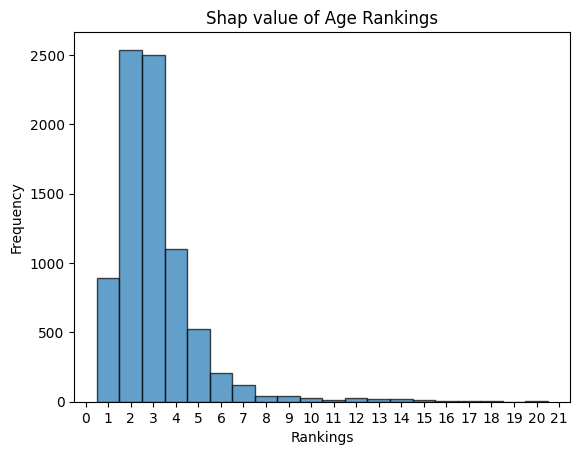

In [10]:
for sv in base_result['shap_vals']:
    print(sv.shape)
    sv = sv.values[tps,:]
    base_tps = analyze_shap(sv)
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.518147
1                                           Education            0.795374
2                                 Work Hours per Week            0.598324
3                                                 Sex            0.281115
4   Occupation_Employee of a private not-for-profi...            0.048767
5              Occupation_Federal government employee            0.021892
6   Occupation_Local government employee (city, co...            0.078609
7   Occupation_Self-employed in own incorporated b...            0.033419
8   Occupation_Self-employed in own not incorporat...            0.092983
9                Occupation_State government employee            0.056376
10  Occupation_Working without pay in family busin...            0.005144
11                                   Marriage_Married            0.107949
12       Marriage_Neve

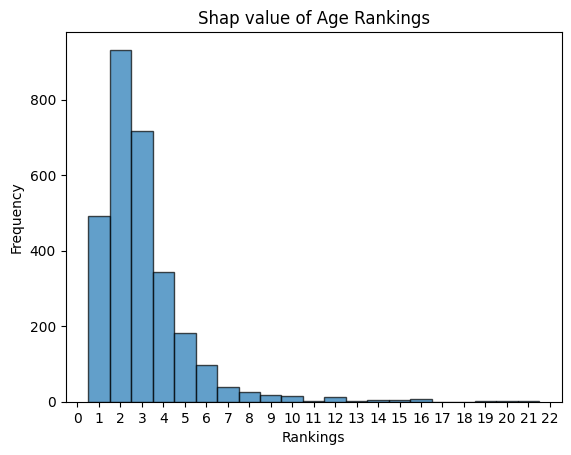

In [11]:
for sv in base_result['shap_vals']:
    sv = sv.values[fps,:]
    base_fps = analyze_shap(sv)
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            1.215334
1                                           Education            0.814251
2                                 Work Hours per Week            1.186574
3                                                 Sex            0.248988
4   Occupation_Employee of a private not-for-profi...            0.042032
5              Occupation_Federal government employee            0.010614
6   Occupation_Local government employee (city, co...            0.041669
7   Occupation_Self-employed in own incorporated b...            0.027554
8   Occupation_Self-employed in own not incorporat...            0.075224
9                Occupation_State government employee            0.034541
10  Occupation_Working without pay in family busin...            0.005746
11                                   Marriage_Married            0.107426
12       Marriage_Neve

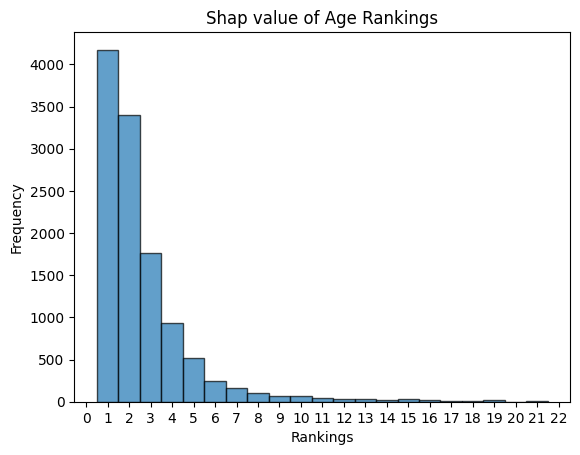

In [12]:
for sv in base_result['shap_vals']:
    sv = sv.values[tns,:]
    base_tns = analyze_shap(sv)
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.593240
1                                           Education            0.752535
2                                 Work Hours per Week            0.669262
3                                                 Sex            0.283944
4   Occupation_Employee of a private not-for-profi...            0.045120
5              Occupation_Federal government employee            0.013663
6   Occupation_Local government employee (city, co...            0.048623
7   Occupation_Self-employed in own incorporated b...            0.022038
8   Occupation_Self-employed in own not incorporat...            0.112212
9                Occupation_State government employee            0.044152
10  Occupation_Working without pay in family busin...            0.006778
11                                   Marriage_Married            0.097145
12       Marriage_Neve

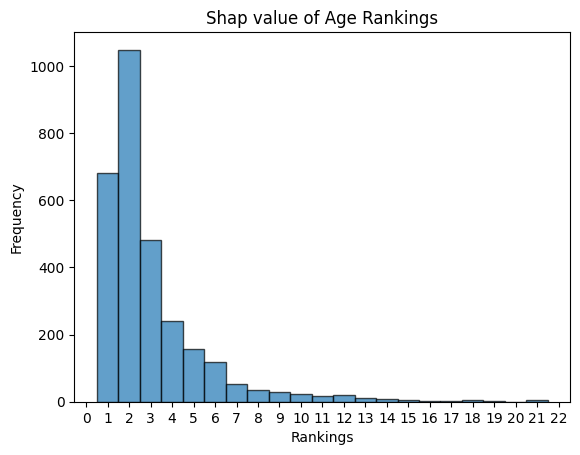

In [13]:
for sv in base_result['shap_vals']:
    sv = sv.values[fns,:]
    base_fns = analyze_shap(sv)
    break

 # Equi Depth 5

**********START**********


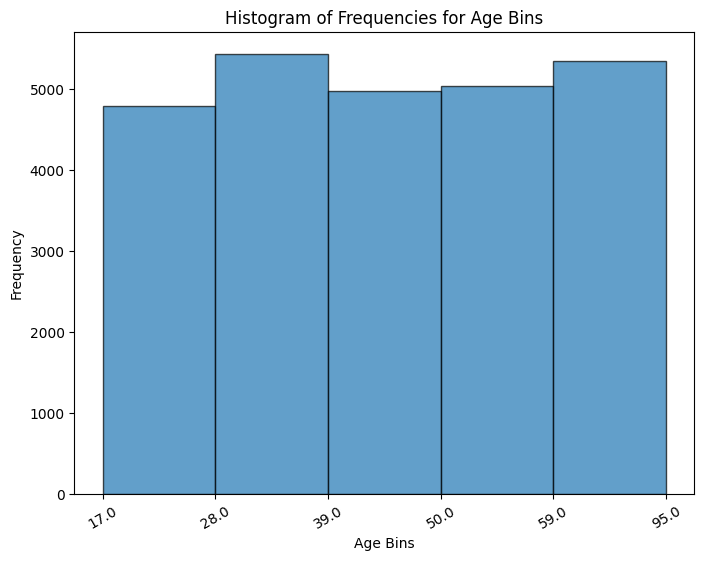

[17. 28. 39. 50. 59. 95.]


In [14]:
cut5_bins = analyze_bins('quantile',5)
print(cut5_bins)

In [15]:
# Calculate bin medians
bin_edges = cut5_bins
def assign_age(age):
    for idx in range(len(bin_edges)-1):
        if age == bin_edges[-1]:
            median = (bin_edges[-1] + bin_edges[-2])/2
        elif bin_edges[idx] <= age and age < bin_edges[idx+1]:
            median = (bin_edges[idx] + bin_edges[idx+1])/2
    return median
X2 = X.copy()
X2['Age'] = X2['Age'].apply(assign_age)
X2.head()
cut5_result = train_test(X2,Y,base=False)

**********START**********
Overall average acc: 77.18 average f1s : 73.48


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.857241
1                                           Education            0.760070
2                                 Work Hours per Week            0.903123
3                                                 Sex            0.296253
4   Occupation_Employee of a private not-for-profi...            0.029856
5              Occupation_Federal government employee            0.012974
6   Occupation_Local government employee (city, co...            0.065177
7   Occupation_Self-employed in own incorporated b...            0.037116
8   Occupation_Self-employed in own not incorporat...            0.079693
9                Occupation_State government employee            0.040175
10  Occupation_Working without pay in family busin...            0.004733
11                                   Marriage_Married            0.112861
12       Marriage_Neve

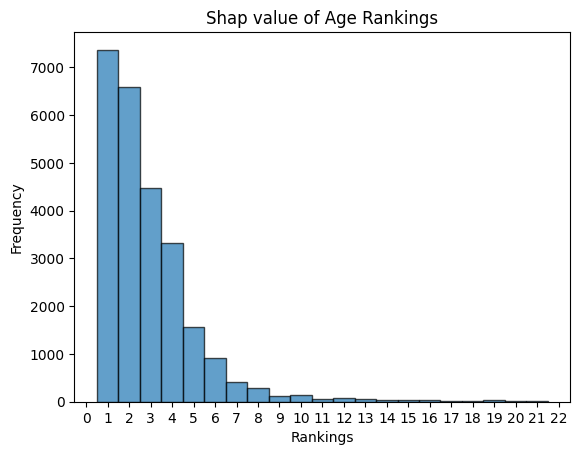

In [16]:
for sv in cut5_result['shap_vals']:
    sv = sv.values
    cut5_ranks = analyze_shap(sv)
    break

In [17]:

for i in range(FOLDS):
    preds = base_result['preds'][i]
    sv = cut5_result['shap_vals'][i].values
    base = cut5_result['shap_vals'][i].base_values
    break
cut5_fidelity,cut5_agreed = compute_fidelity(preds,sv,base)
print(f'fidelity {cut5_fidelity*100:.3f}')

fidelity 93.123


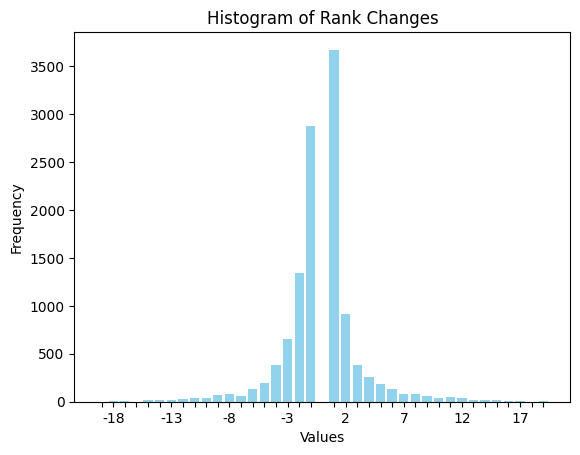

Average individual difference 0.360
abs Rank change by rank FULL 1.103
abs Rank change by rank 2.368
% of Rank difference 46.58 

kendal tau 0.8208424119965888


In [18]:
for i in range(FOLDS):
    s1 = base_result['shap_vals'][i]
    s2 = cut5_result['shap_vals'][i]
    cut5_top4_idx = compare_results(s1, s2, base_ranks, cut5_ranks ,cut5_agreed)
    break

## Cut 5 Errors

In [19]:
tps,fps,tns,fns = get_tfs(base_result['preds'], cut5_result['shap_vals'],Y_test)

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.528879
1                                           Education            0.893836
2                                 Work Hours per Week            0.674125
3                                                 Sex            0.310588
4   Occupation_Employee of a private not-for-profi...            0.034235
5              Occupation_Federal government employee            0.016943
6   Occupation_Local government employee (city, co...            0.090227
7   Occupation_Self-employed in own incorporated b...            0.040317
8   Occupation_Self-employed in own not incorporat...            0.084178
9                Occupation_State government employee            0.053297
10  Occupation_Working without pay in family busin...            0.003795
11                                   Marriage_Married            0.110100
12       Marriage_Neve

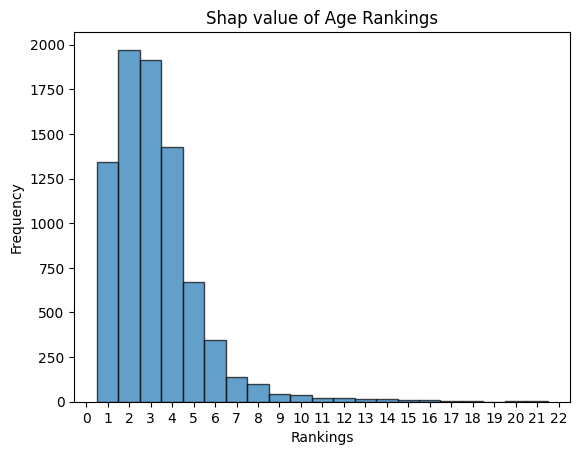

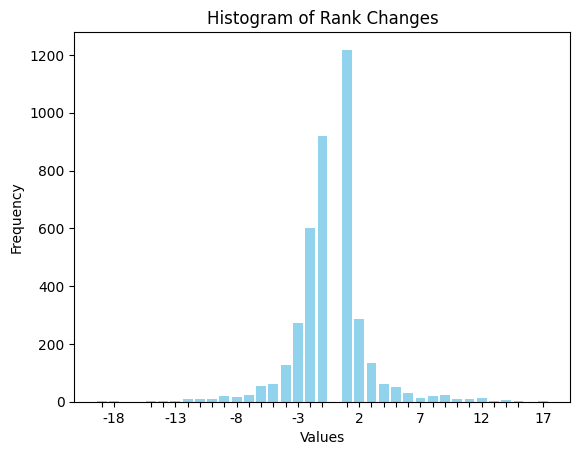

abs Rank change by rank FULL 1.105
abs Rank change by rank 2.225
% of Rank difference 49.68 

kendal tau 0.8356252063756081
fidelity 94.536


In [20]:
for i in range(FOLDS):
    sv = cut5_result['shap_vals'][i].values[tps,:]
    preds = base_result['preds'][i][tps]
    base =  cut5_result['shap_vals'][i].base_values[tps]
    fid,_ = compute_fidelity(preds,sv,base)
    cut5_tps_rank = analyze_shap(sv)
    
    compare_ranks(base_tps,cut5_tps_rank)
    print(f'fidelity {fid*100:.3f}')
    break


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.582335
1                                           Education            0.750257
2                                 Work Hours per Week            0.611907
3                                                 Sex            0.319238
4   Occupation_Employee of a private not-for-profi...            0.034336
5              Occupation_Federal government employee            0.018609
6   Occupation_Local government employee (city, co...            0.085965
7   Occupation_Self-employed in own incorporated b...            0.044062
8   Occupation_Self-employed in own not incorporat...            0.089829
9                Occupation_State government employee            0.051109
10  Occupation_Working without pay in family busin...            0.004324
11                                   Marriage_Married            0.113054
12       Marriage_Neve

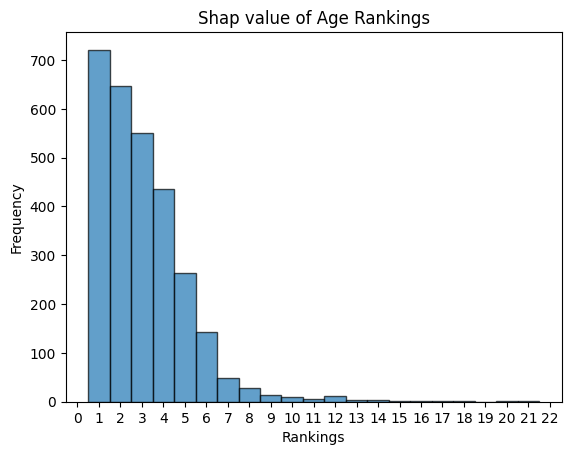

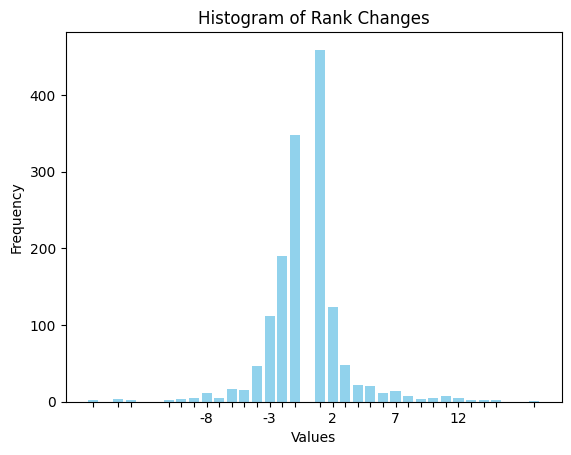

abs Rank change by rank FULL 1.158
abs Rank change by rank 2.240
% of Rank difference 51.68 

kendal tau 0.829337041772275
fidelity 87.254


In [21]:
for i in range(FOLDS):
    sv = cut5_result['shap_vals'][i].values[fps,:]
    preds = base_result['preds'][i][fps]
    base =  cut5_result['shap_vals'][i].base_values[fps]
    fid,_ = compute_fidelity(preds,sv,base)
    cut5_fps_rank = analyze_shap(sv)
    
    compare_ranks(base_fps,cut5_fps_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            1.178040
1                                           Education            0.690026
2                                 Work Hours per Week            1.191285
3                                                 Sex            0.275830
4   Occupation_Employee of a private not-for-profi...            0.025834
5              Occupation_Federal government employee            0.009095
6   Occupation_Local government employee (city, co...            0.045898
7   Occupation_Self-employed in own incorporated b...            0.034517
8   Occupation_Self-employed in own not incorporat...            0.068034
9                Occupation_State government employee            0.028911
10  Occupation_Working without pay in family busin...            0.005223
11                                   Marriage_Married            0.116407
12       Marriage_Neve

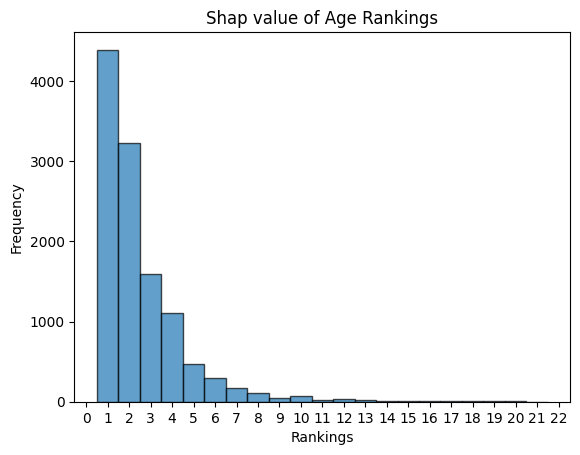

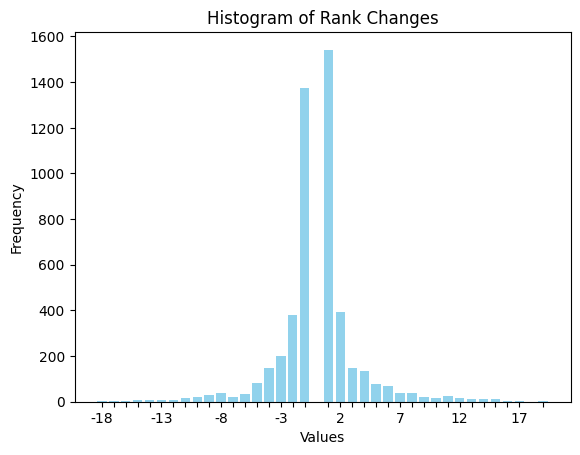

abs Rank change by rank FULL 1.002
abs Rank change by rank 2.366
% of Rank difference 42.36 

kendal tau 0.8102452483935554
fidelity 95.336


In [22]:
for i in range(FOLDS):
    sv = cut5_result['shap_vals'][i].values[tns,:]
    preds = base_result['preds'][i][tns]
    base =  cut5_result['shap_vals'][i].base_values[tns]
    fid,_ = compute_fidelity(preds,sv,base)
    cut5_tns_rank = analyze_shap(sv)
    
    compare_ranks(base_tns,cut5_tns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.758716
1                                           Education            0.679740
2                                 Work Hours per Week            0.676992
3                                                 Sex            0.315179
4   Occupation_Employee of a private not-for-profi...            0.029358
5              Occupation_Federal government employee            0.011898
6   Occupation_Local government employee (city, co...            0.052305
7   Occupation_Self-employed in own incorporated b...            0.031792
8   Occupation_Self-employed in own not incorporat...            0.103593
9                Occupation_State government employee            0.037997
10  Occupation_Working without pay in family busin...            0.005767
11                                   Marriage_Married            0.106209
12       Marriage_Neve

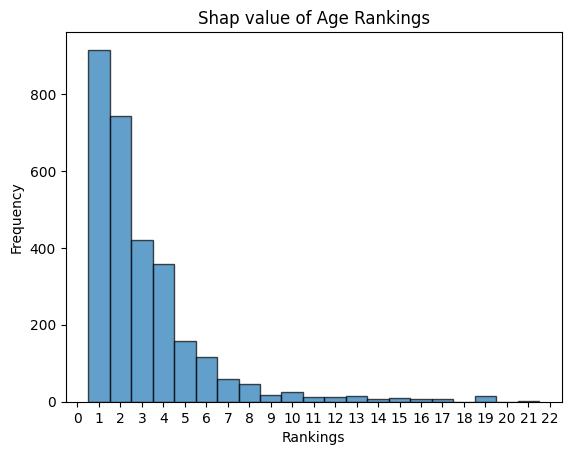

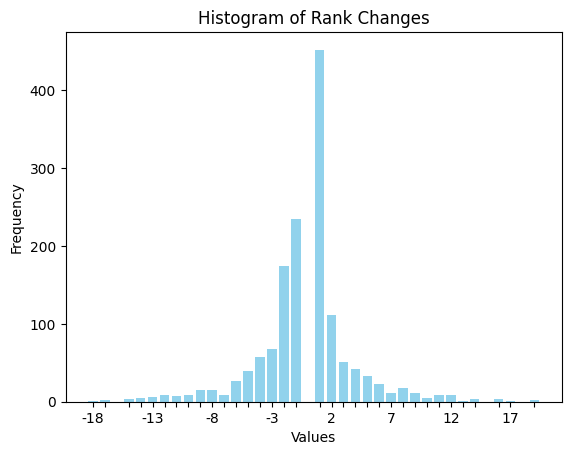

abs Rank change by rank FULL 1.444
abs Rank change by rank 2.902
% of Rank difference 49.75 

kendal tau 0.8138631035065671
fidelity 86.248


In [23]:
for i in range(FOLDS):
    sv = cut5_result['shap_vals'][i].values[fns,:]
    preds = base_result['preds'][i][fns]
    base =  cut5_result['shap_vals'][i].base_values[fns]
    fid,_ = compute_fidelity(preds,sv,base)
    cut5_fns_rank = analyze_shap(sv)
    
    compare_ranks(base_fns,cut5_fns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

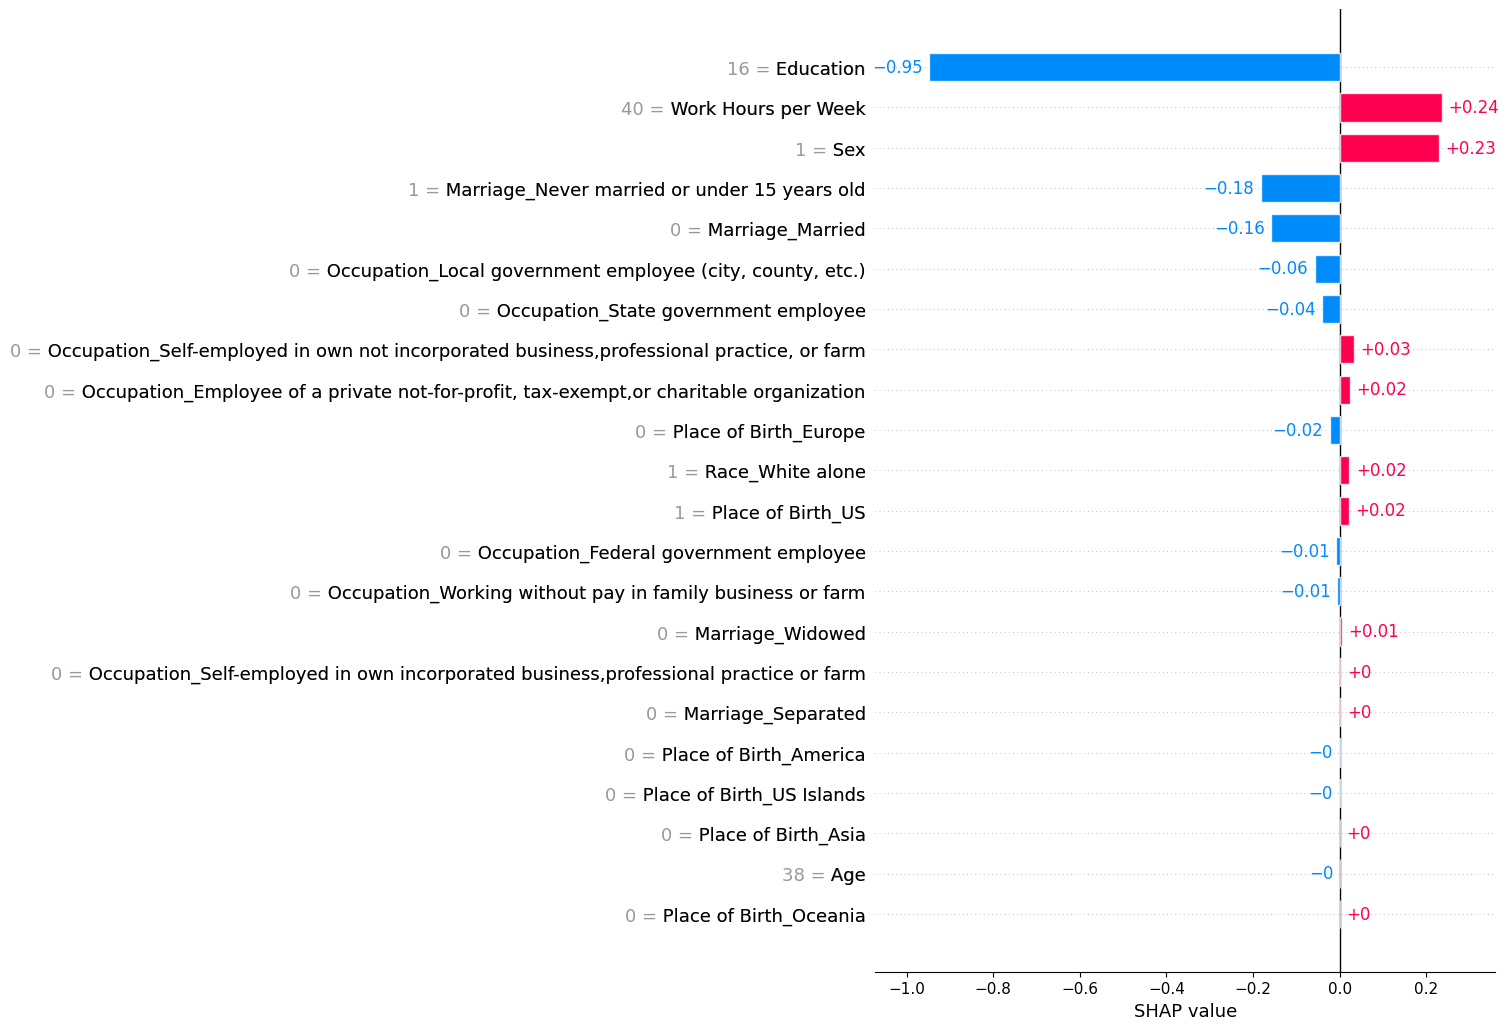

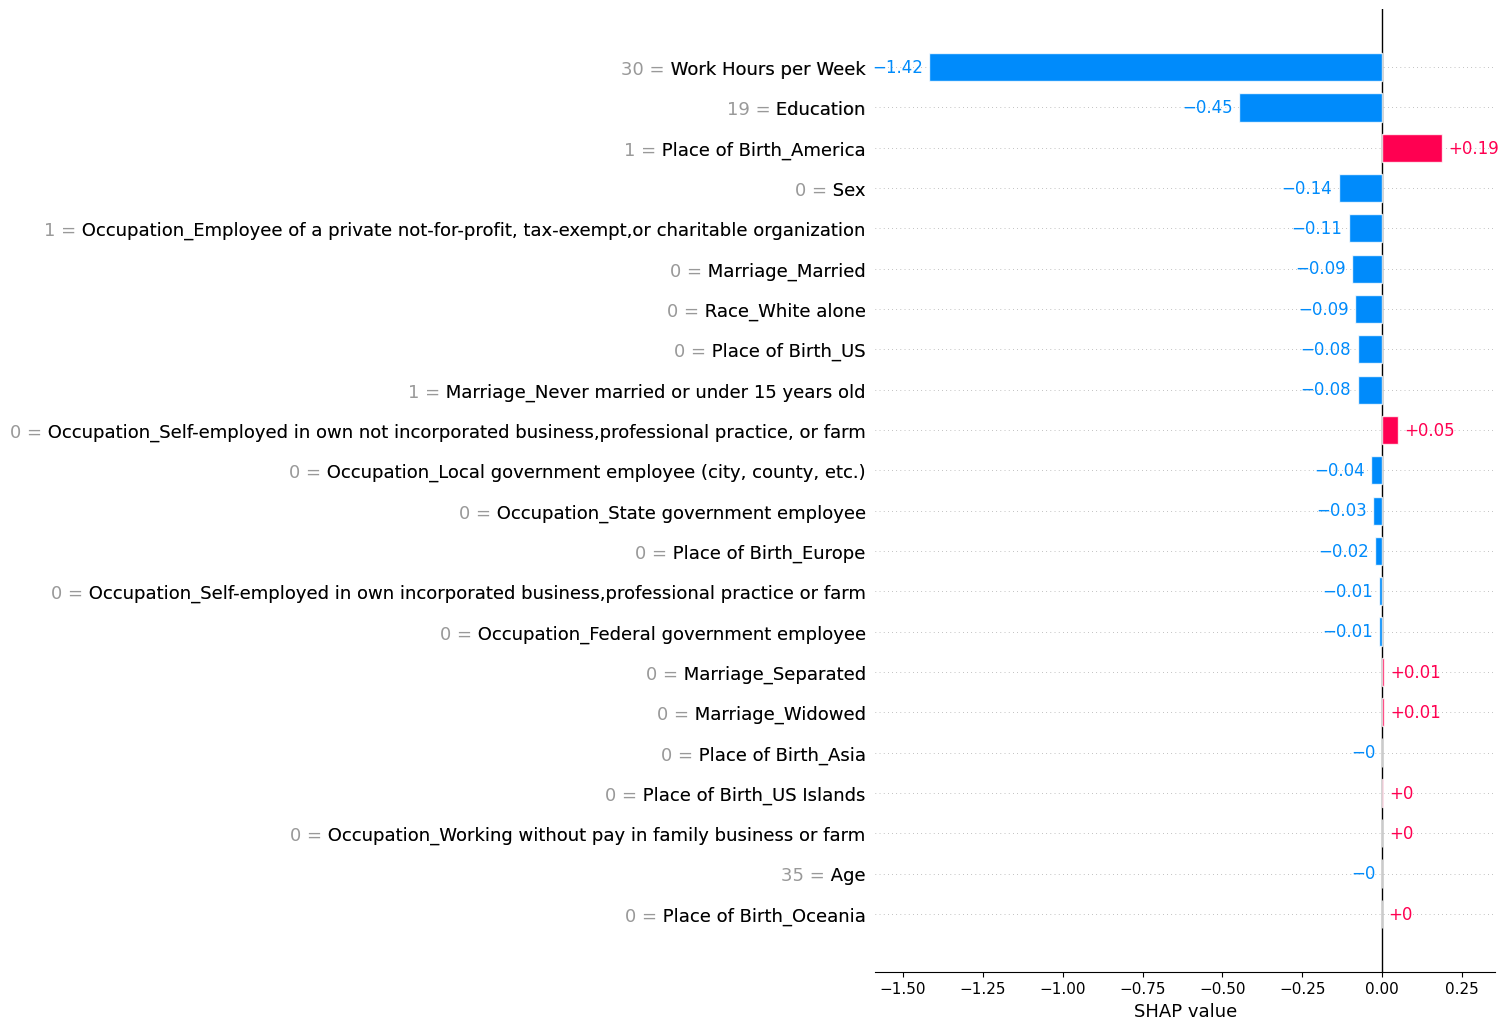

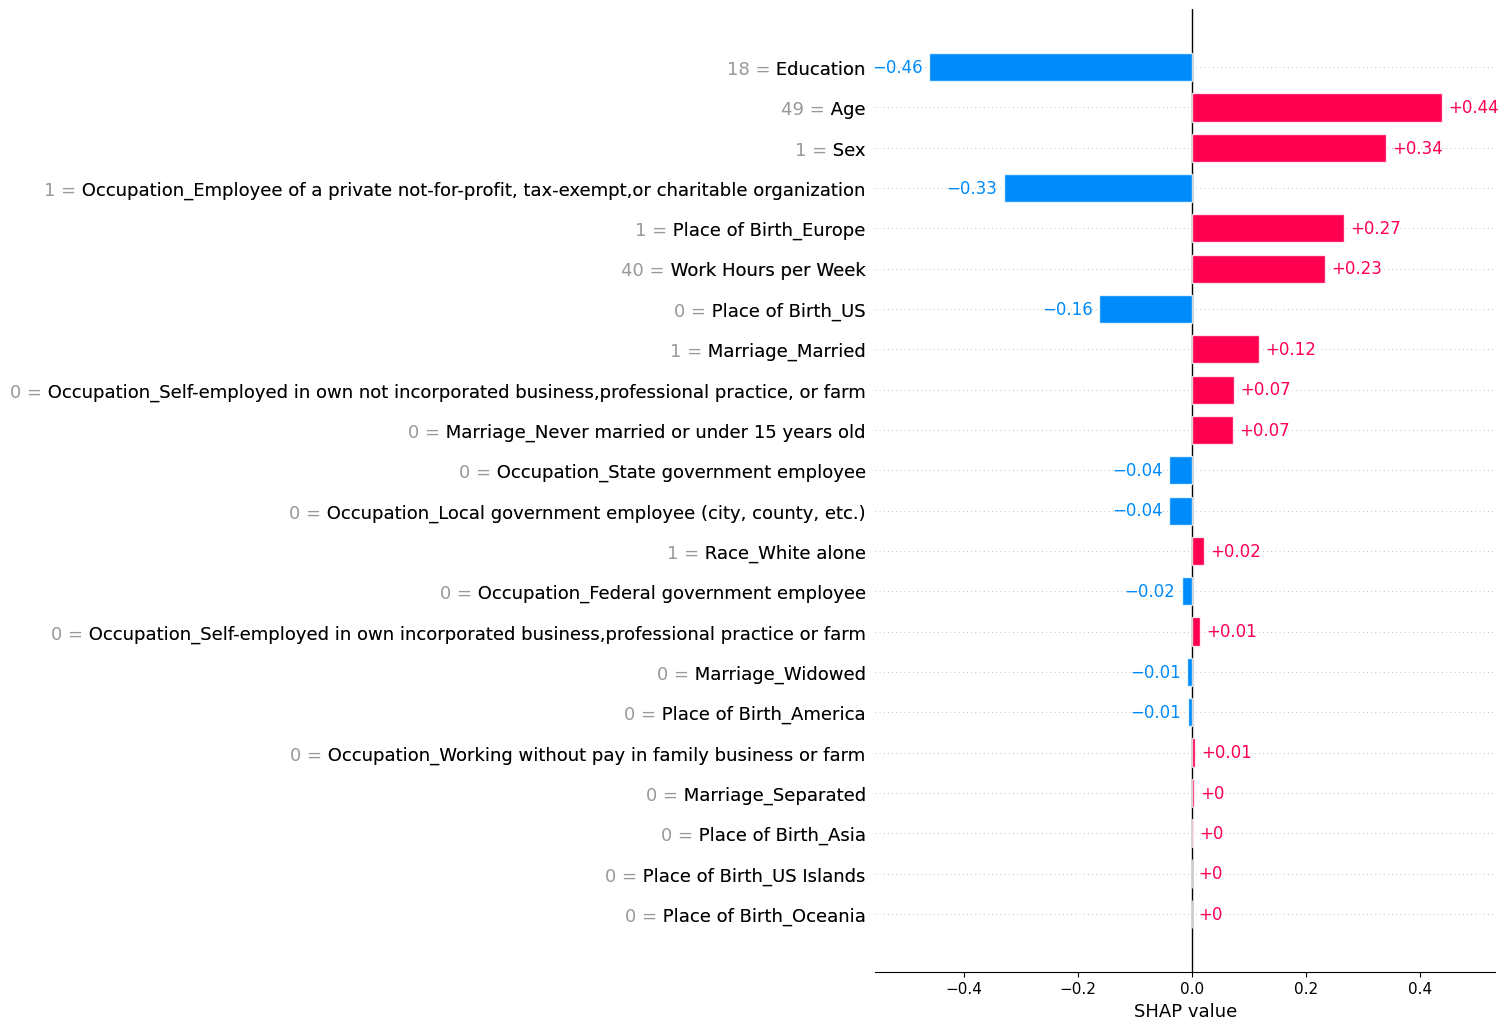

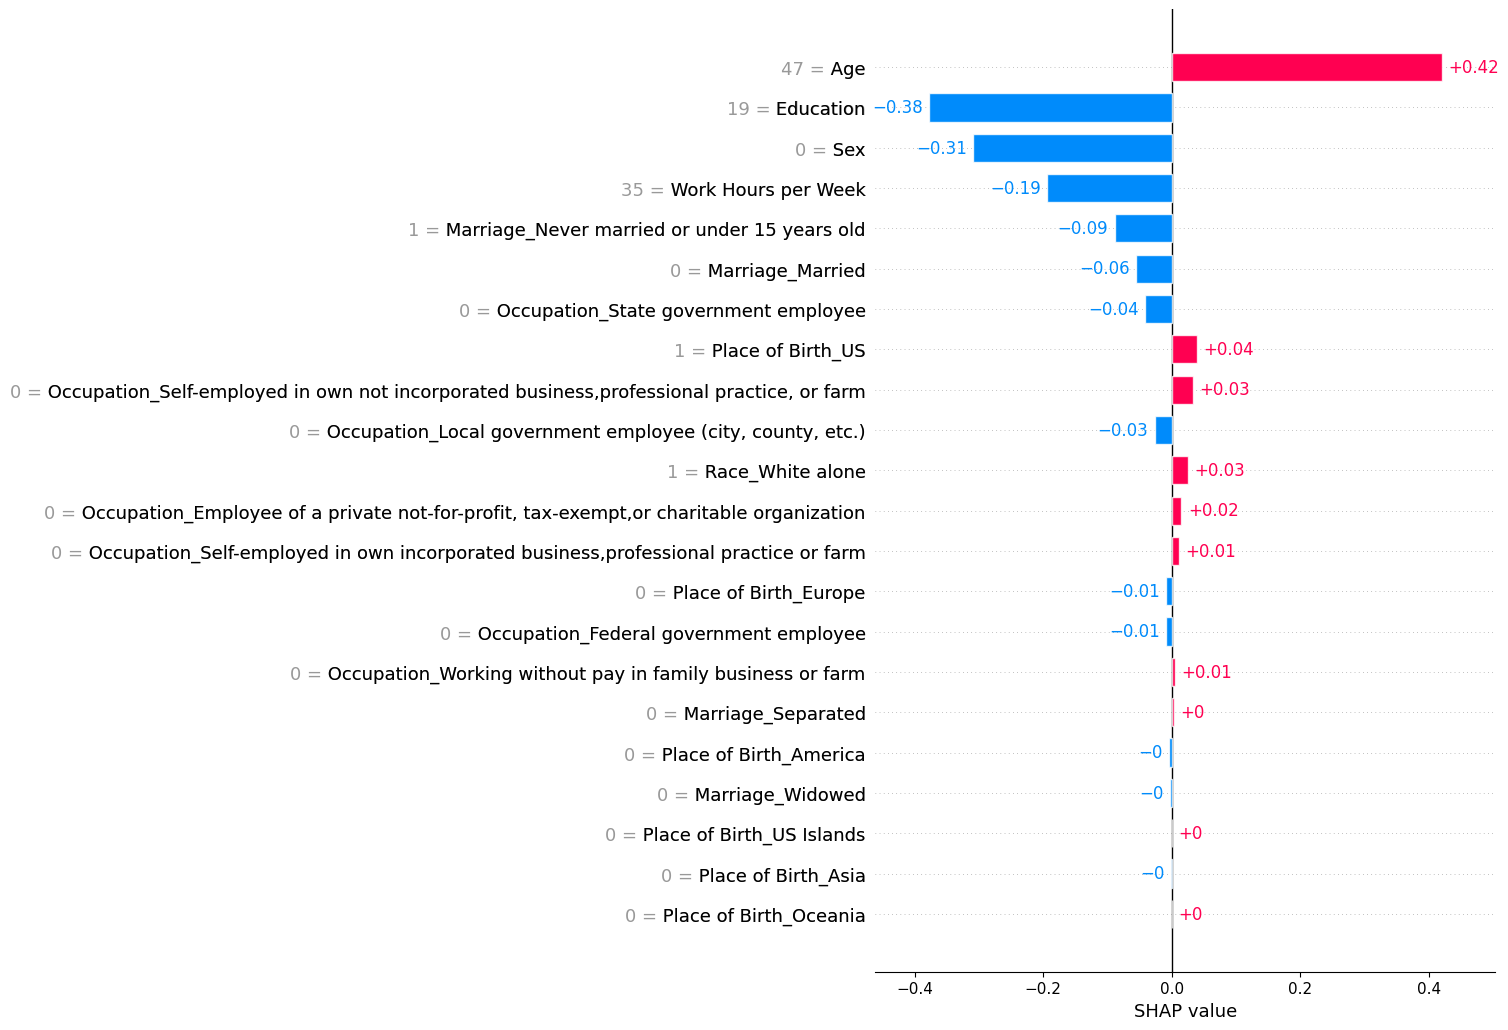

In [24]:
for i in cut5_top4_idx:
    shap.plots.bar(base_result['shap_vals'][0][i],max_display=22)

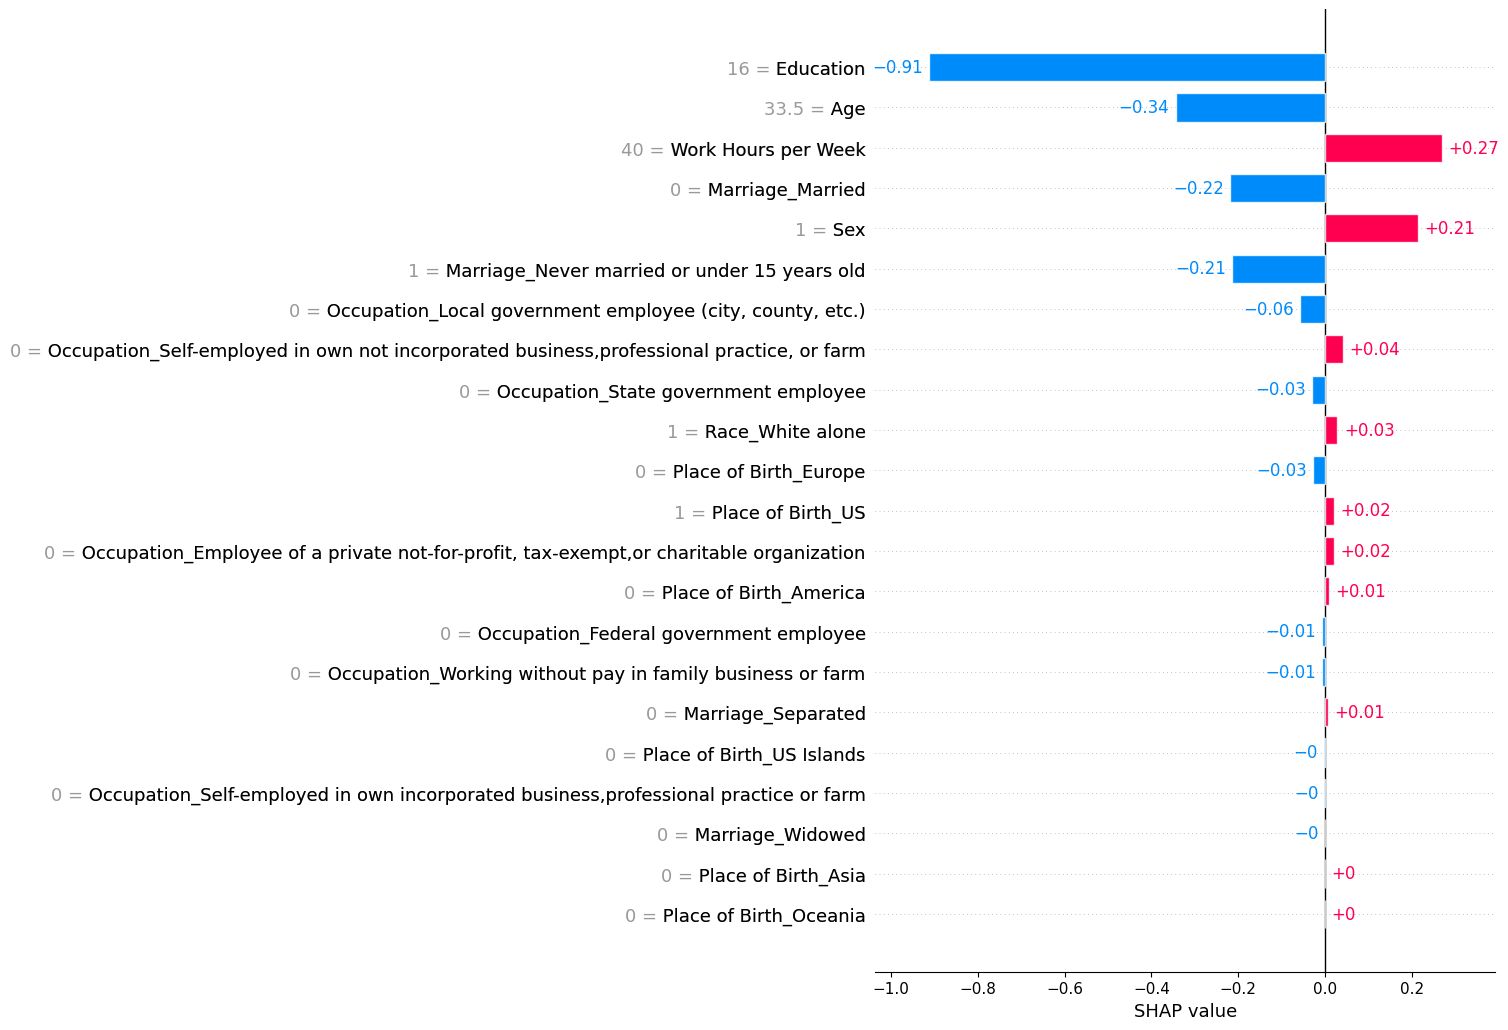

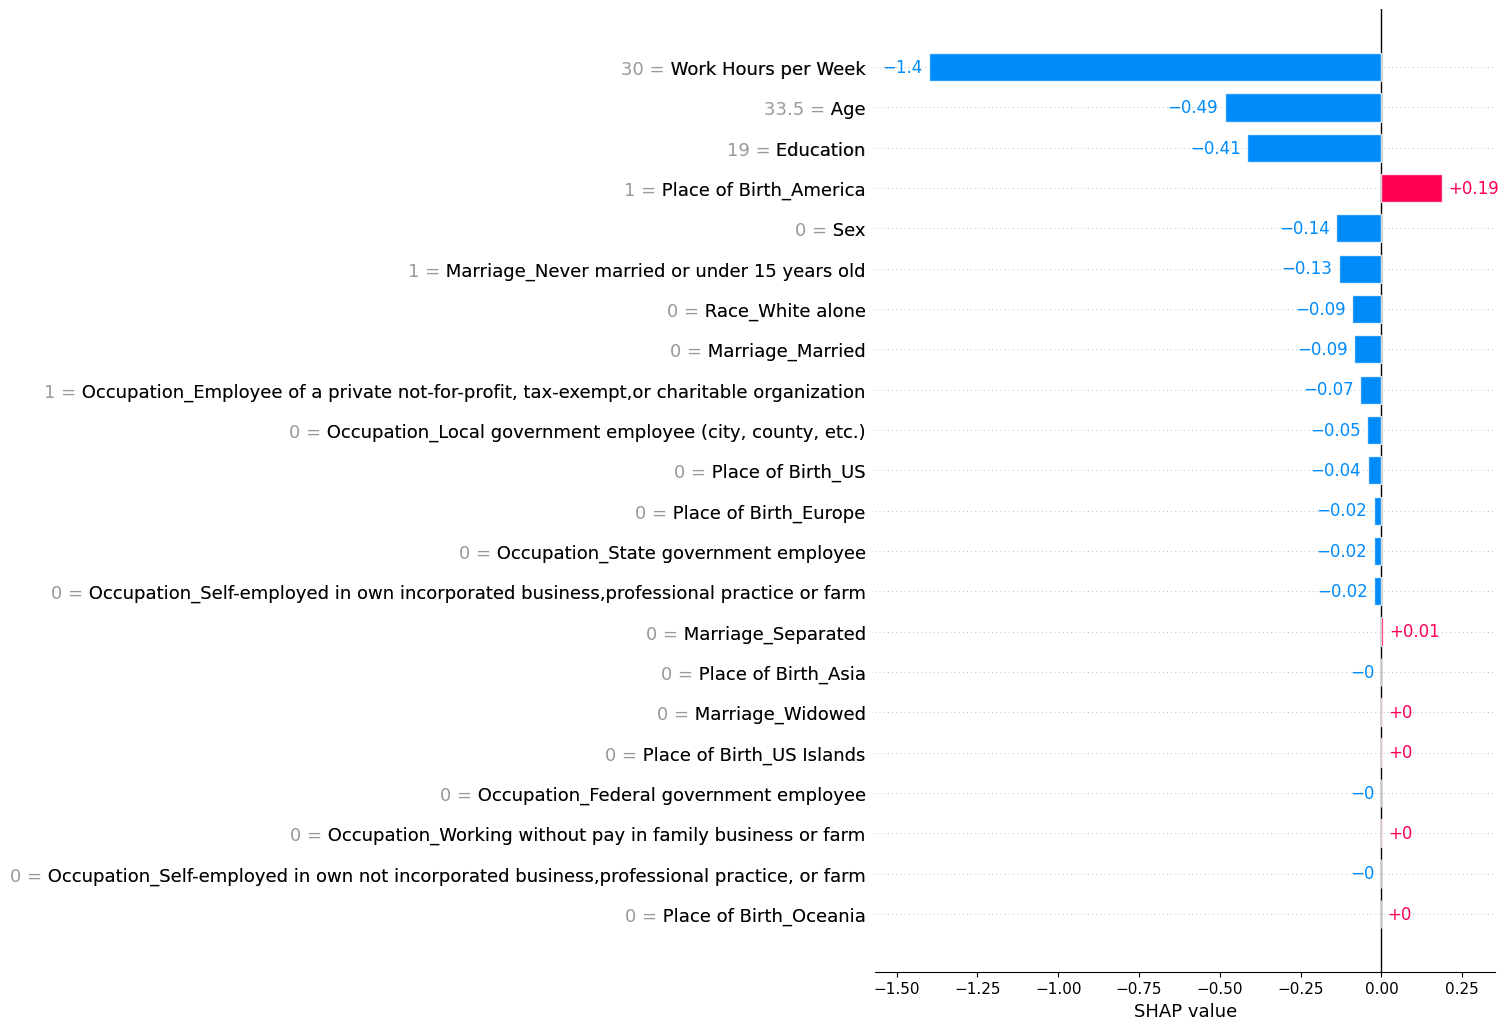

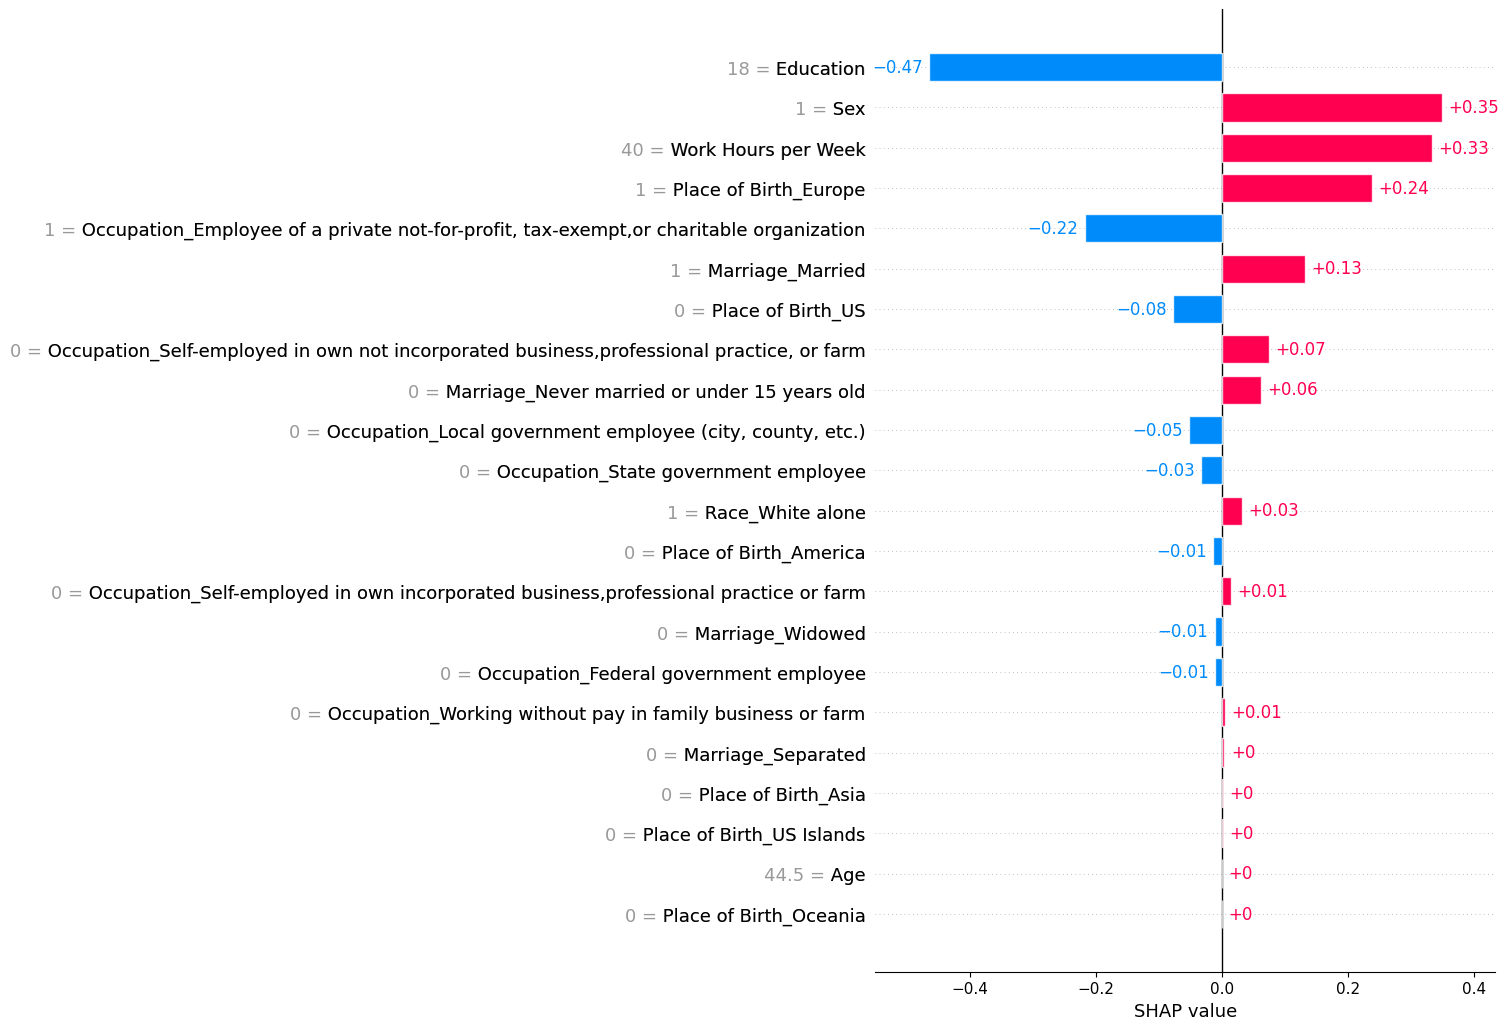

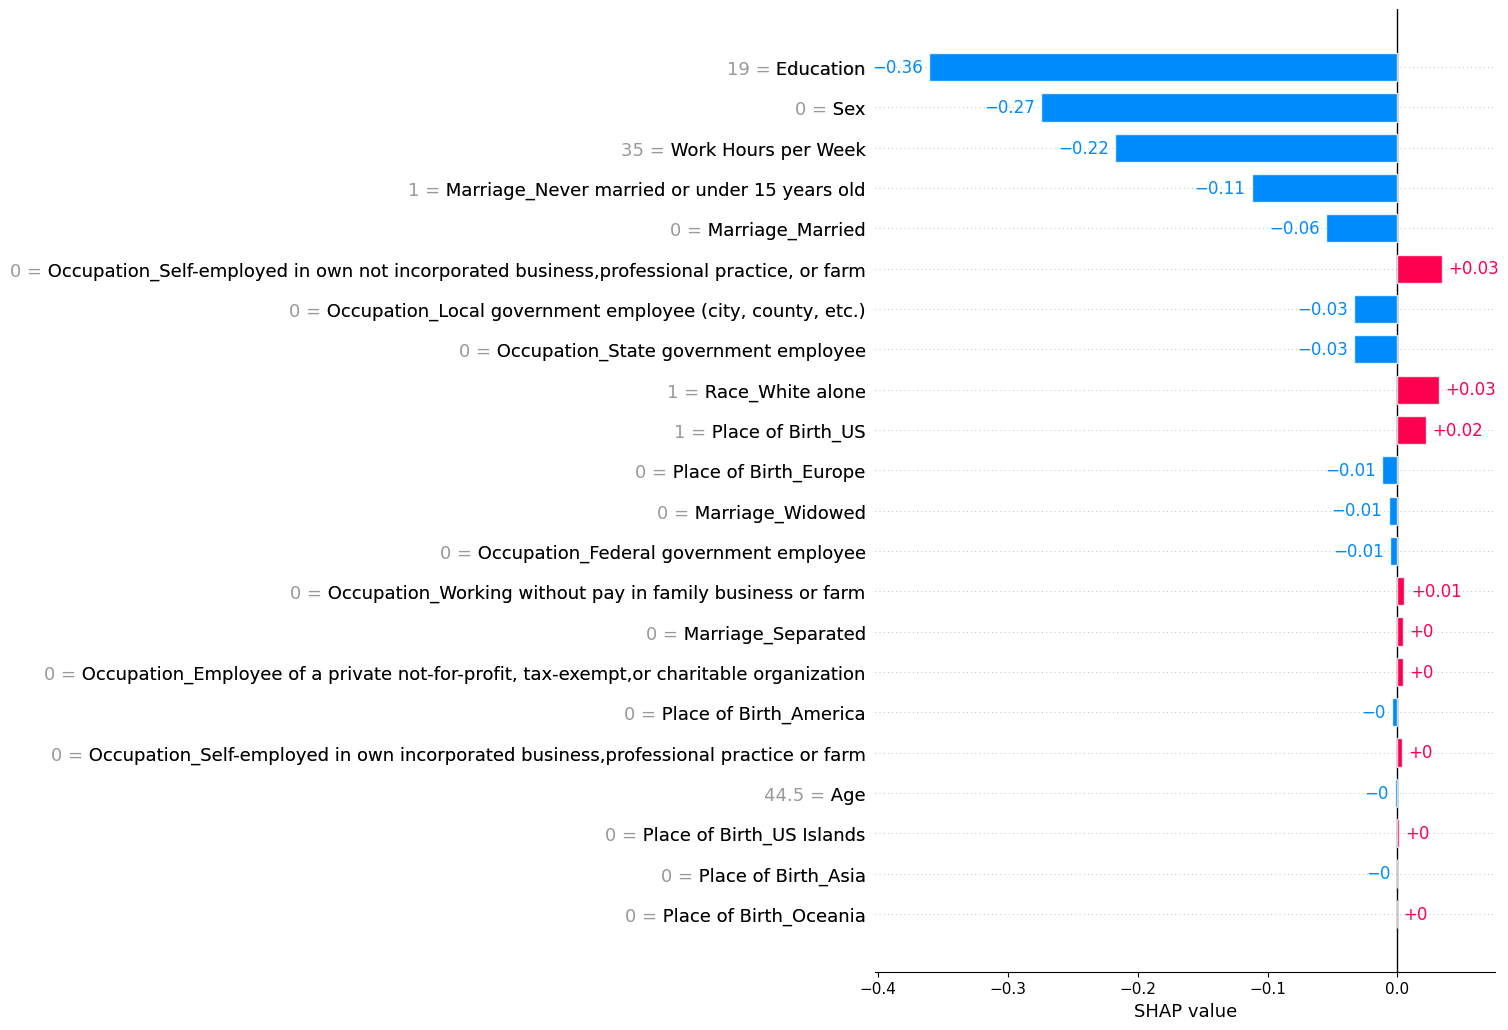

In [25]:
for i in cut5_top4_idx:
    shap.plots.bar(cut5_result['shap_vals'][0][i],max_display=22)

# cut 10

**********START**********


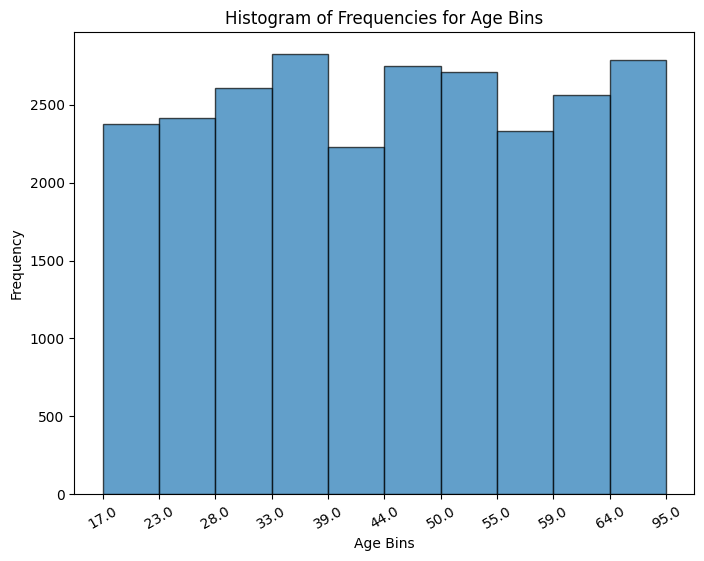

[17. 23. 28. 33. 39. 44. 50. 55. 59. 64. 95.]


In [26]:
cut10_bins = analyze_bins('quantile',10)
print(cut10_bins)

In [27]:
bin_edges = cut10_bins
X3 = X.copy()
X3['Age'] = X3['Age'].apply(assign_age)
cut10_result = train_test(X3,Y,base=False)

**********START**********
Overall average acc: 77.18 average f1s : 73.48


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.762274
1                                           Education            0.844490
2                                 Work Hours per Week            0.856858
3                                                 Sex            0.299587
4   Occupation_Employee of a private not-for-profi...            0.041359
5              Occupation_Federal government employee            0.015800
6   Occupation_Local government employee (city, co...            0.052036
7   Occupation_Self-employed in own incorporated b...            0.041343
8   Occupation_Self-employed in own not incorporat...            0.085253
9                Occupation_State government employee            0.046209
10  Occupation_Working without pay in family busin...            0.005351
11                                   Marriage_Married            0.102756
12       Marriage_Neve

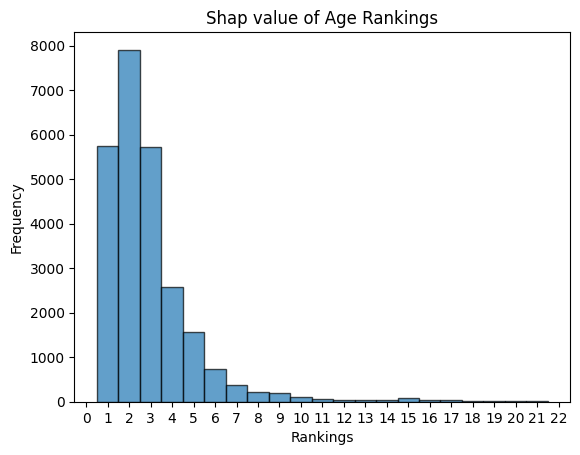

In [28]:
# cut10_shap_stats = analyze_shap(cut10_result['shap_vals'])
for sv in cut10_result['shap_vals']:
    sv = sv.values
    cut10_ranks = analyze_shap(sv)
    break

In [29]:
for i in range(FOLDS):
    preds = base_result['preds'][i]
    sv = cut10_result['shap_vals'][i].values
    base = cut10_result['shap_vals'][i].base_values
    break
cut10_fidelity,cut10_agreed = compute_fidelity(preds,sv,base)
print(f'fidelity {cut10_fidelity*100:.3f}')

fidelity 95.225


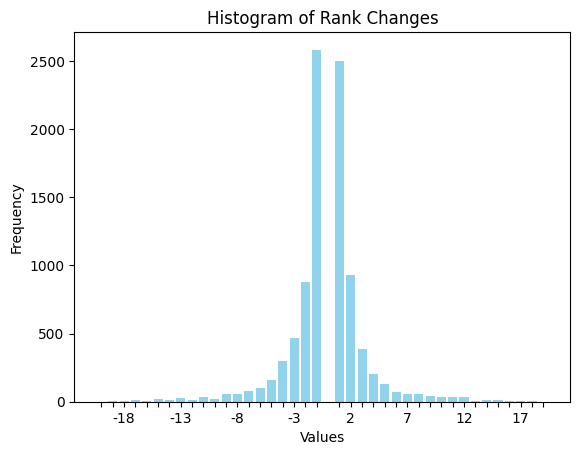

Average individual difference 0.221
abs Rank change by rank FULL 0.873
abs Rank change by rank 2.385
% of Rank difference 36.60 

kendal tau 0.8761320209315833


In [30]:
for i in range(FOLDS):
    s1 = base_result['shap_vals'][i]
    s2 = cut10_result['shap_vals'][i]
    cut10_top4_idx = compare_results(s1, s2, base_ranks, cut10_ranks ,cut10_agreed)
    break

## Cut 10 Errors

In [31]:
tps,fps,tns,fns = get_tfs(base_result['preds'], cut10_result['shap_vals'],Y_test)


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.455606
1                                           Education            0.921682
2                                 Work Hours per Week            0.631705
3                                                 Sex            0.313797
4   Occupation_Employee of a private not-for-profi...            0.042108
5              Occupation_Federal government employee            0.020508
6   Occupation_Local government employee (city, co...            0.068830
7   Occupation_Self-employed in own incorporated b...            0.047093
8   Occupation_Self-employed in own not incorporat...            0.087183
9                Occupation_State government employee            0.059593
10  Occupation_Working without pay in family busin...            0.004230
11                                   Marriage_Married            0.104439
12       Marriage_Neve

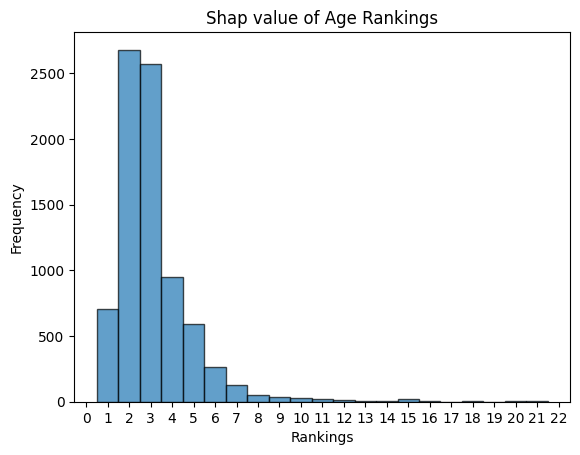

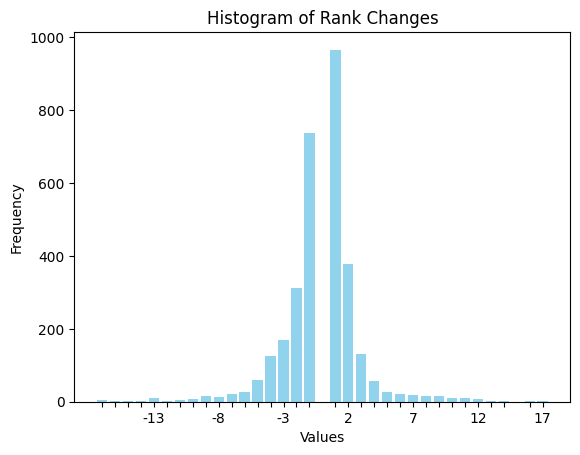

abs Rank change by rank FULL 0.865
abs Rank change by rank 2.204
% of Rank difference 39.26 

kendal tau 0.8821273505412459
fidelity 96.440


In [32]:
for i in range(FOLDS):
    sv = cut10_result['shap_vals'][i].values[tps,:]
    preds = base_result['preds'][i][tps]
    base =  cut10_result['shap_vals'][i].base_values[tps]
    fid,_ = compute_fidelity(preds,sv,base)
    cut10_tps_rank = analyze_shap(sv)
    
    compare_ranks(base_tps,cut10_tps_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.470563
1                                           Education            0.787506
2                                 Work Hours per Week            0.575449
3                                                 Sex            0.325169
4   Occupation_Employee of a private not-for-profi...            0.042587
5              Occupation_Federal government employee            0.023114
6   Occupation_Local government employee (city, co...            0.067747
7   Occupation_Self-employed in own incorporated b...            0.052325
8   Occupation_Self-employed in own not incorporat...            0.094532
9                Occupation_State government employee            0.056535
10  Occupation_Working without pay in family busin...            0.004873
11                                   Marriage_Married            0.107067
12       Marriage_Neve

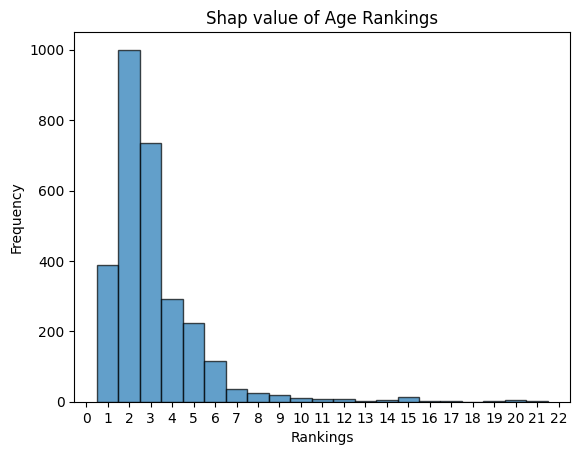

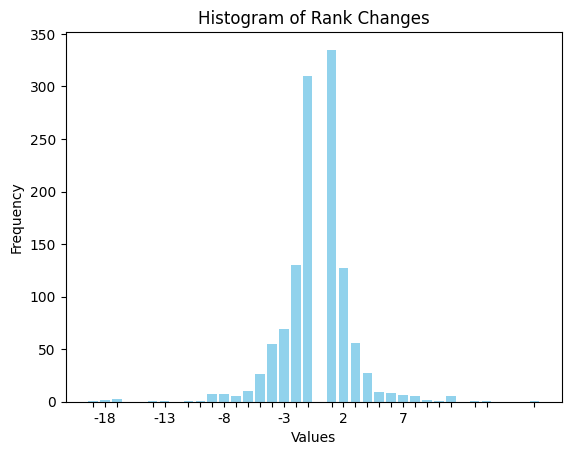

abs Rank change by rank FULL 0.920
abs Rank change by rank 2.195
% of Rank difference 41.90 

kendal tau 0.877860769052479
fidelity 90.881


In [33]:
for i in range(FOLDS):
    sv = cut10_result['shap_vals'][i].values[fps,:]
    preds = base_result['preds'][i][fps]
    base =  cut10_result['shap_vals'][i].base_values[fps]
    fid,_ = compute_fidelity(preds,sv,base)
    cut10_fps_rank = analyze_shap(sv)
    
    compare_ranks(base_fps,cut10_fps_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            1.103769
1                                           Education            0.829983
2                                 Work Hours per Week            1.138512
3                                                 Sex            0.277138
4   Occupation_Employee of a private not-for-profi...            0.040435
5              Occupation_Federal government employee            0.011042
6   Occupation_Local government employee (city, co...            0.038909
7   Occupation_Self-employed in own incorporated b...            0.036365
8   Occupation_Self-employed in own not incorporat...            0.075007
9                Occupation_State government employee            0.034862
10  Occupation_Working without pay in family busin...            0.005893
11                                   Marriage_Married            0.102755
12       Marriage_Neve

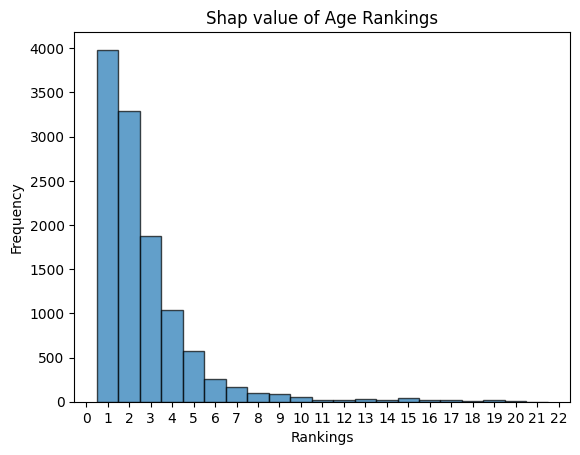

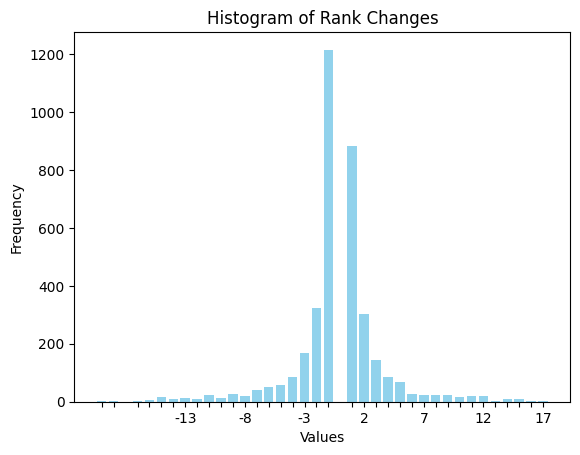

abs Rank change by rank FULL 0.814
abs Rank change by rank 2.537
% of Rank difference 32.07 

kendal tau 0.8728849947023971
fidelity 96.922


In [34]:
for i in range(FOLDS):
    sv = cut10_result['shap_vals'][i].values[tns,:]
    preds = base_result['preds'][i][tns]
    base =  cut10_result['shap_vals'][i].base_values[tns]
    fid,_ = compute_fidelity(preds,sv,base)
    cut10_tns_rank = analyze_shap(sv)
    
    compare_ranks(base_tns,cut10_tns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.538708
1                                           Education            0.745941
2                                 Work Hours per Week            0.636300
3                                                 Sex            0.324330
4   Occupation_Employee of a private not-for-profi...            0.041757
5              Occupation_Federal government employee            0.014522
6   Occupation_Local government employee (city, co...            0.042456
7   Occupation_Self-employed in own incorporated b...            0.034475
8   Occupation_Self-employed in own not incorporat...            0.111413
9                Occupation_State government employee            0.044241
10  Occupation_Working without pay in family busin...            0.006756
11                                   Marriage_Married            0.093898
12       Marriage_Neve

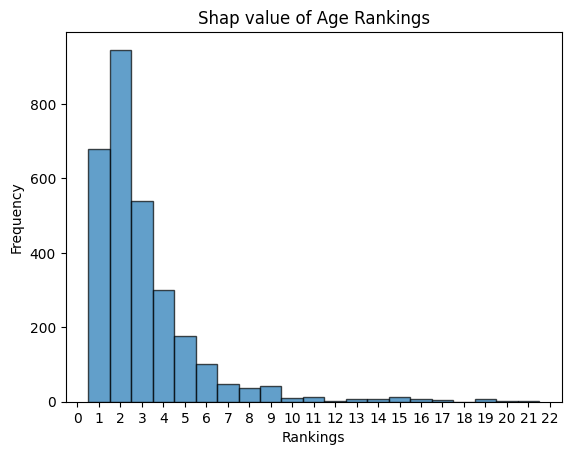

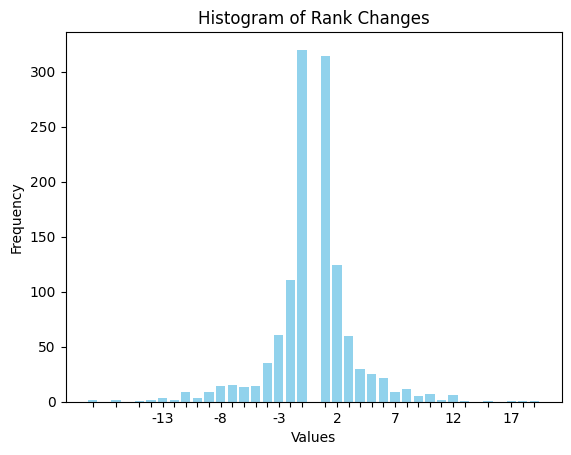

abs Rank change by rank FULL 1.082
abs Rank change by rank 2.576
% of Rank difference 42.00 

kendal tau 0.8708266266840121
fidelity 89.440


In [35]:
for i in range(FOLDS):
    sv = cut10_result['shap_vals'][i].values[fns,:]
    preds = base_result['preds'][i][fns]
    base =  cut10_result['shap_vals'][i].base_values[fns]
    fid,_ = compute_fidelity(preds,sv,base)
    cut10_fns_rank = analyze_shap(sv)
    
    compare_ranks(base_fns,cut10_fns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

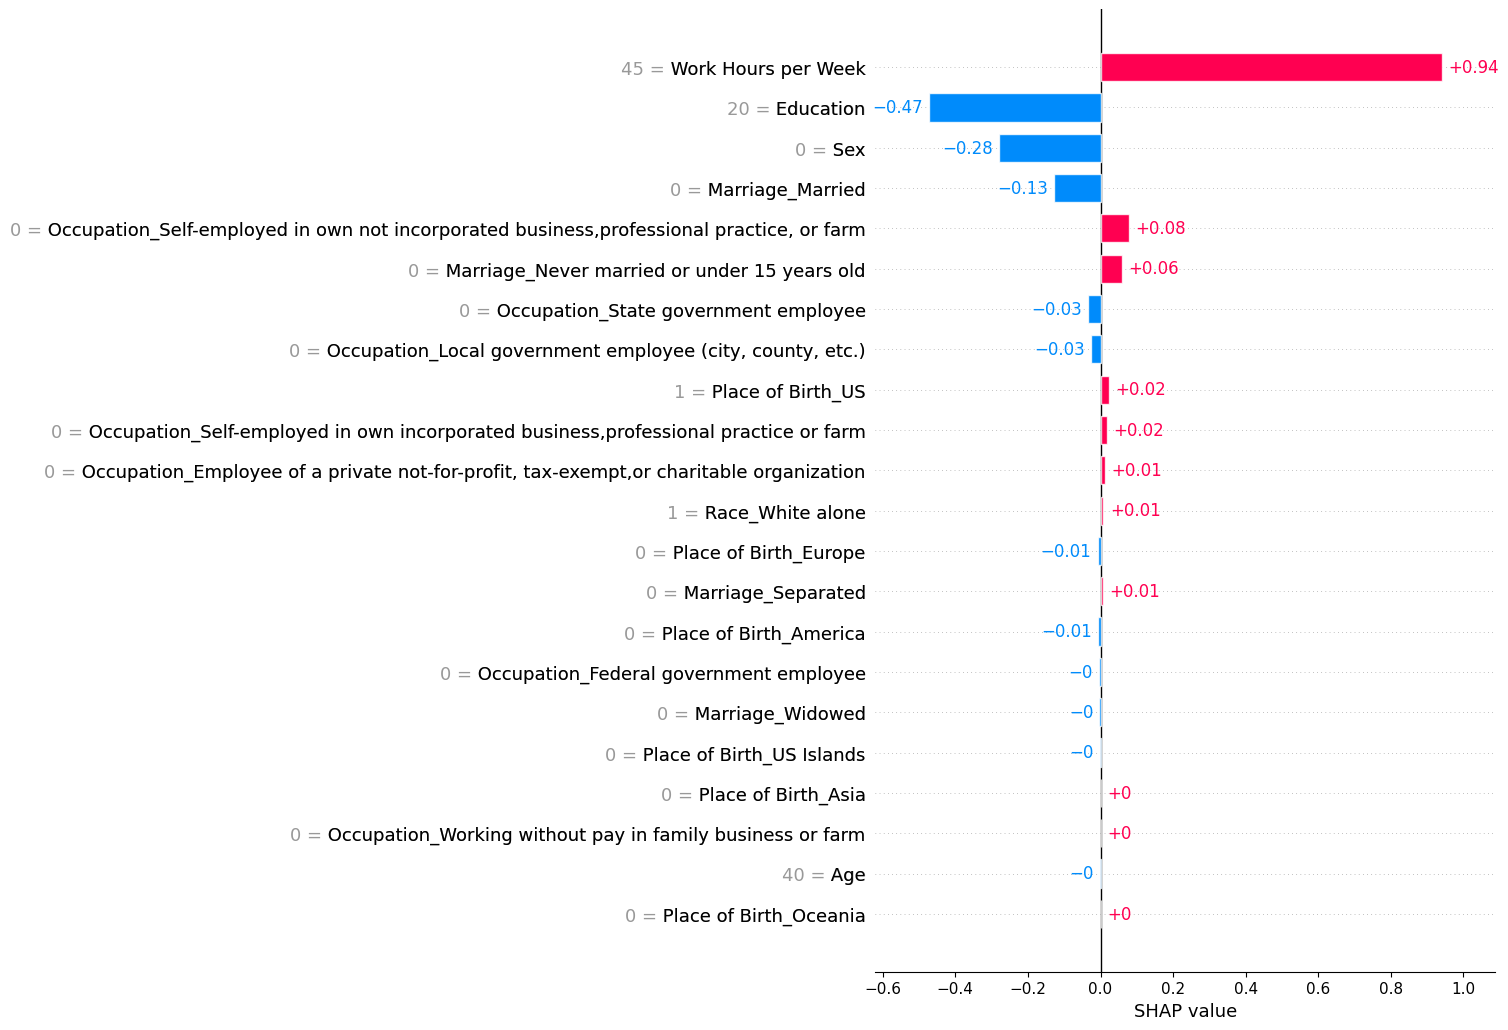

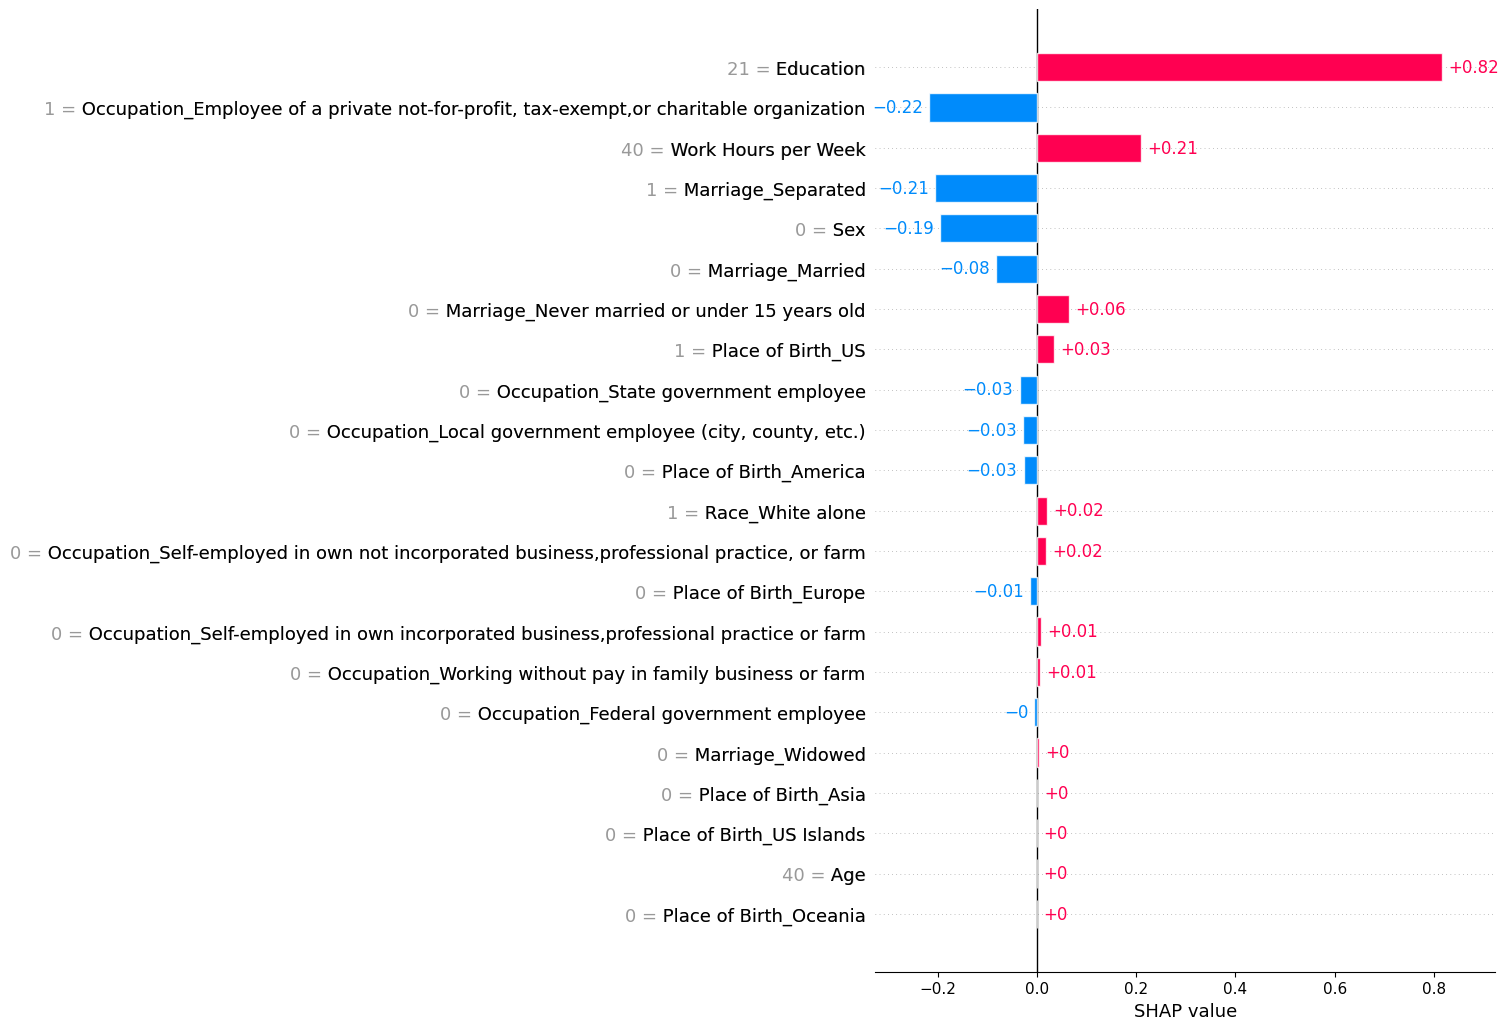

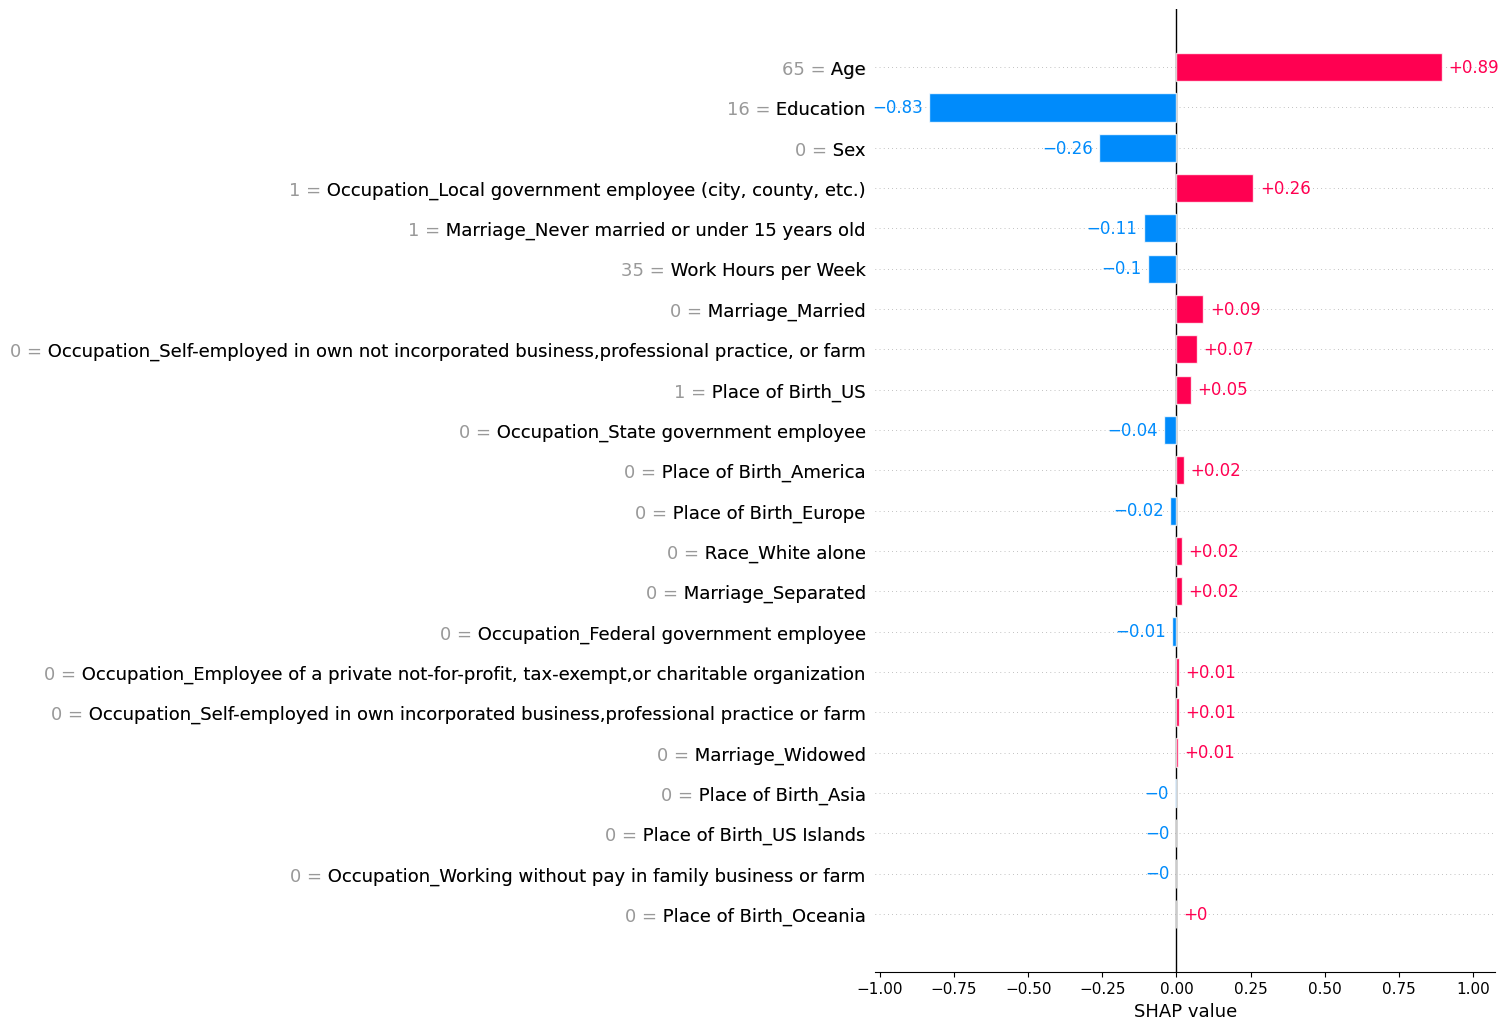

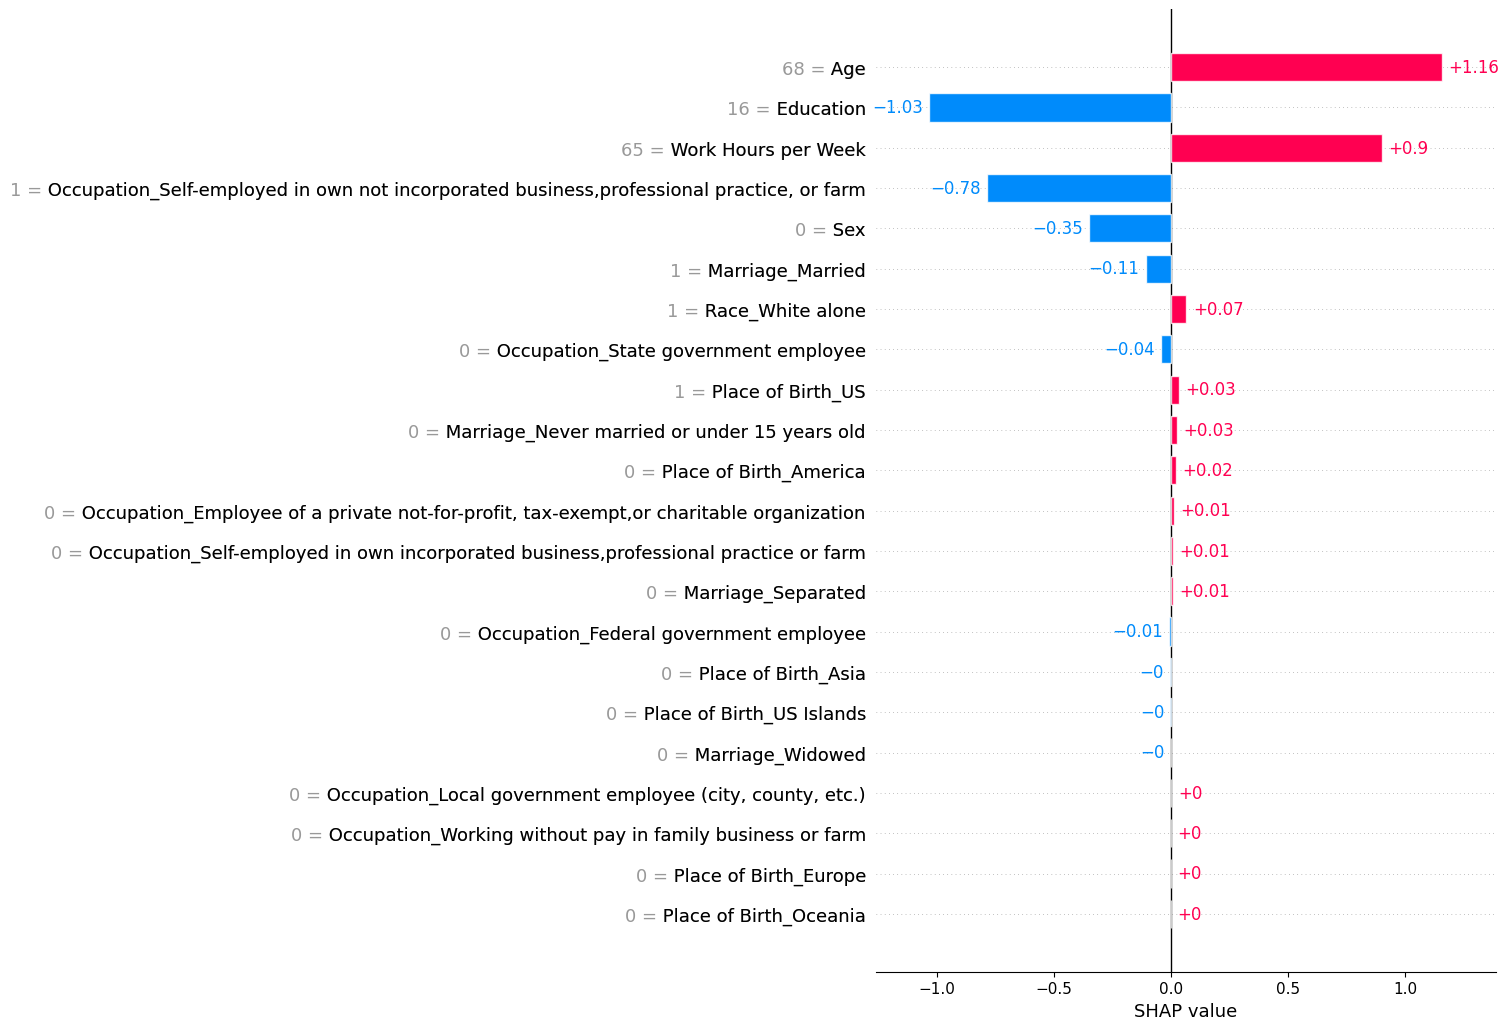

In [36]:
for i in cut10_top4_idx:
    shap.plots.bar(base_result['shap_vals'][0][i],max_display = 22)

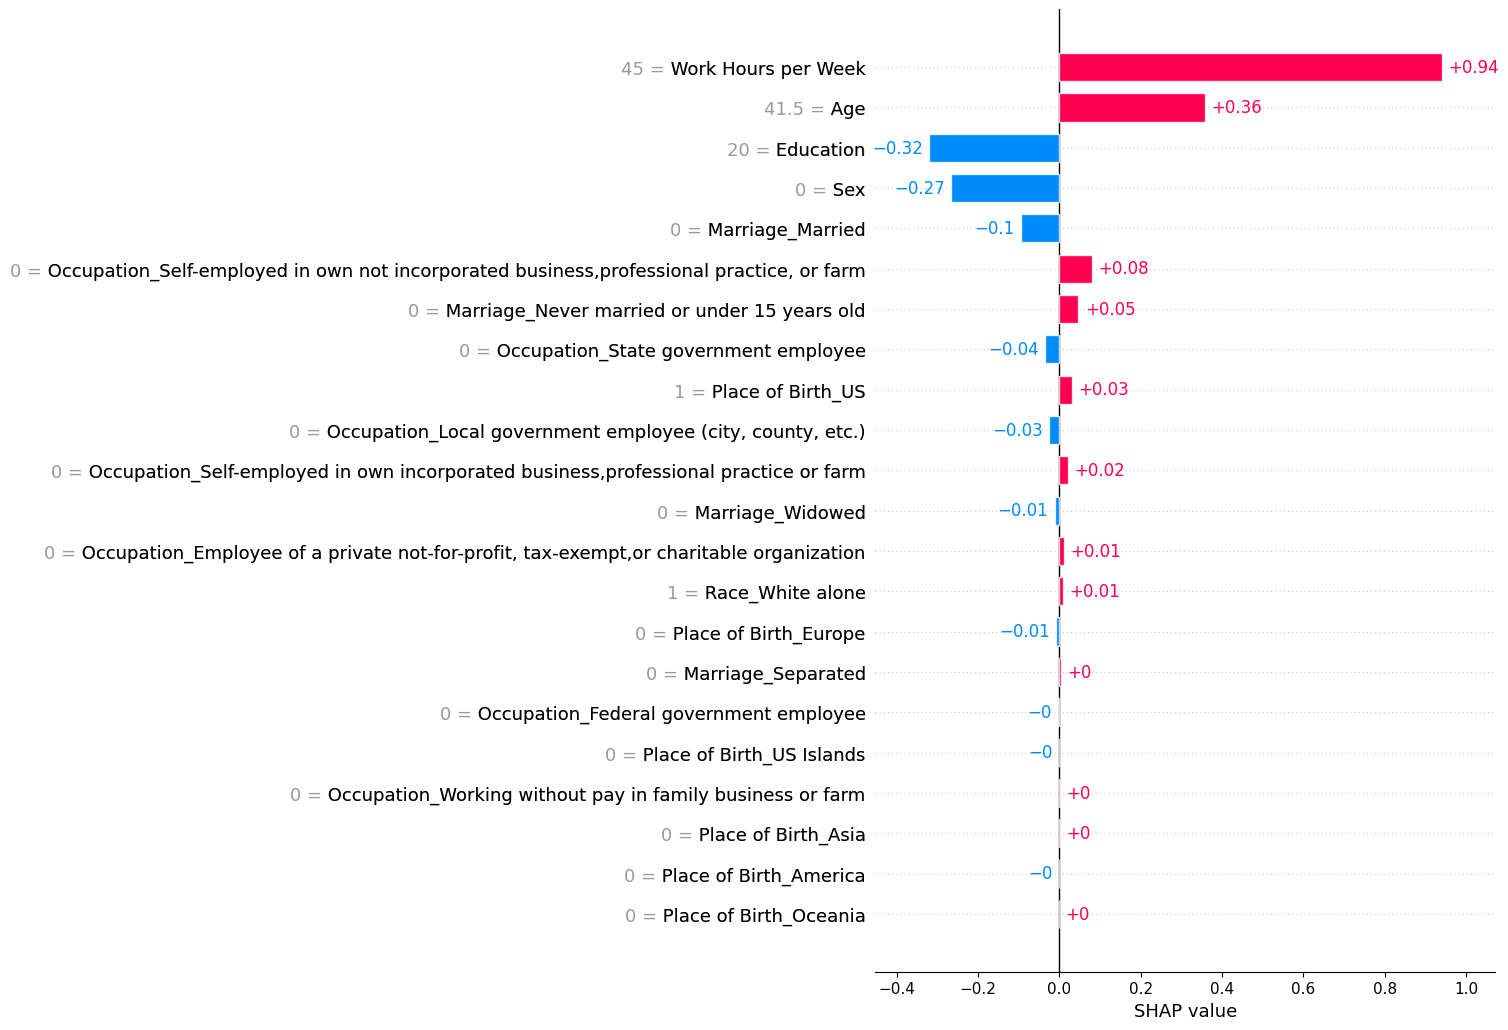

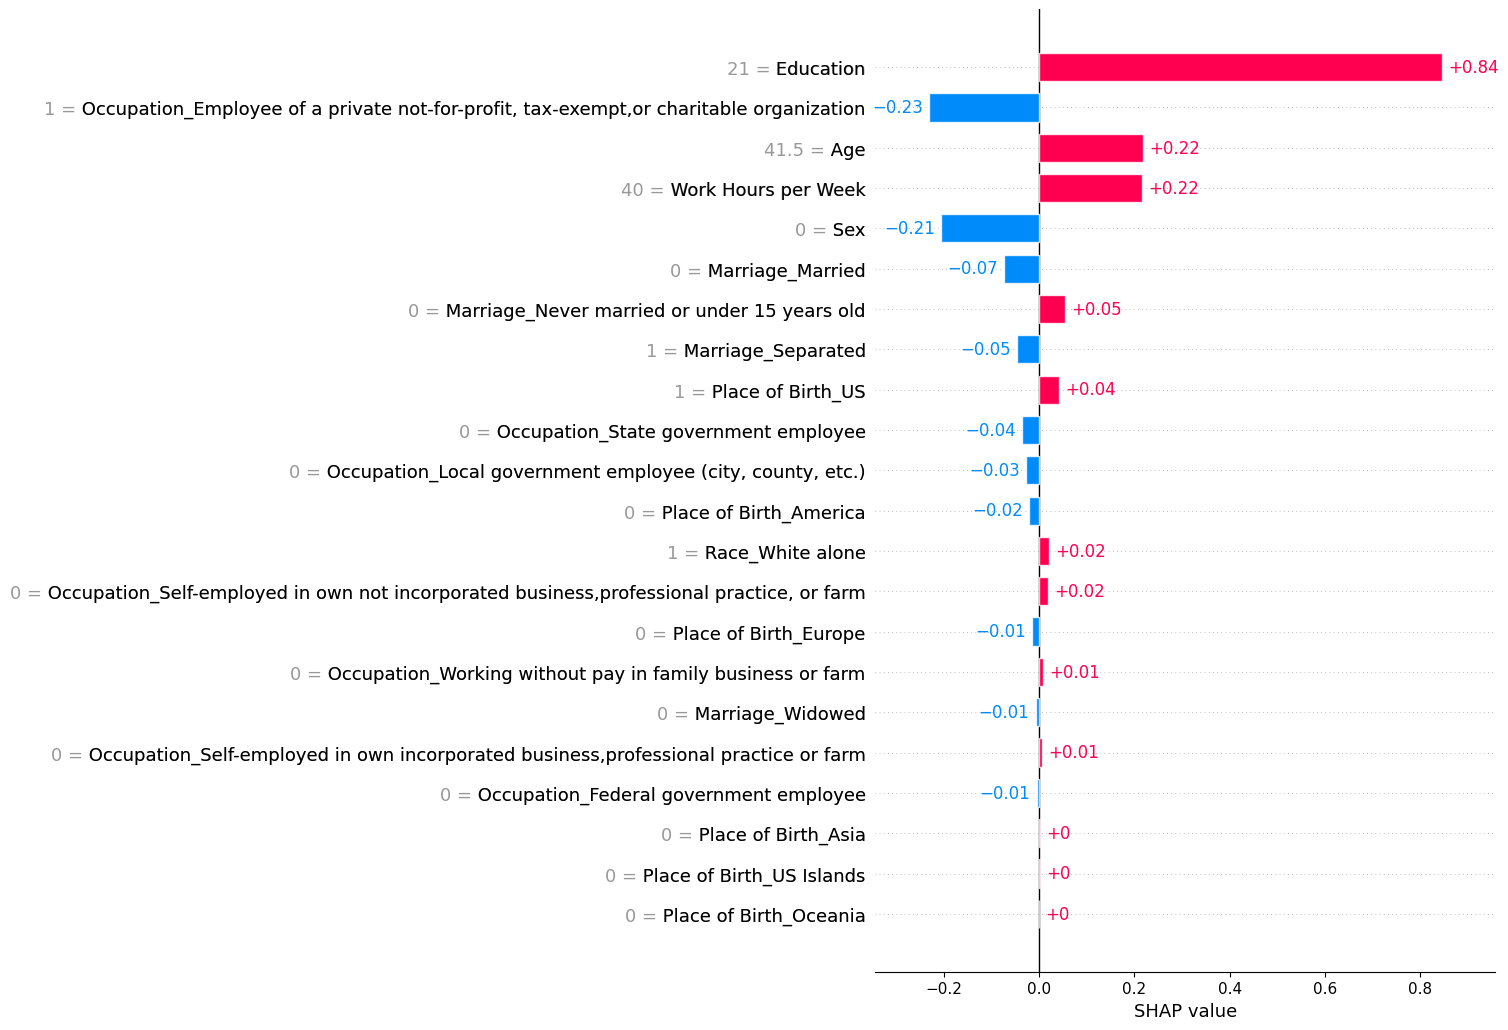

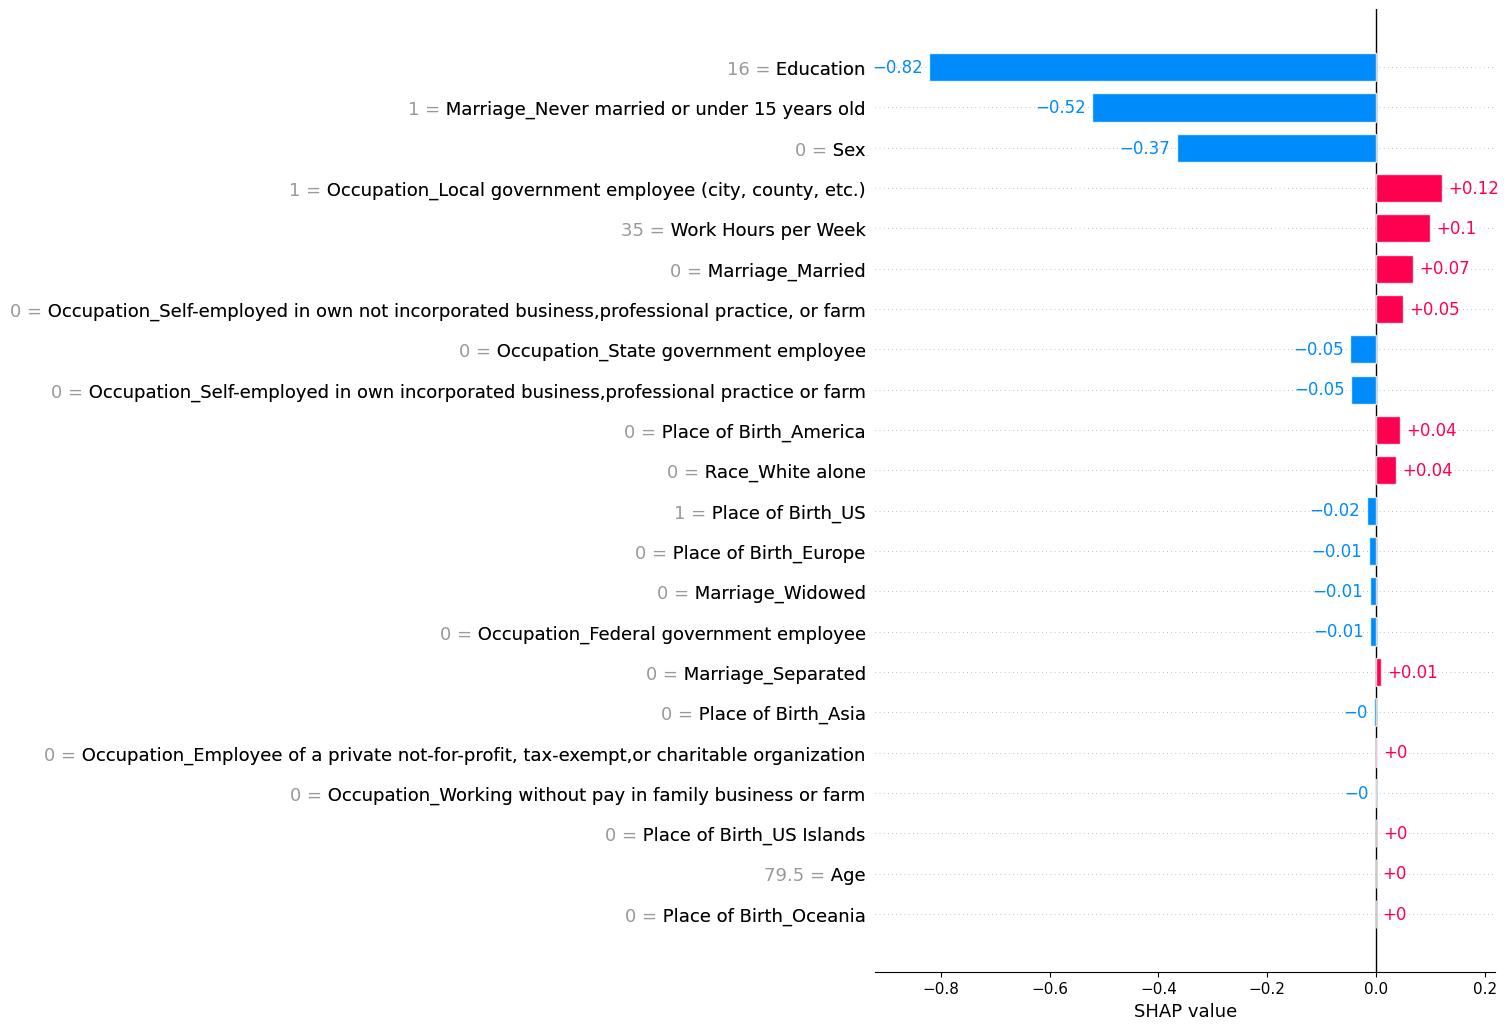

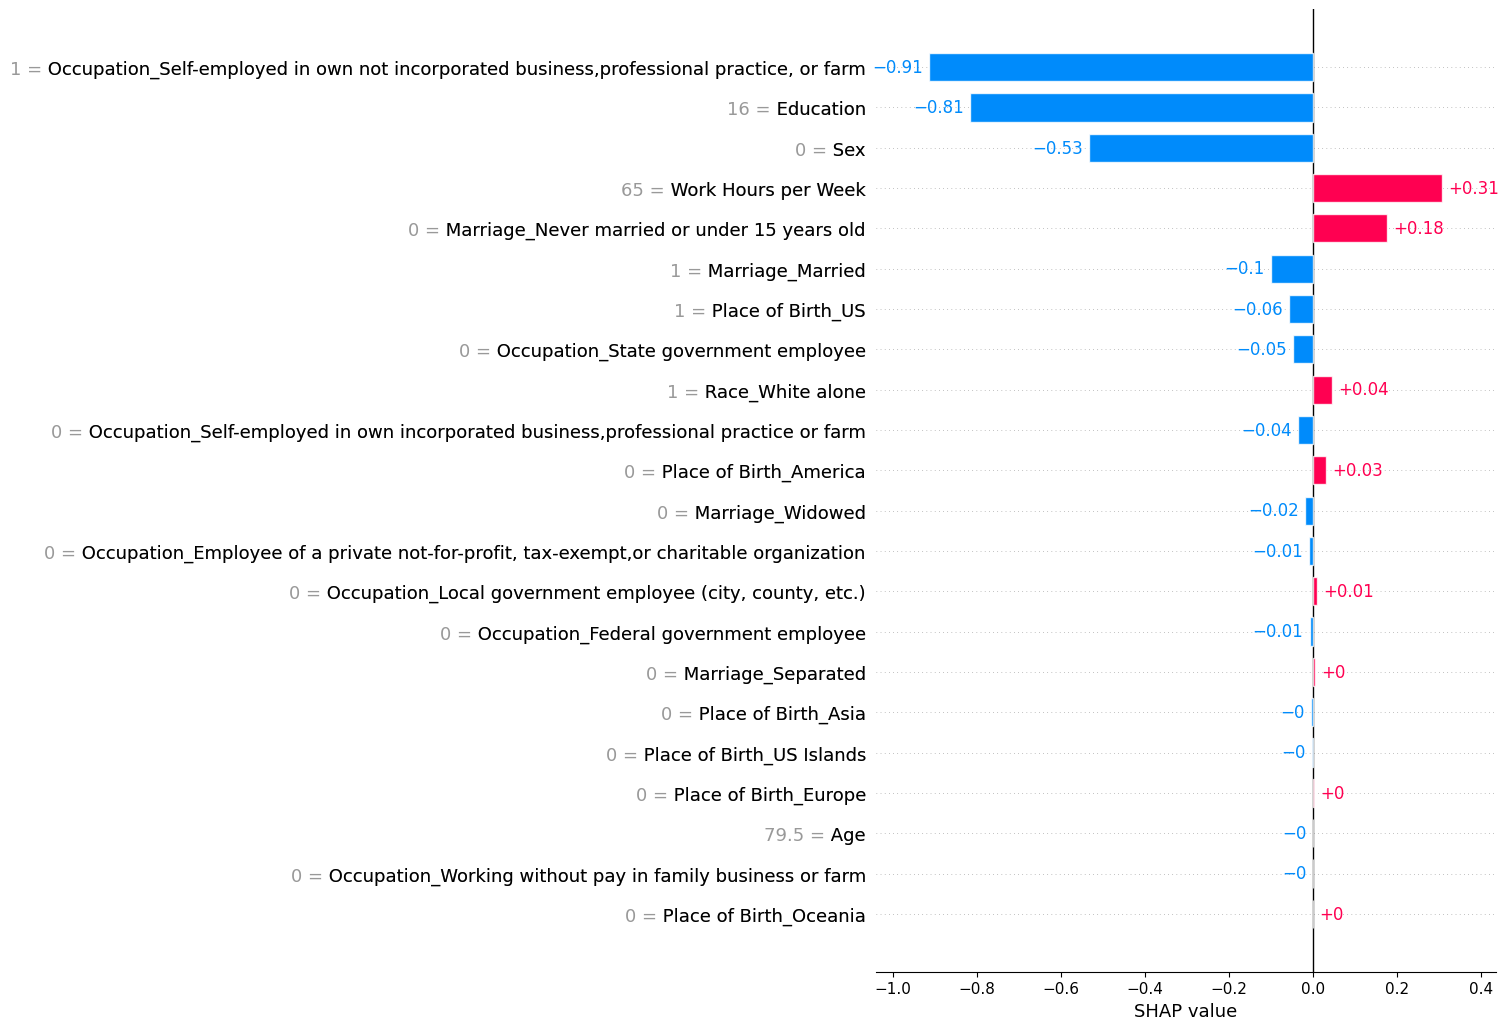

In [37]:
for i in cut10_top4_idx:
    shap.plots.bar(cut10_result['shap_vals'][0][i],max_display = 22)

# qcut 5

**********START**********


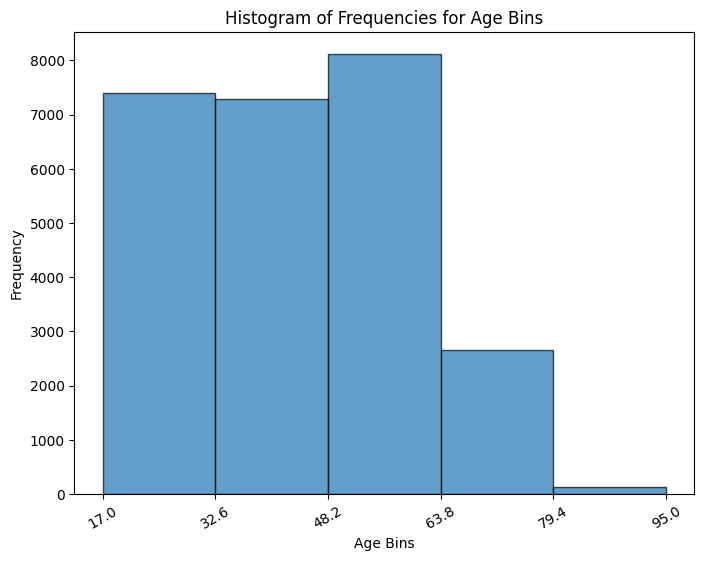

In [38]:
qcut5_bins = analyze_bins('uniform',5)

In [39]:
bin_edges = qcut5_bins
X4 = X.copy()
X4['Age'] = X4['Age'].apply(assign_age)
qcut5_result = train_test(X4,Y,base=False)

**********START**********
Overall average acc: 77.18 average f1s : 73.48


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.826758
1                                           Education            0.867403
2                                 Work Hours per Week            0.897891
3                                                 Sex            0.288911
4   Occupation_Employee of a private not-for-profi...            0.042242
5              Occupation_Federal government employee            0.013573
6   Occupation_Local government employee (city, co...            0.067815
7   Occupation_Self-employed in own incorporated b...            0.026515
8   Occupation_Self-employed in own not incorporat...            0.085192
9                Occupation_State government employee            0.040011
10  Occupation_Working without pay in family busin...            0.007172
11                                   Marriage_Married            0.105291
12       Marriage_Neve

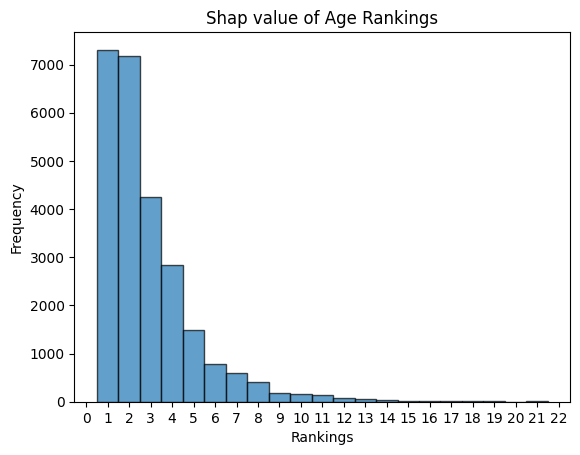

In [40]:
for sv in qcut5_result['shap_vals']:
    sv = sv.values
    qcut5_ranks = analyze_shap(sv)
    break

In [41]:
for i in range(FOLDS):
    preds = base_result['preds'][i]
    sv = qcut5_result['shap_vals'][i].values
    base = qcut5_result['shap_vals'][i].base_values
    break
qcut5_fidelity,qcut5_agreed = compute_fidelity(preds,sv,base)
print(f'fidelity {qcut5_fidelity*100:.3f}')

fidelity 93.608


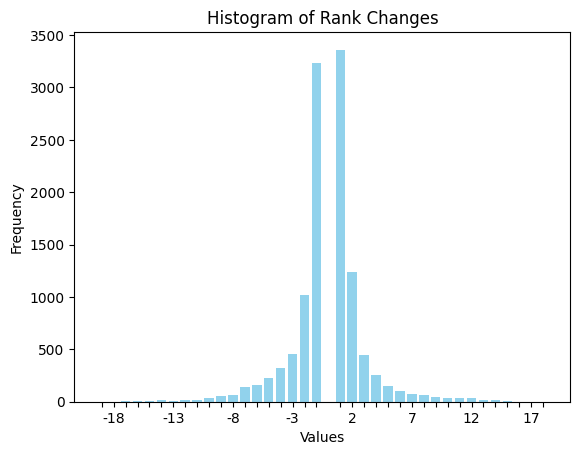

Average individual difference 0.403
abs Rank change by rank FULL 1.013
abs Rank change by rank 2.227
% of Rank difference 45.48 

kendal tau 0.8362484849161415


In [42]:
for i in range(FOLDS):
    s1 = base_result['shap_vals'][i]
    s2 = qcut5_result['shap_vals'][i]
    qcut5_top4_idx = compare_results(s1, s2, base_ranks, qcut5_ranks ,qcut5_agreed)
    break

## qcut5 Errors

In [43]:
tps,fps,tns,fns = get_tfs(base_result['preds'], qcut5_result['shap_vals'],Y_test)

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.579623
1                                           Education            0.971473
2                                 Work Hours per Week            0.663736
3                                                 Sex            0.298913
4   Occupation_Employee of a private not-for-profi...            0.048442
5              Occupation_Federal government employee            0.018536
6   Occupation_Local government employee (city, co...            0.093094
7   Occupation_Self-employed in own incorporated b...            0.028974
8   Occupation_Self-employed in own not incorporat...            0.087981
9                Occupation_State government employee            0.056292
10  Occupation_Working without pay in family busin...            0.007080
11                                   Marriage_Married            0.105538
12       Marriage_Neve

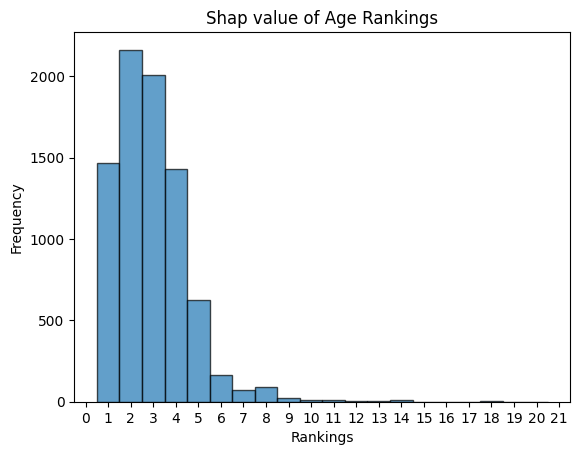

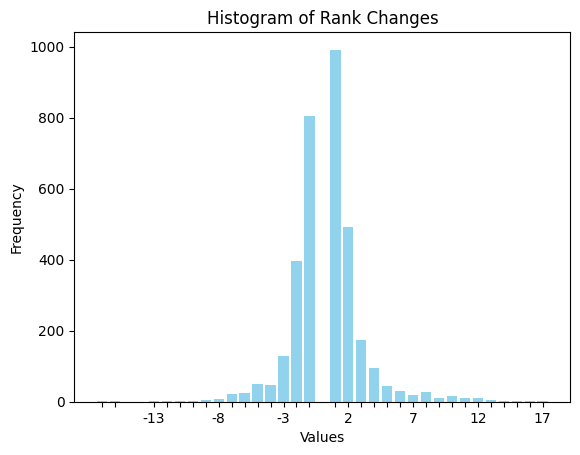

abs Rank change by rank FULL 0.891
abs Rank change by rank 2.105
% of Rank difference 42.32 

kendal tau 0.8606220087243698
fidelity 91.322


In [44]:
for i in range(FOLDS):
    sv = qcut5_result['shap_vals'][i].values[tps,:]
    preds = base_result['preds'][i][tps]
    base =  qcut5_result['shap_vals'][i].base_values[tps]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut5_tps_rank = analyze_shap(sv)
    
    compare_ranks(base_tps,qcut5_tps_rank)
    print(f'fidelity {fid*100:.3f}')
    break


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.640681
1                                           Education            0.828836
2                                 Work Hours per Week            0.606024
3                                                 Sex            0.304891
4   Occupation_Employee of a private not-for-profi...            0.046991
5              Occupation_Federal government employee            0.019654
6   Occupation_Local government employee (city, co...            0.087922
7   Occupation_Self-employed in own incorporated b...            0.027914
8   Occupation_Self-employed in own not incorporat...            0.093778
9                Occupation_State government employee            0.051821
10  Occupation_Working without pay in family busin...            0.007674
11                                   Marriage_Married            0.108502
12       Marriage_Neve

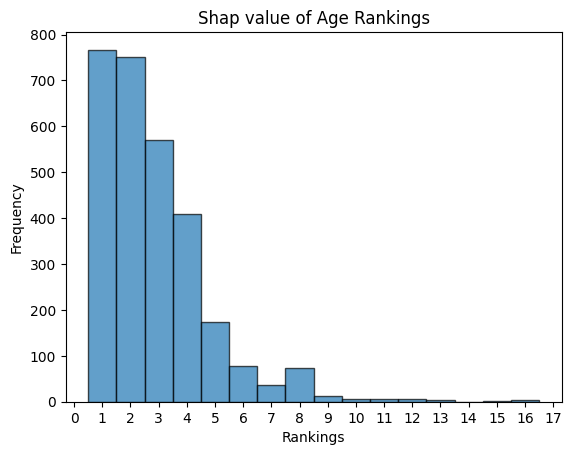

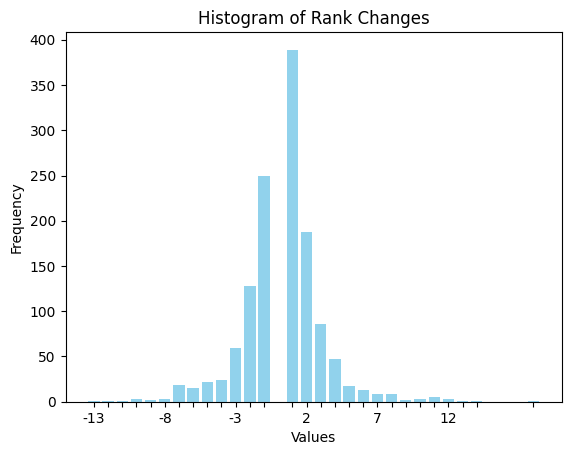

abs Rank change by rank FULL 1.003
abs Rank change by rank 2.235
% of Rank difference 44.91 

kendal tau 0.8550478882085099
fidelity 83.074


In [45]:
for i in range(FOLDS):
    sv = qcut5_result['shap_vals'][i].values[fps,:]
    preds = base_result['preds'][i][fps]
    base =  qcut5_result['shap_vals'][i].base_values[fps]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut5_fps_rank = analyze_shap(sv)
    
    compare_ranks(base_fps,qcut5_fps_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            1.061594
1                                           Education            0.826323
2                                 Work Hours per Week            1.189383
3                                                 Sex            0.274448
4   Occupation_Employee of a private not-for-profi...            0.037049
5              Occupation_Federal government employee            0.009360
6   Occupation_Local government employee (city, co...            0.048587
7   Occupation_Self-employed in own incorporated b...            0.026572
8   Occupation_Self-employed in own not incorporat...            0.074792
9                Occupation_State government employee            0.027007
10  Occupation_Working without pay in family busin...            0.006687
11                                   Marriage_Married            0.106021
12       Marriage_Neve

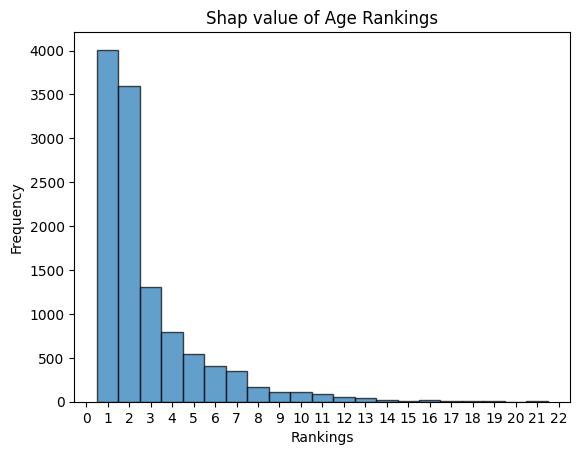

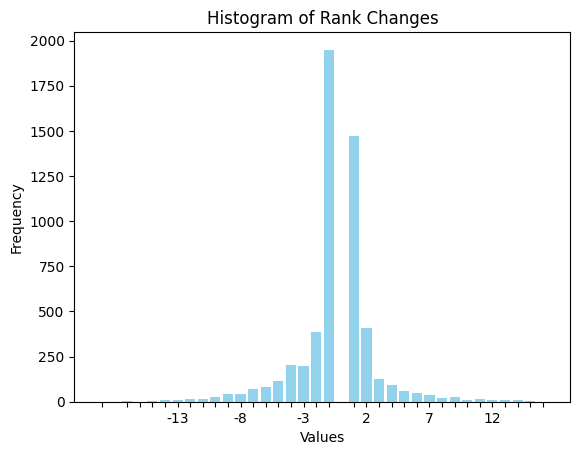

abs Rank change by rank FULL 1.052
abs Rank change by rank 2.230
% of Rank difference 47.20 

kendal tau 0.815419271398697
fidelity 97.900


In [46]:
for i in range(FOLDS):
    sv = qcut5_result['shap_vals'][i].values[tns,:]
    preds = base_result['preds'][i][tns]
    base =  qcut5_result['shap_vals'][i].base_values[tns]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut5_tns_rank = analyze_shap(sv)
    
    compare_ranks(base_tns,qcut5_tns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.758305
1                                           Education            0.782187
2                                 Work Hours per Week            0.673370
3                                                 Sex            0.303021
4   Occupation_Employee of a private not-for-profi...            0.041118
5              Occupation_Federal government employee            0.010651
6   Occupation_Local government employee (city, co...            0.054778
7   Occupation_Self-employed in own incorporated b...            0.018162
8   Occupation_Self-employed in own not incorporat...            0.110288
9                Occupation_State government employee            0.035186
10  Occupation_Working without pay in family busin...            0.008856
11                                   Marriage_Married            0.098567
12       Marriage_Neve

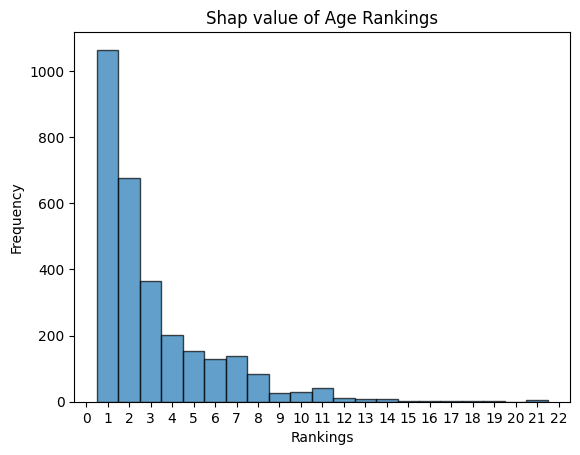

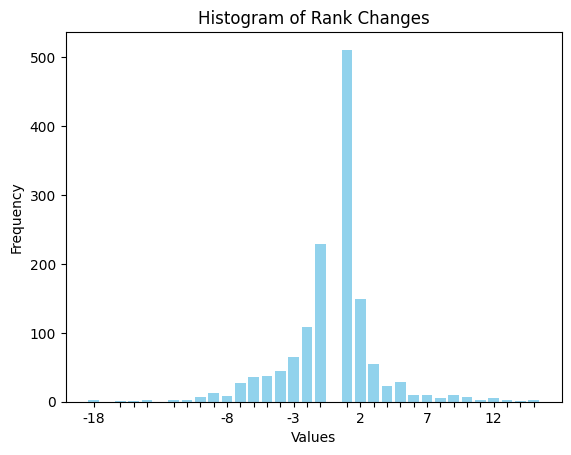

abs Rank change by rank FULL 1.200
abs Rank change by rank 2.506
% of Rank difference 47.88 

kendal tau 0.8333252486053844
fidelity 93.243


In [47]:
for i in range(FOLDS):
    sv = qcut5_result['shap_vals'][i].values[fns,:]
    preds = base_result['preds'][i][fns]
    base =  qcut5_result['shap_vals'][i].base_values[fns]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut5_fns_rank = analyze_shap(sv)
    
    compare_ranks(base_fns,qcut5_fns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

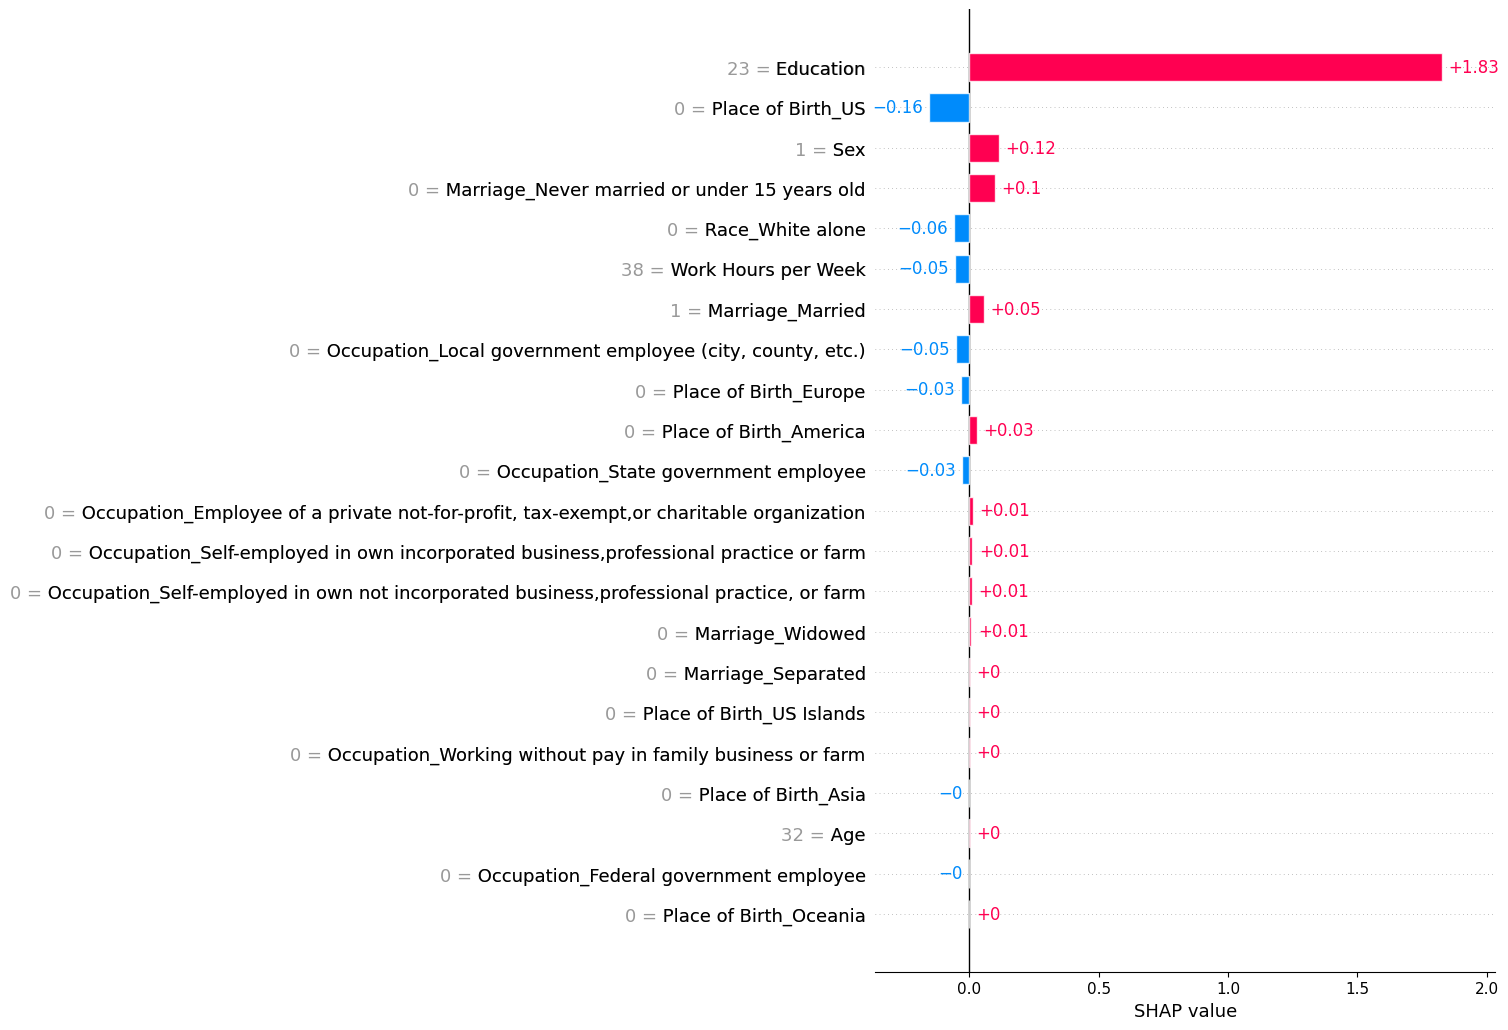

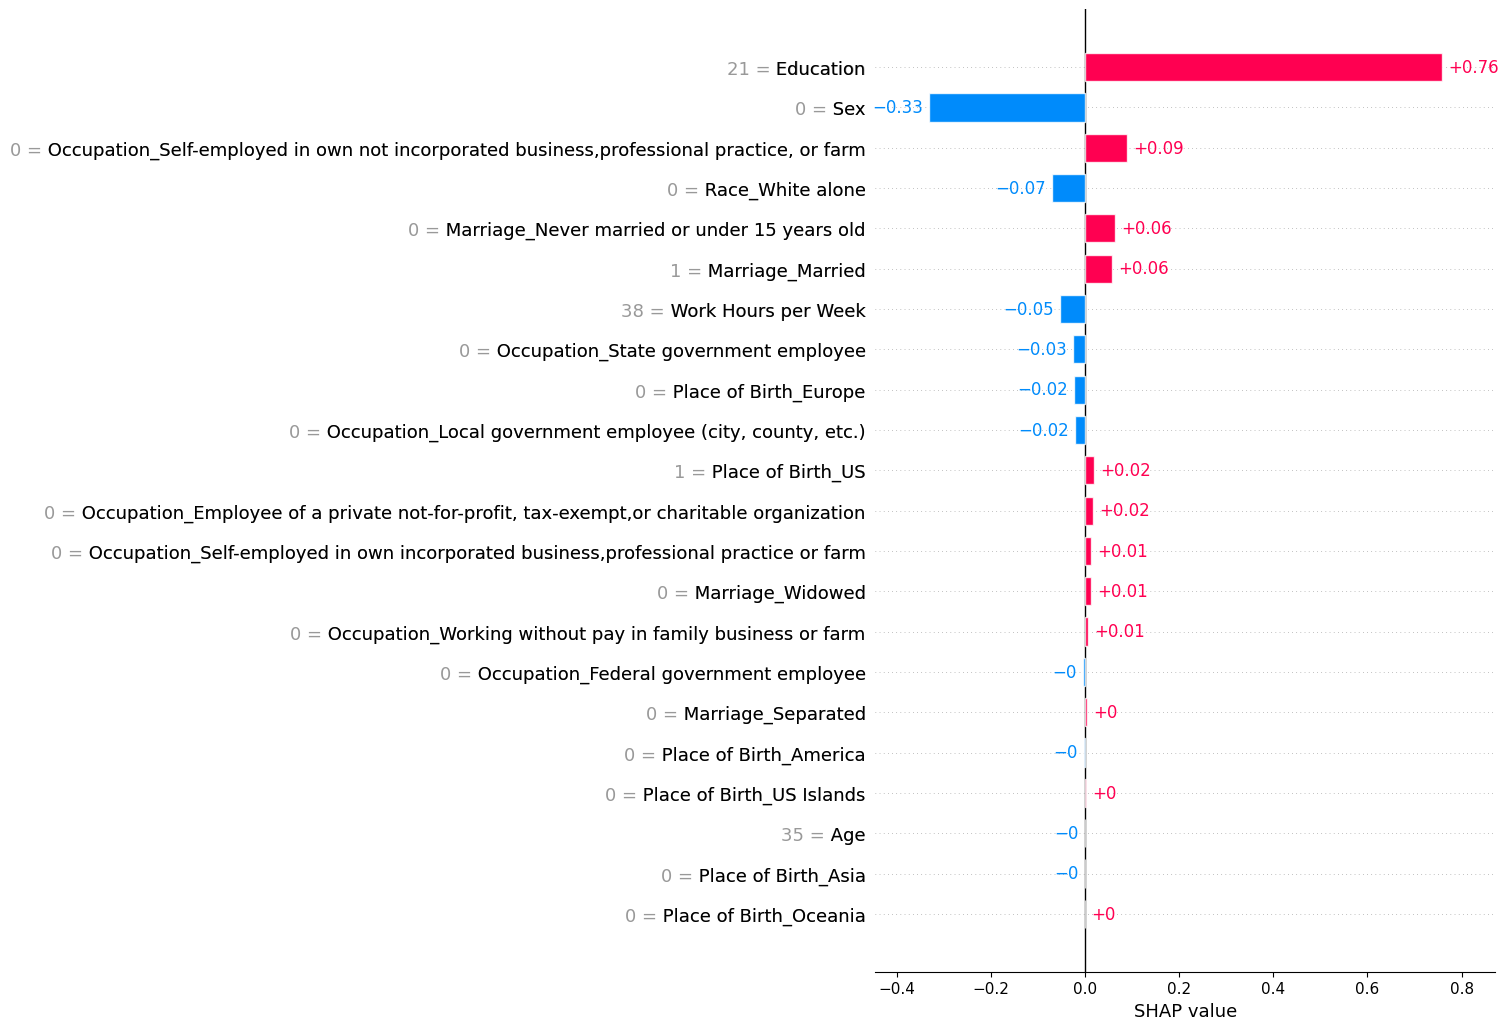

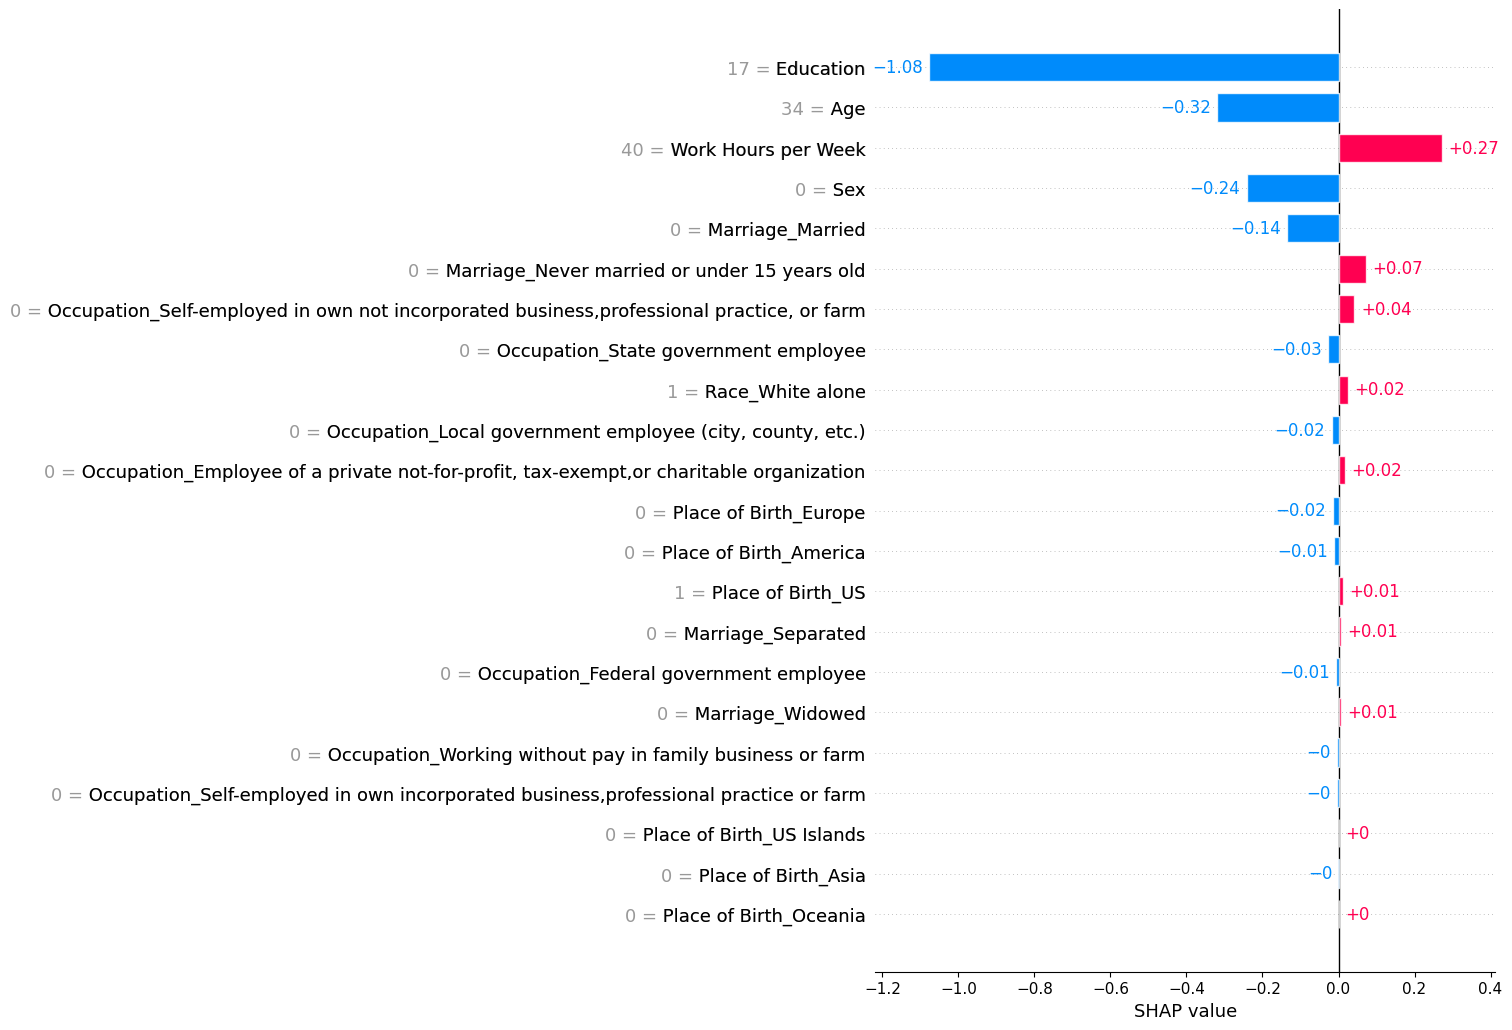

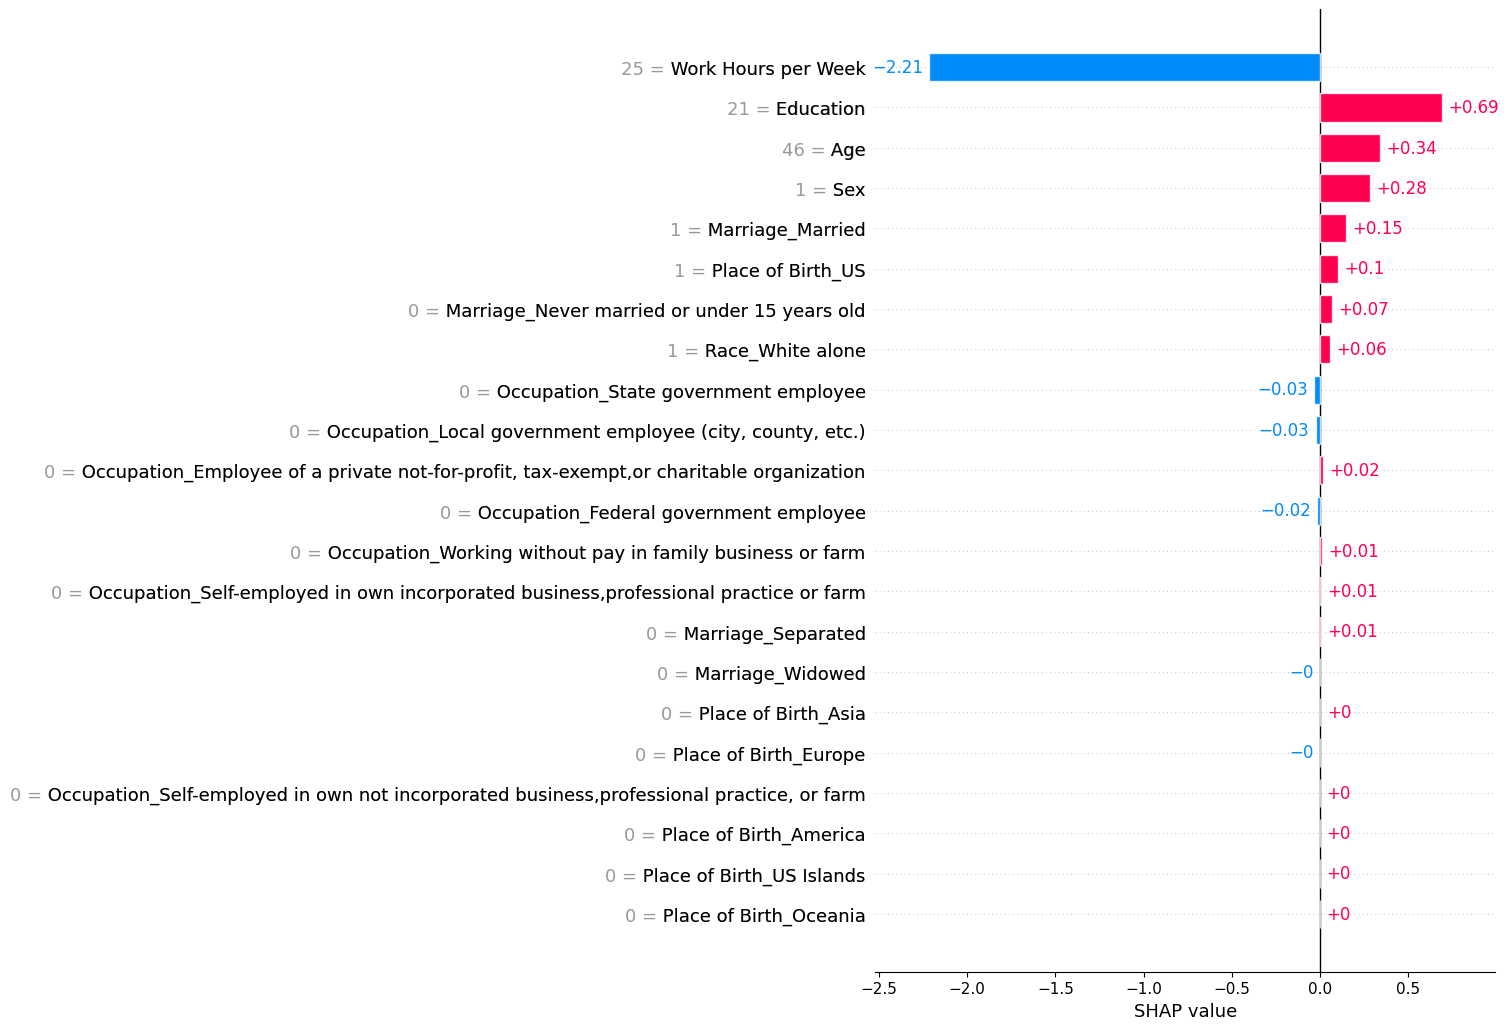

In [48]:
for i in qcut5_top4_idx:
    shap.plots.bar(base_result['shap_vals'][0][i],max_display = 22)

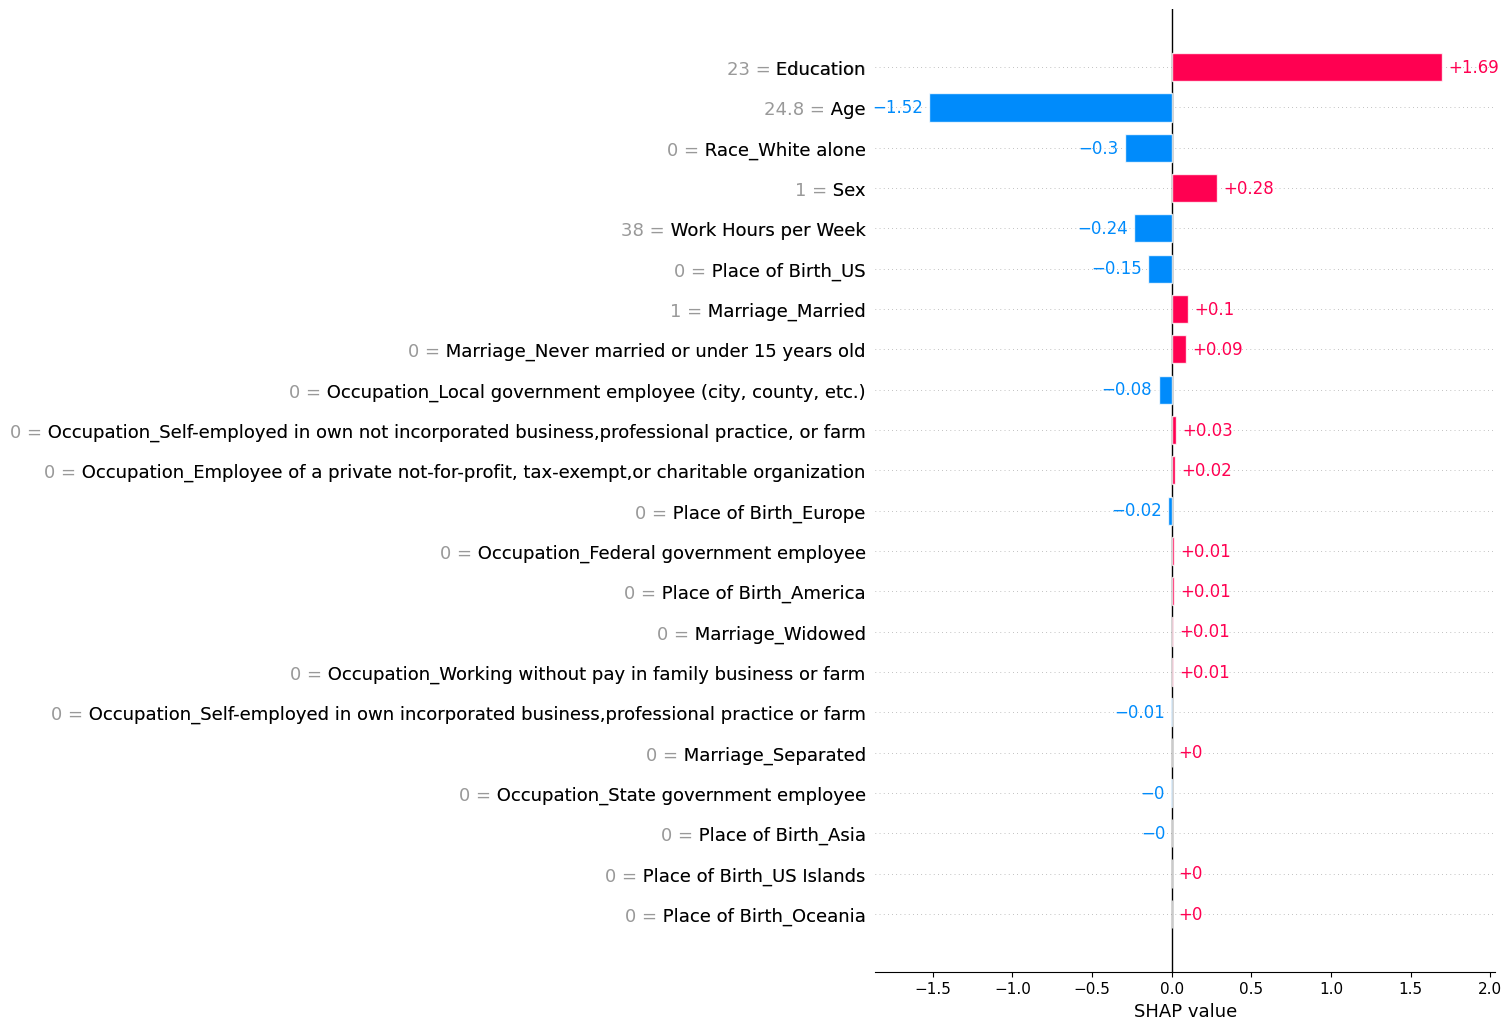

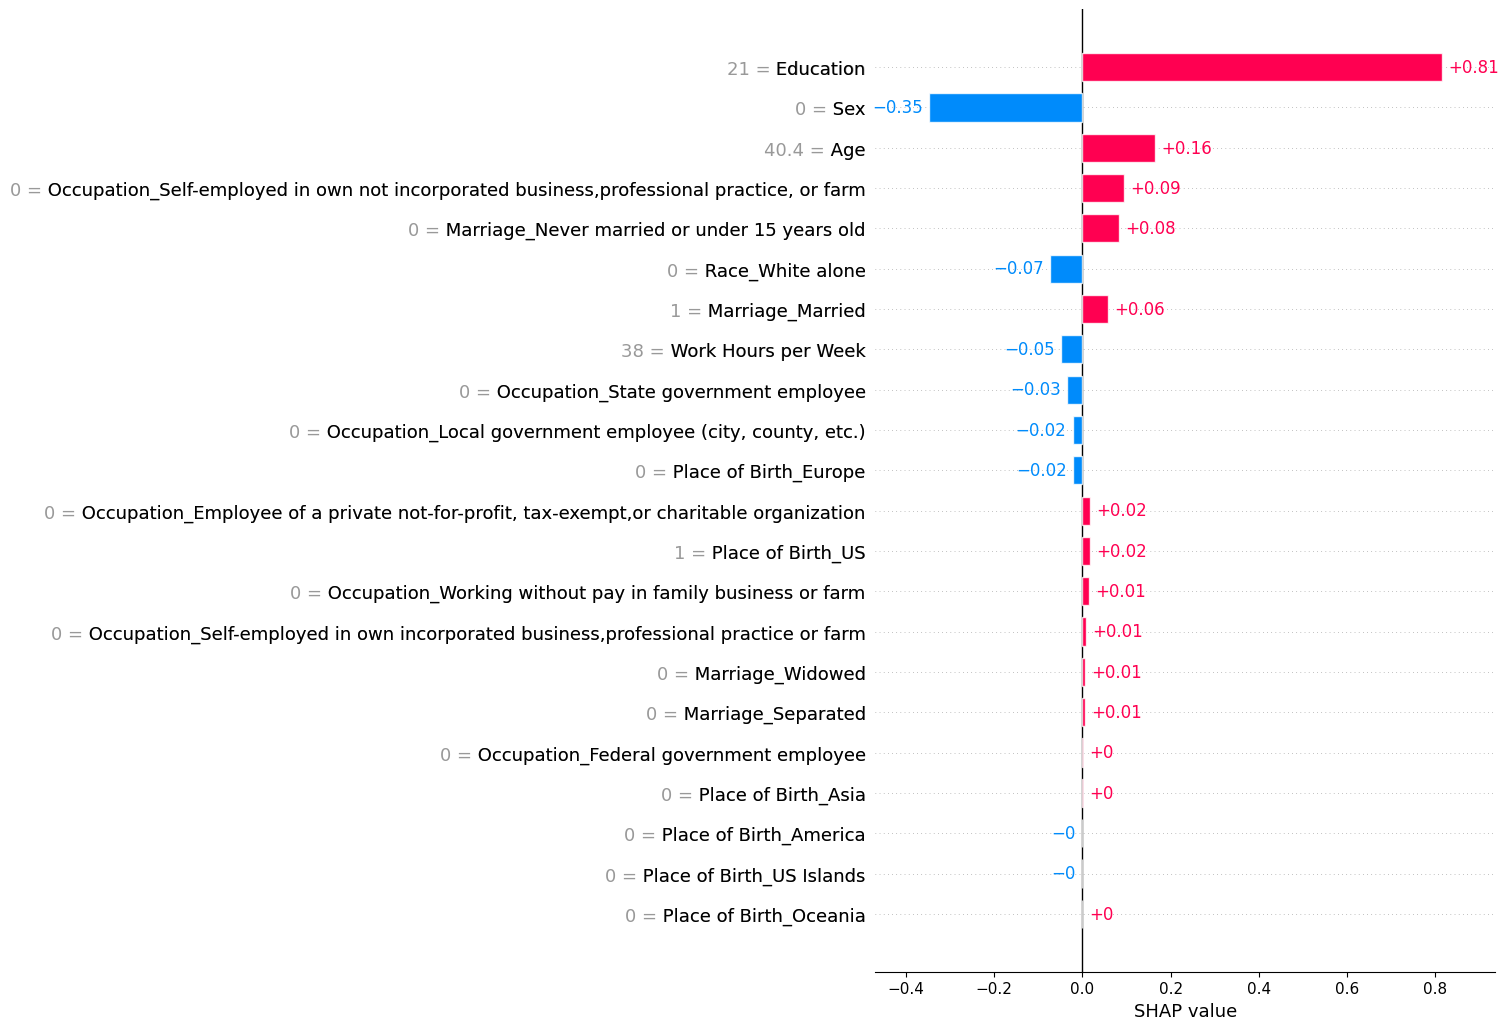

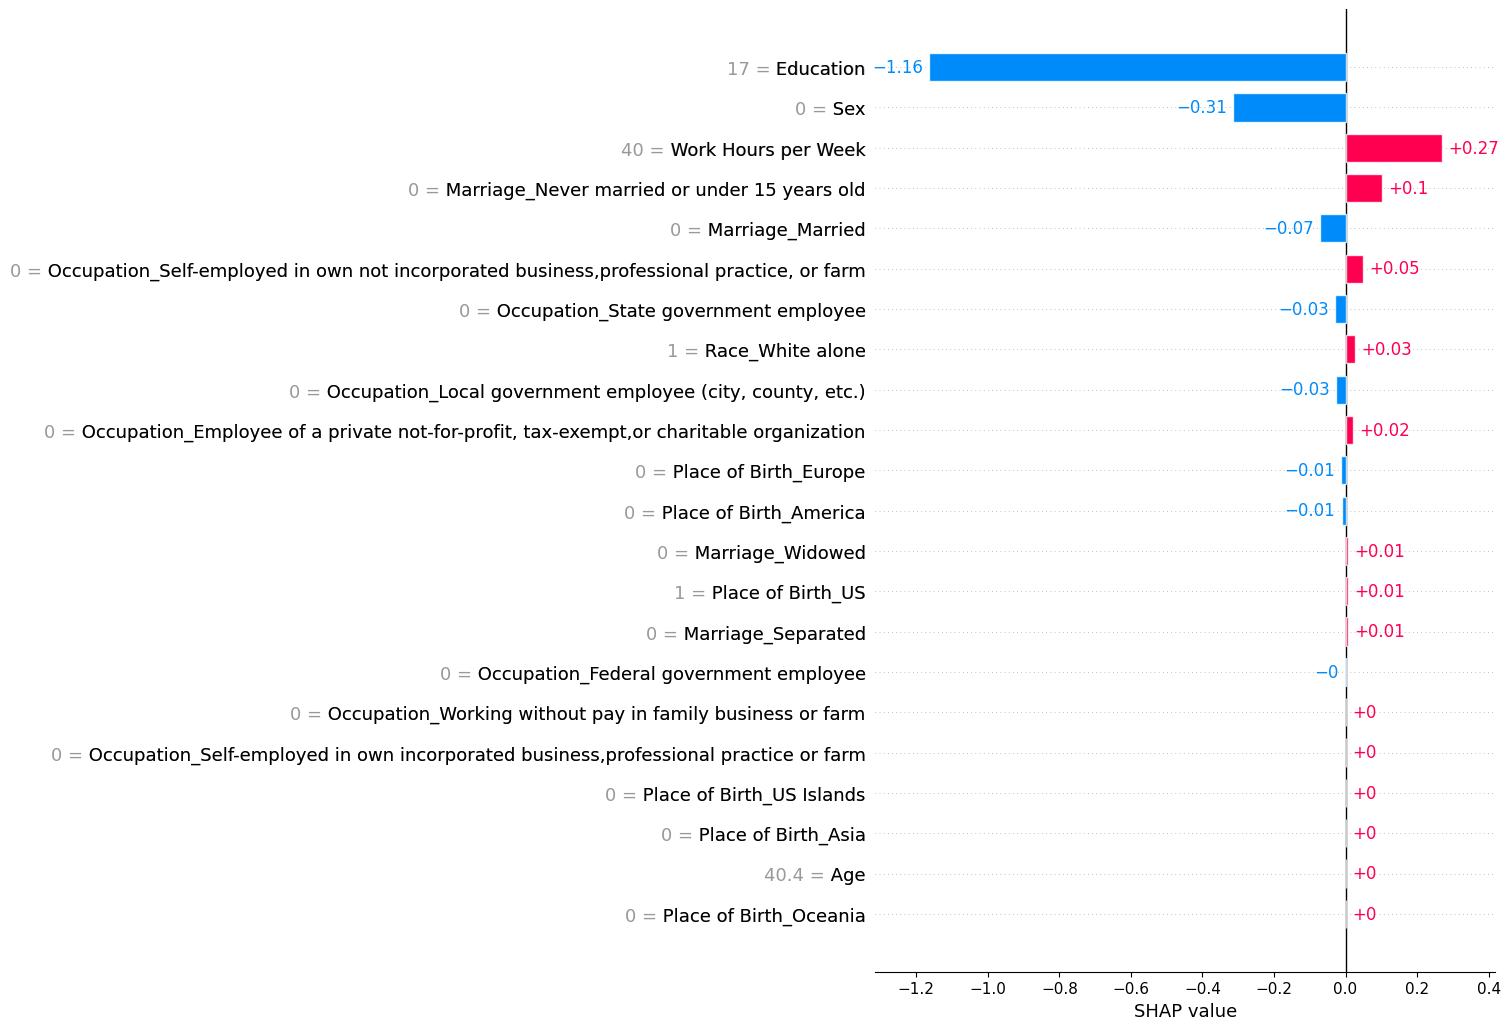

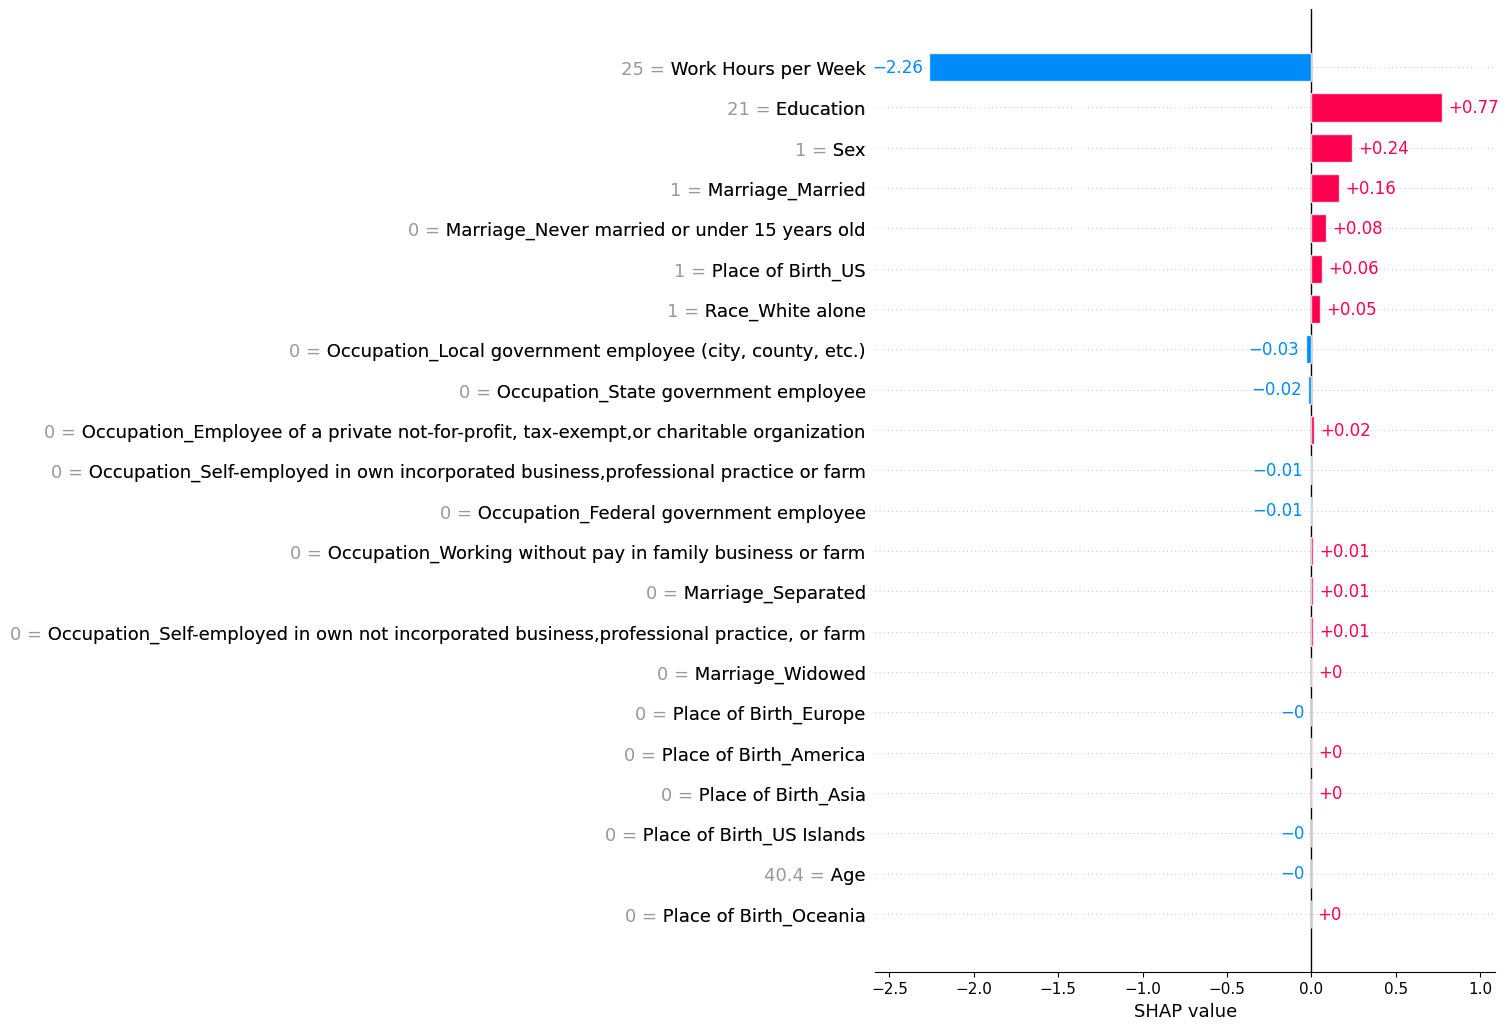

In [49]:
for i in qcut5_top4_idx:
    shap.plots.bar(qcut5_result['shap_vals'][0][i],max_display = 22)

# Qcut 10

**********START**********


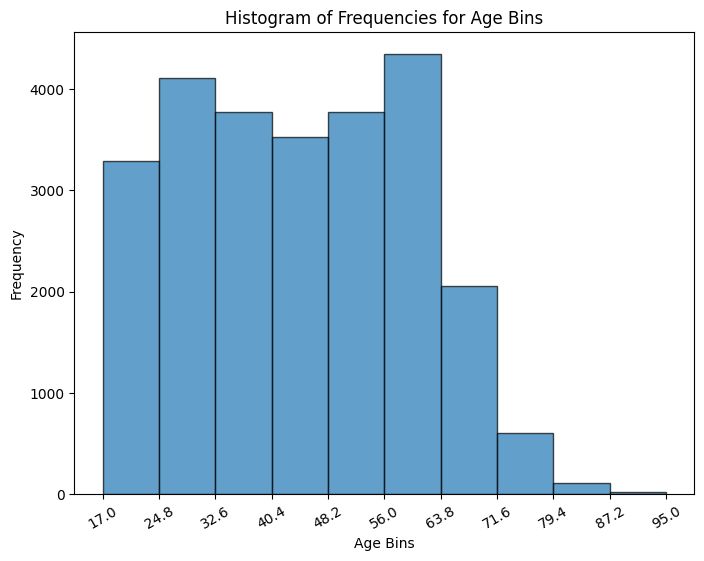

In [50]:
qcut10_bins = analyze_bins('uniform',10)

In [51]:
bin_edges = qcut10_bins
X5 = X.copy()
X5['Age'] = X5['Age'].apply(assign_age)
qcut10_result = train_test(X5,Y,base=False)

**********START**********
Overall average acc: 77.18 average f1s : 73.48


## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.845200
1                                           Education            0.882703
2                                 Work Hours per Week            0.894218
3                                                 Sex            0.261580
4   Occupation_Employee of a private not-for-profi...            0.043870
5              Occupation_Federal government employee            0.019654
6   Occupation_Local government employee (city, co...            0.065001
7   Occupation_Self-employed in own incorporated b...            0.032532
8   Occupation_Self-employed in own not incorporat...            0.084385
9                Occupation_State government employee            0.044062
10  Occupation_Working without pay in family busin...            0.005088
11                                   Marriage_Married            0.111064
12       Marriage_Neve

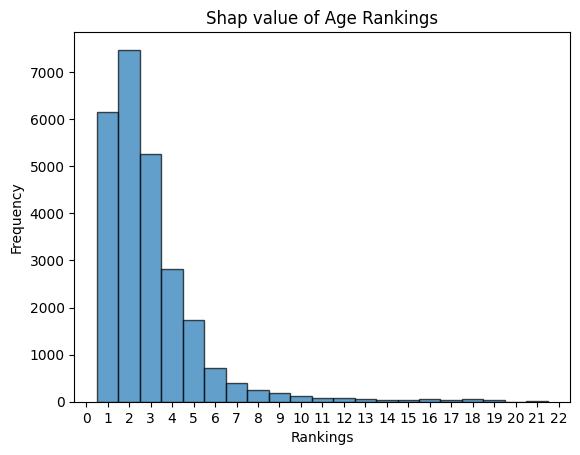

In [52]:
for sv in qcut10_result['shap_vals']:
    sv = sv.values
    qcut10_ranks = analyze_shap(sv)
    break

In [53]:
for i in range(FOLDS):
    preds = base_result['preds'][i]
    sv = qcut10_result['shap_vals'][i].values
    base = qcut10_result['shap_vals'][i].base_values
    break
qcut10_fidelity,qcut10_agreed = compute_fidelity(preds,sv,base)
print(f'fidelity {qcut10_fidelity*100:.3f}')

fidelity 96.230


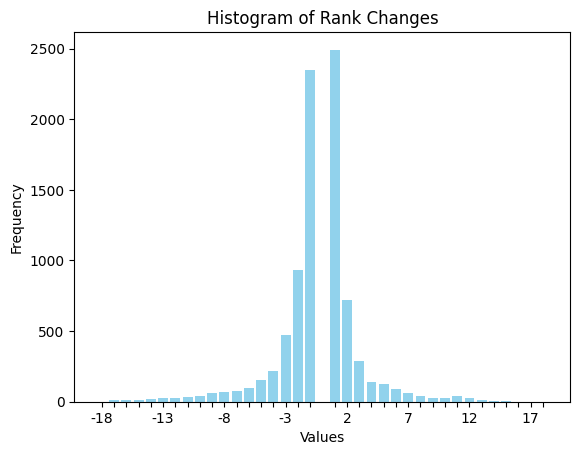

Average individual difference 0.210
abs Rank change by rank FULL 0.809
abs Rank change by rank 2.374
% of Rank difference 34.06 

kendal tau 0.89989435429773


In [54]:
for i in range(FOLDS):
    s1 = base_result['shap_vals'][i]
    s2 = qcut10_result['shap_vals'][i]
    qcut10_top4_idx = compare_results(s1, s2, base_ranks, qcut10_ranks ,qcut10_agreed)
    break

## Qcut10 Errors

In [55]:
tps,fps,tns,fns = get_tfs(base_result['preds'], qcut10_result['shap_vals'],Y_test)

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.483778
1                                           Education            0.958086
2                                 Work Hours per Week            0.657156
3                                                 Sex            0.270926
4   Occupation_Employee of a private not-for-profi...            0.046641
5              Occupation_Federal government employee            0.023660
6   Occupation_Local government employee (city, co...            0.090152
7   Occupation_Self-employed in own incorporated b...            0.034587
8   Occupation_Self-employed in own not incorporat...            0.085610
9                Occupation_State government employee            0.056416
10  Occupation_Working without pay in family busin...            0.003817
11                                   Marriage_Married            0.114119
12       Marriage_Neve

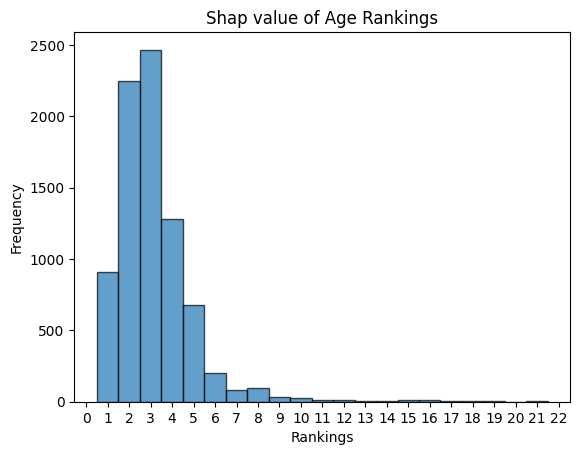

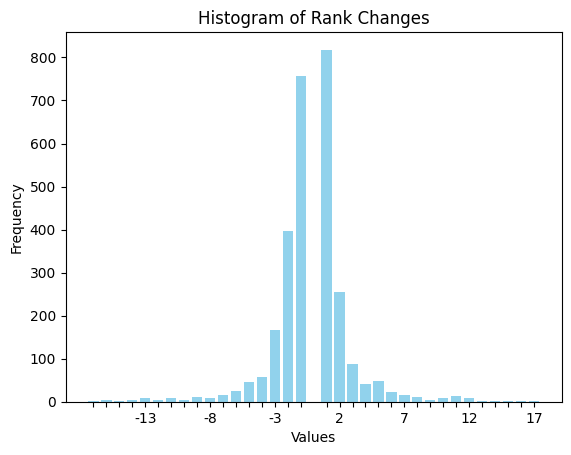

abs Rank change by rank FULL 0.765
abs Rank change by rank 2.164
% of Rank difference 35.36 

kendal tau 0.9100900747581425
fidelity 96.563


In [56]:
for i in range(FOLDS):
    sv = qcut10_result['shap_vals'][i].values[tps,:]
    preds = base_result['preds'][i][tps]
    base =  qcut10_result['shap_vals'][i].base_values[tps]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut10_tps_rank = analyze_shap(sv)
    
    compare_ranks(base_tps,qcut10_tps_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.527943
1                                           Education            0.819149
2                                 Work Hours per Week            0.604812
3                                                 Sex            0.280253
4   Occupation_Employee of a private not-for-profi...            0.046062
5              Occupation_Federal government employee            0.026989
6   Occupation_Local government employee (city, co...            0.085893
7   Occupation_Self-employed in own incorporated b...            0.034923
8   Occupation_Self-employed in own not incorporat...            0.093562
9                Occupation_State government employee            0.053981
10  Occupation_Working without pay in family busin...            0.004938
11                                   Marriage_Married            0.115519
12       Marriage_Neve

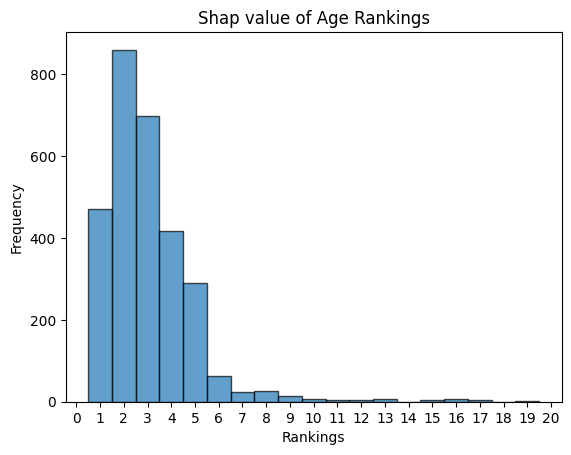

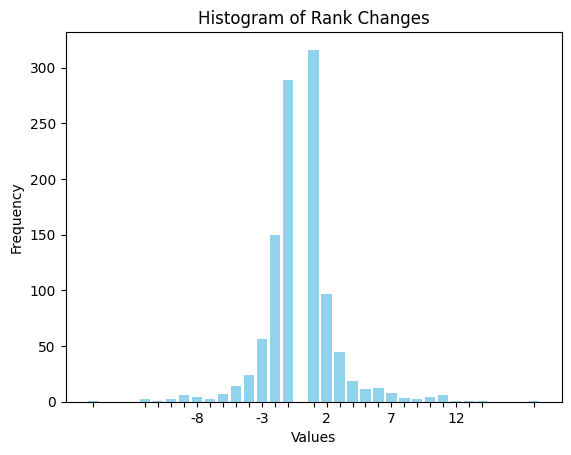

abs Rank change by rank FULL 0.775
abs Rank change by rank 2.069
% of Rank difference 37.48 

kendal tau 0.9077675347105398
fidelity 90.812


In [62]:
for i in range(FOLDS):
    sv = qcut10_result['shap_vals'][i].values[fps,:]
    preds = base_result['preds'][i][fps]
    base =  qcut10_result['shap_vals'][i].base_values[fps]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut10_fps_rank = analyze_shap(sv)
    
    compare_ranks(base_fps,qcut10_fps_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            1.231764
1                                           Education            0.870983
2                                 Work Hours per Week            1.184341
3                                                 Sex            0.245230
4   Occupation_Employee of a private not-for-profi...            0.041746
5              Occupation_Federal government employee            0.015185
6   Occupation_Local government employee (city, co...            0.045251
7   Occupation_Self-employed in own incorporated b...            0.032497
8   Occupation_Self-employed in own not incorporat...            0.074478
9                Occupation_State government employee            0.033433
10  Occupation_Working without pay in family busin...            0.005611
11                                   Marriage_Married            0.110186
12       Marriage_Neve

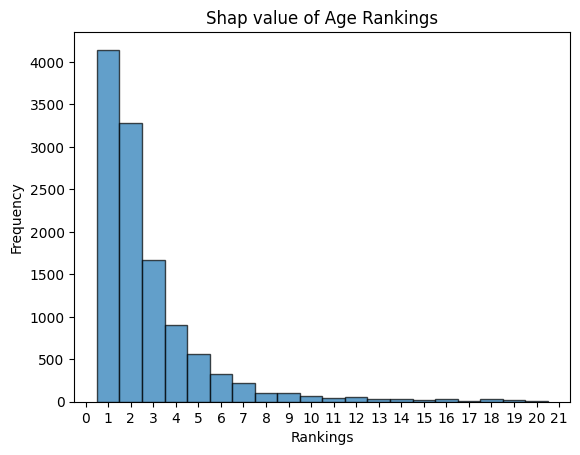

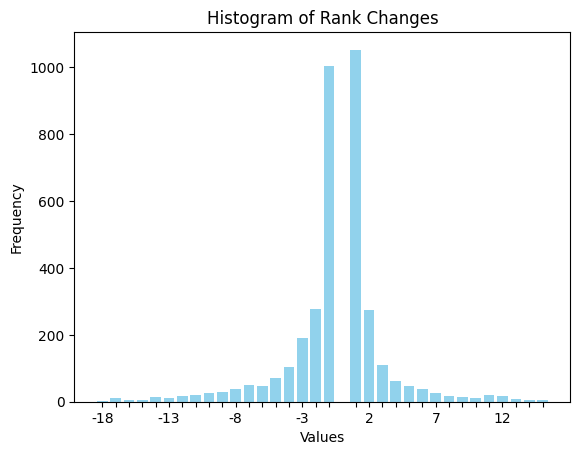

abs Rank change by rank FULL 0.798
abs Rank change by rank 2.567
% of Rank difference 31.08 

kendal tau 0.8917344407271539
fidelity 98.097


In [58]:
for i in range(FOLDS):
    sv = qcut10_result['shap_vals'][i].values[tns,:]
    preds = base_result['preds'][i][tns]
    base =  qcut10_result['shap_vals'][i].base_values[tns]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut10_tns_rank = analyze_shap(sv)
    
    compare_ranks(base_tns,qcut10_tns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

## Average SHAP
                                              Feature  Average Shap value
0                                                 Age            0.618629
1                                           Education            0.784547
2                                 Work Hours per Week            0.680680
3                                                 Sex            0.282318
4   Occupation_Employee of a private not-for-profi...            0.042515
5              Occupation_Federal government employee            0.019141
6   Occupation_Local government employee (city, co...            0.053610
7   Occupation_Self-employed in own incorporated b...            0.024677
8   Occupation_Self-employed in own not incorporat...            0.111239
9                Occupation_State government employee            0.042473
10  Occupation_Working without pay in family busin...            0.006654
11                                   Marriage_Married            0.101772
12       Marriage_Neve

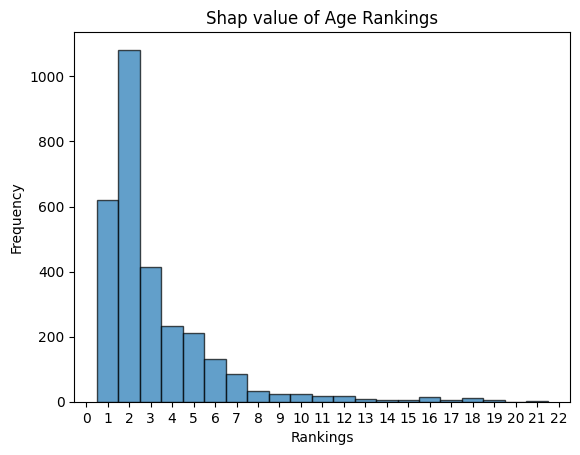

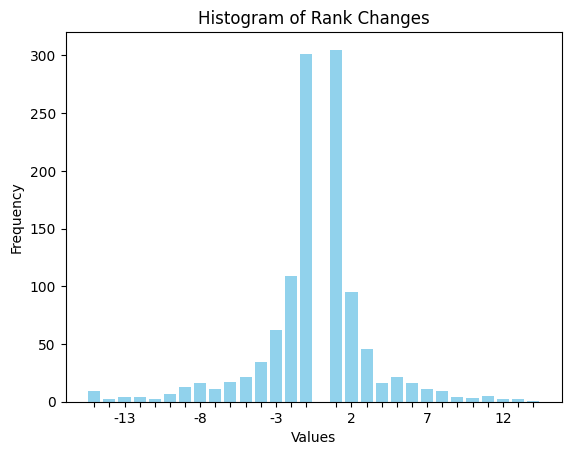

abs Rank change by rank FULL 1.004
abs Rank change by rank 2.576
% of Rank difference 38.98 

kendal tau 0.8964713837379371
fidelity 93.243


In [59]:
for i in range(FOLDS):
    sv = qcut10_result['shap_vals'][i].values[fns,:]
    preds = base_result['preds'][i][fns]
    base =  qcut10_result['shap_vals'][i].base_values[fns]
    fid,_ = compute_fidelity(preds,sv,base)
    qcut10_fns_rank = analyze_shap(sv)
    
    compare_ranks(base_fns,qcut10_fns_rank)
    print(f'fidelity {fid*100:.3f}')
    break

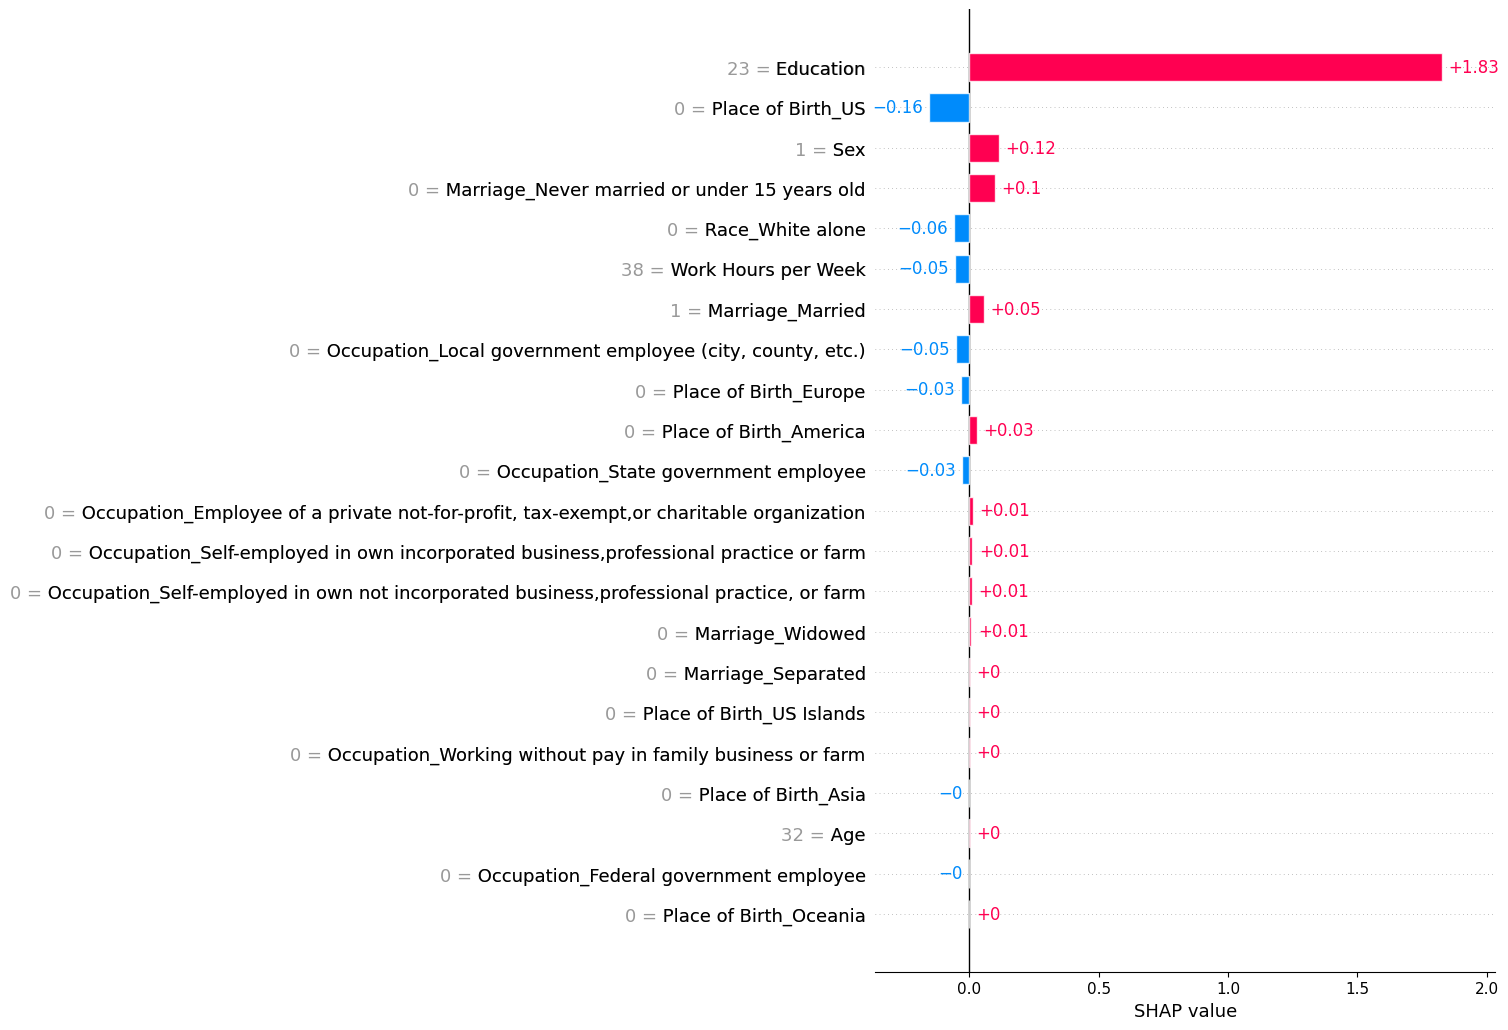

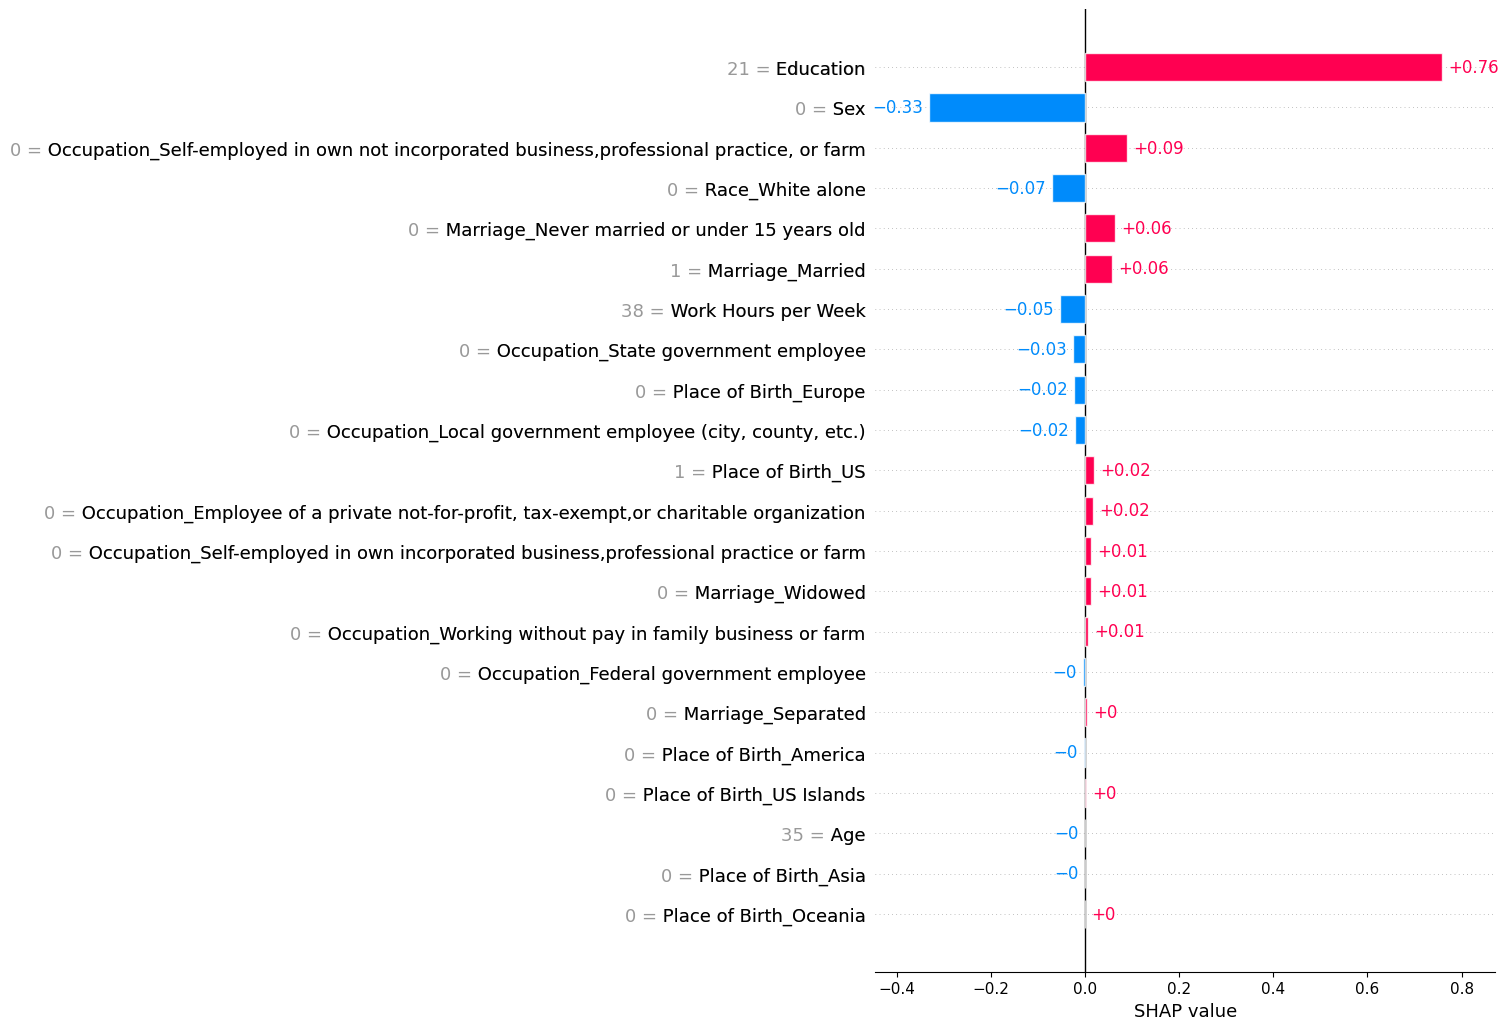

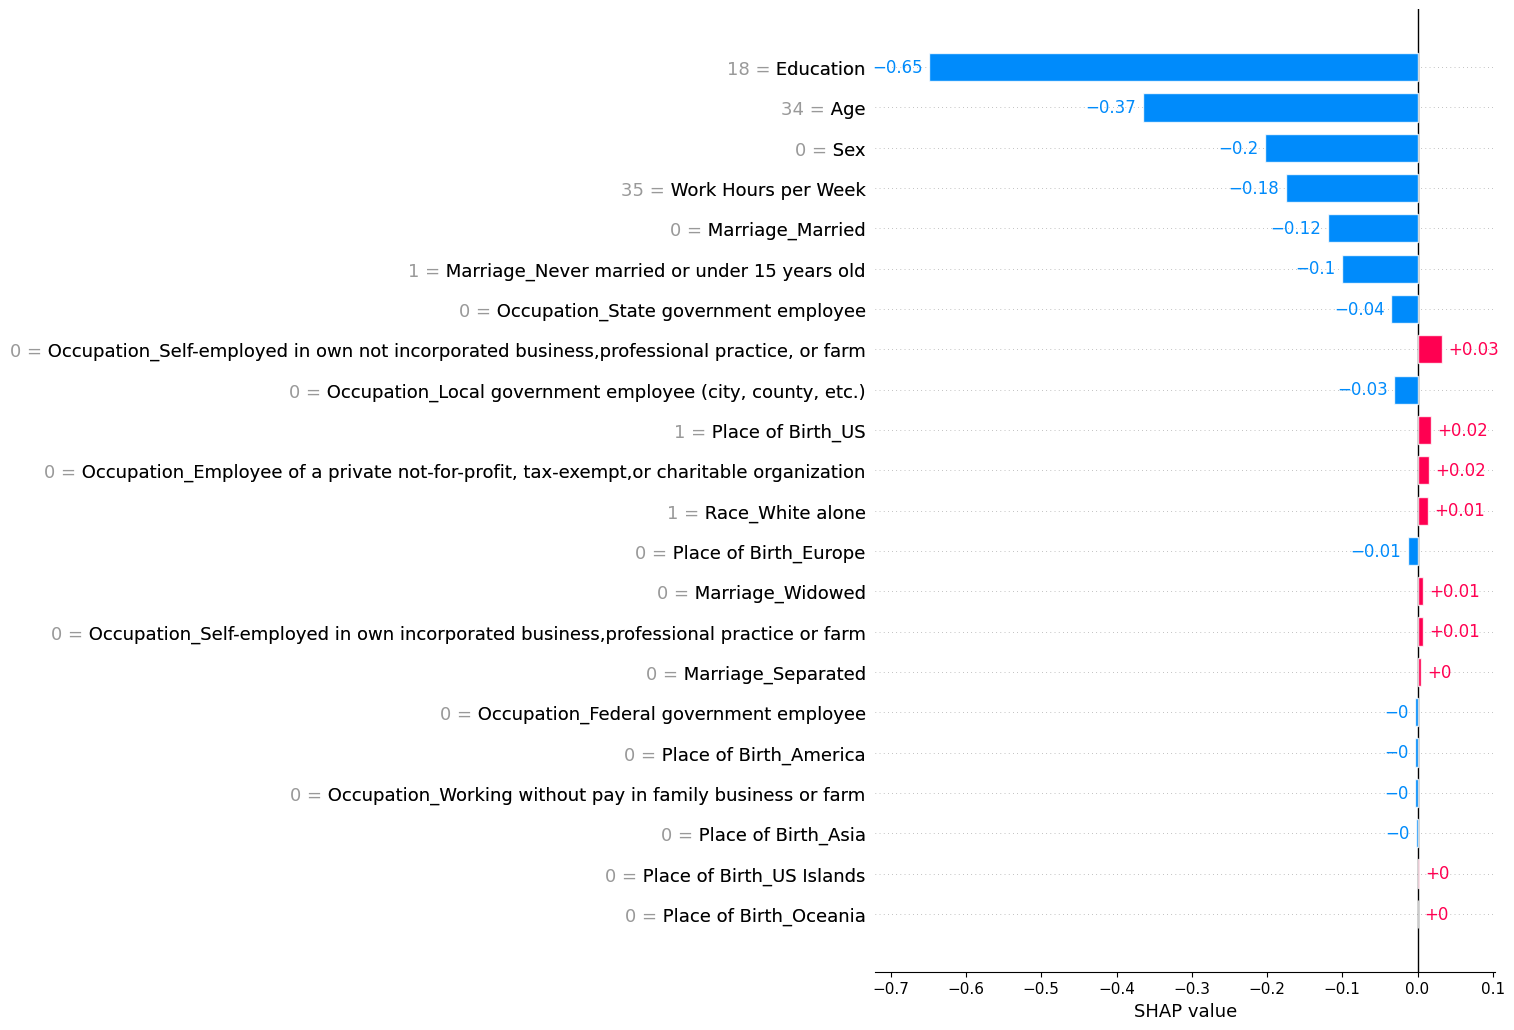

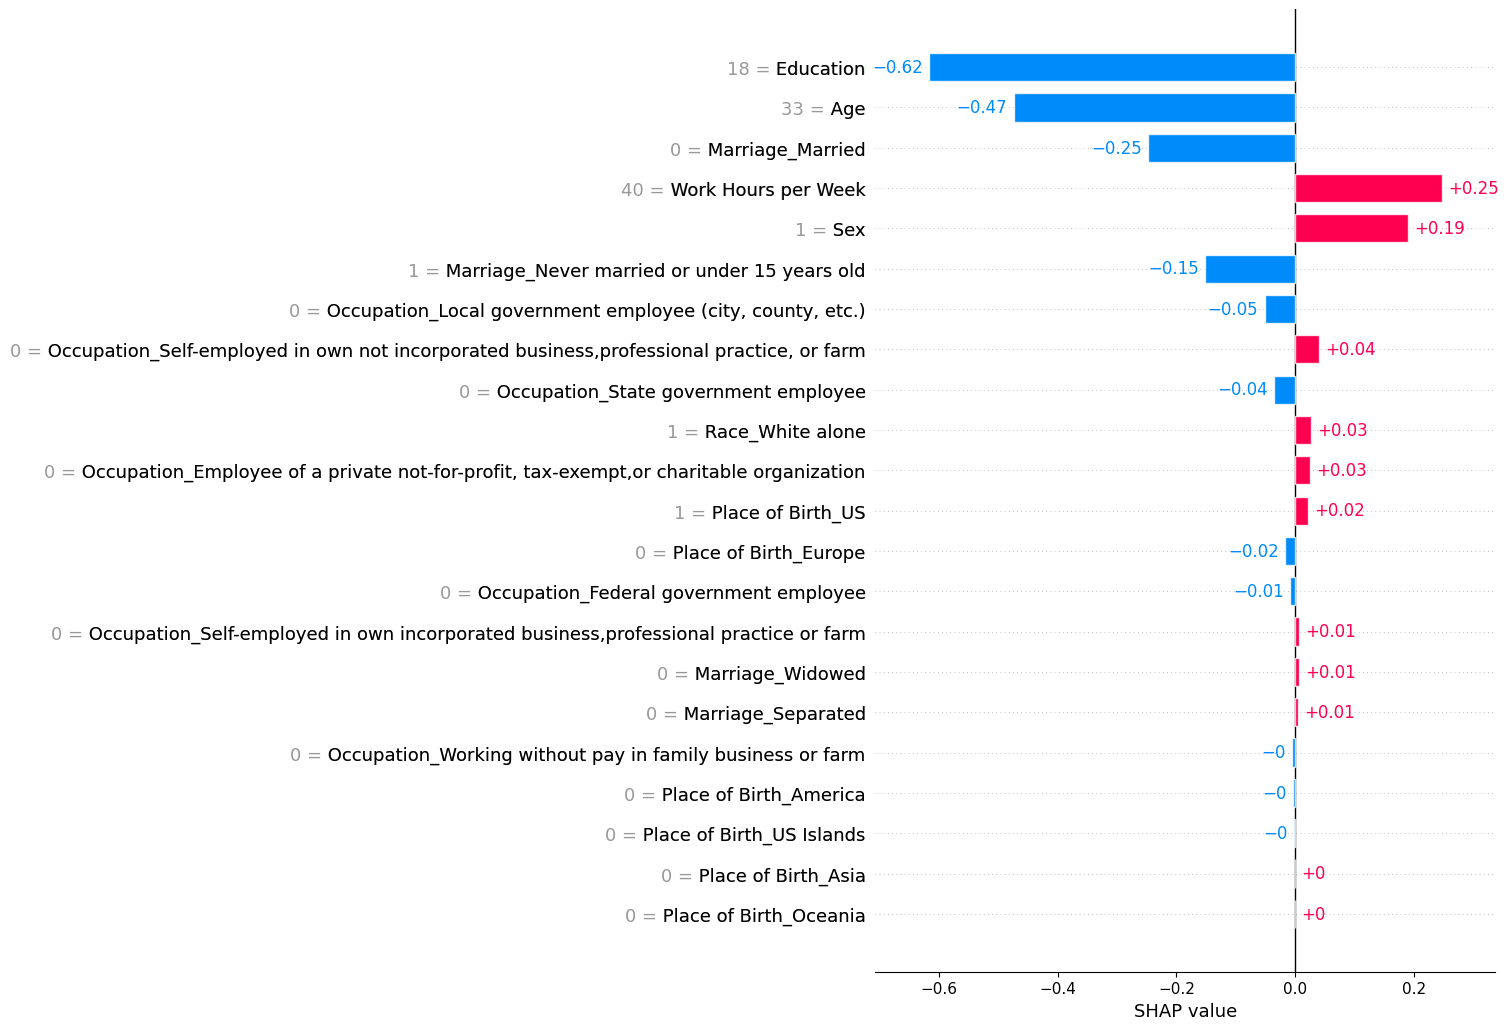

In [60]:
for i in qcut10_top4_idx:
    shap.plots.bar(base_result['shap_vals'][0][i],max_display = 22)

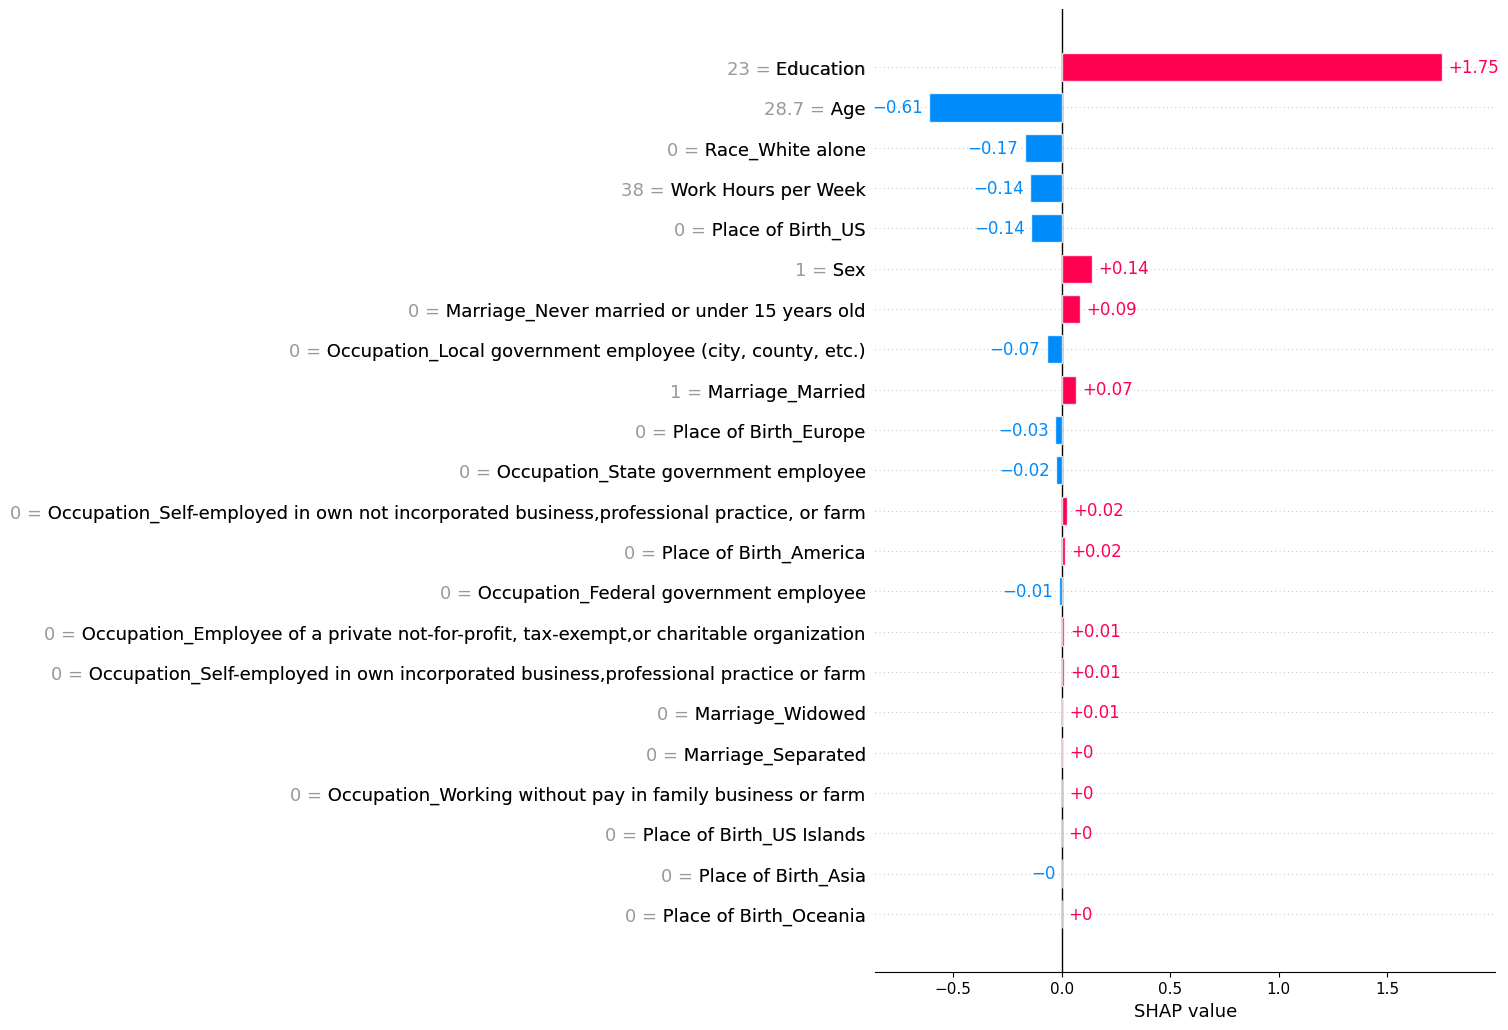

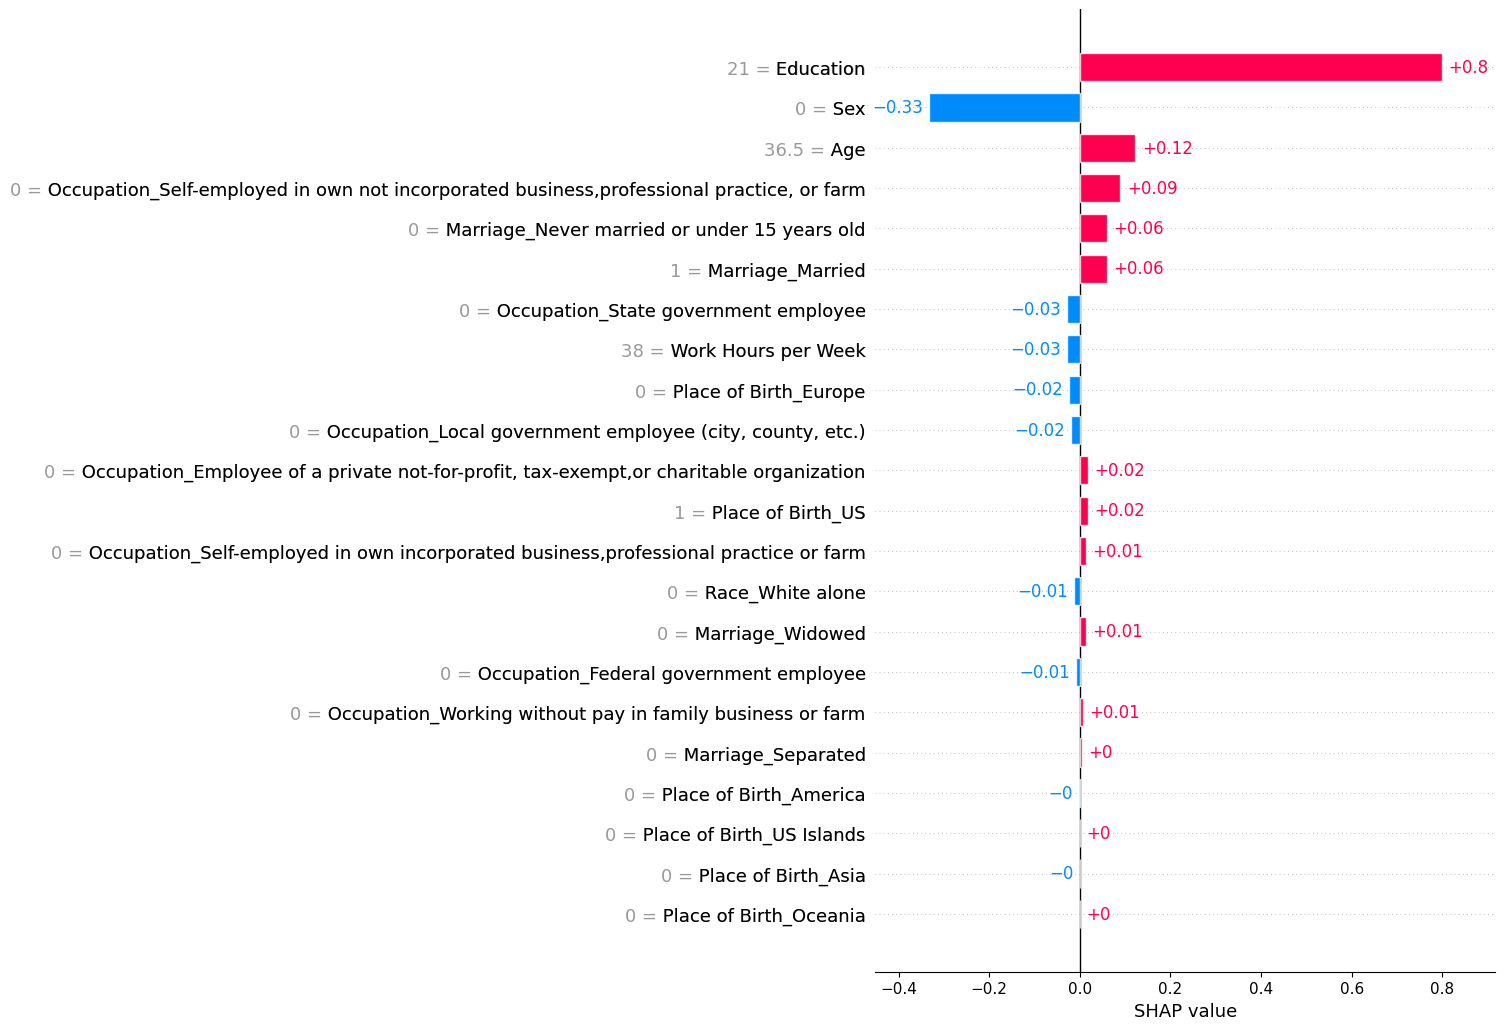

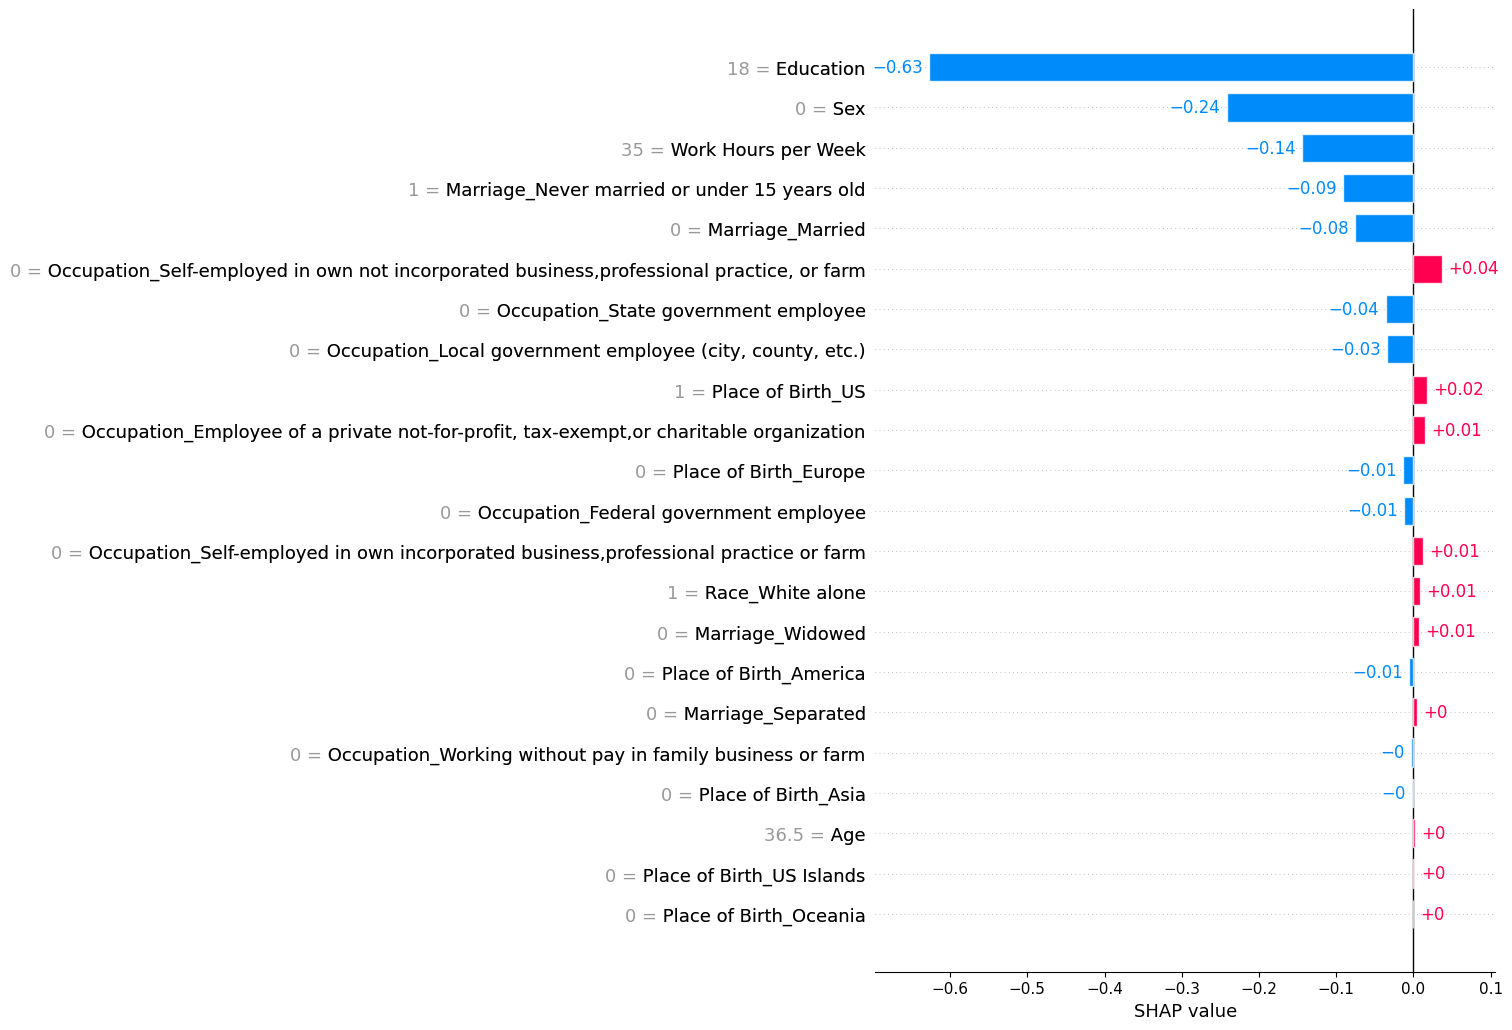

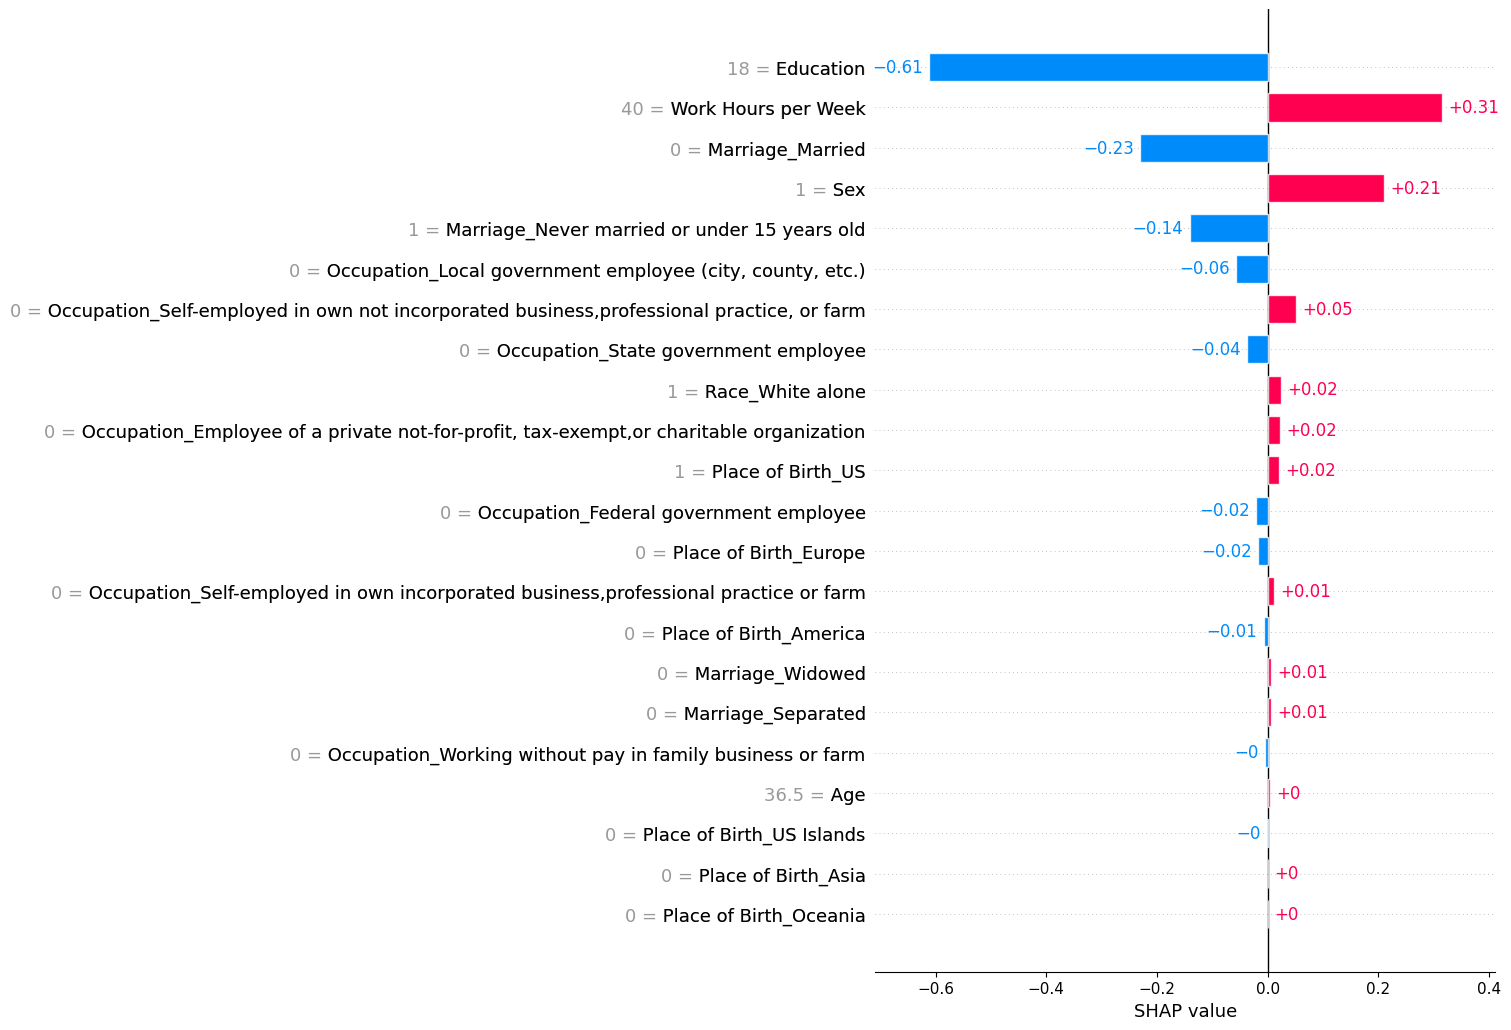

In [61]:
for i in qcut10_top4_idx:
    shap.plots.bar(qcut10_result['shap_vals'][0][i],max_display = 22)